In [1]:
import os
import json
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format ='retina'

sns.set(font_scale=1.5)

sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
jsons = glob('data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/*.json')

In [5]:
jsons

['data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Users-13-04-2021_v0.3.0.json',
 'data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Demands-23-03-2021_v0.5.1.json',
 'data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Frontend-24-03-2021_v0.7.json',
 'data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Frontend-23-04-2021_v1.3.0.json',
 'data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Frontend-18-05-2021_v1.11.0.json',
 'data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Users-14-04-2021_v0.3.1.json',
 'data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Clients-30-04-2021_V1.1.0.json',
 'data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Frontend-30-04-2021_v1.7.1.json',
 'data/fga-eps-mds-2020-2-data/siged/analytics-raw-data/fga-eps-mds-2020-2-SiGeD-Frontend

In [6]:
def read_json(json_path):

    with open(json_path) as json_file:
        json_obj = json.load(json_file)

    return json_obj

In [7]:
def create_base_component_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"SiGeD-(.*?)-2021_(.*?).json", expand=True)


    df['repository'] = aux_df[1].str.split("-", expand=True)[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [8]:
base_component_df = create_base_component_df(jsons)

In [9]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
711,duplicated_lines_density,0.0,True,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
712,functions,32,NaN,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
713,security_rating,1.0,True,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
714,files,8,NaN,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
715,complexity,45,NaN,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
716,ncloc,413,NaN,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
717,coverage,59.5,False,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
718,reliability_rating,1.0,True,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
719,comment_lines_density,0.0,False,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
540,duplicated_lines_density,0.0,True,fga-eps-mds-2020-2-SiGeD-Clients-30-04-2021_V1...,Clients,V1.0.1


In [10]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [11]:
def metric_per_file(json):

    file_json = []

    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)

    return file_json

In [12]:
def generate_file_dataframe(metric_list, json, language_extension):

    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)

    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass

    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [13]:
def create_file_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)

        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe(metric_list, file_component_data, language_extension = 'js')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"SiGeD-(.*?)-2021_(.*?).json", expand=True)

    df['repository'] = aux_df[1].str.split("-", expand=True)[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [14]:
file_component_df = create_file_df(jsons)

In [15]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
5181,tests/api.test.js,8,8,0.0,0.0,NaN,120,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
5182,src/Controllers/ClientController.js,6,11,0.0,0.0,46.4,91,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
5183,src/Models/ClientSchema.js,0,0,0.0,0.0,100.0,51,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
5184,src/utils/functionsJWS.js,2,4,0.0,0.0,73.3,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
5185,src/index.js,3,3,0.0,0.0,94.1,28,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
5186,scripts/release.js,7,8,0.0,0.0,0.0,61,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
5187,src/routes.js,0,0,0.0,0.0,100.0,10,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
5188,src/utils/validate.js,6,11,0.0,0.0,94.9,36,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-20-04-2021_V1...,Clients,V1.0.0
3656,tests/api.test.js,14,14,0.0,0.0,NaN,190,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-30-04-2021_V1...,Clients,V1.0.1
3657,src/Controllers/ClientController.js,6,11,0.0,0.0,89.3,91,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-30-04-2021_V1...,Clients,V1.0.1


In [16]:
clients_df = file_component_df[file_component_df['repository'] == 'Clients']
demands_df = file_component_df[file_component_df['repository'] == 'Demands']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']
sectors_df = file_component_df[file_component_df['repository'] == 'Sectors']
users_df = file_component_df[file_component_df['repository'] == 'Users']

#### COMPLEXITY

In [17]:
def m1(df):

    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)

    return density_non_complex_files

#### COMMENTS

In [18]:
def m2(df):

    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)

    return density_comment_files

#### DUPLICATIONS

In [19]:
def m3(df):

    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)

    return duplication

In [20]:
def create_metrics_df(df):

    version_vec = df['version'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'repository': repository_list,
                               'version': version_list})

    return metrics_df

In [21]:
users_metrics = create_metrics_df(users_df)
sectors_metrics = create_metrics_df(sectors_df)
frontend_metrics = create_metrics_df(frontend_df)
demands_metrics = create_metrics_df(demands_df)
clients_metrics = create_metrics_df(clients_df)

In [22]:
clients_metrics

,m1,m2,m3,repository,version
0,0.750000,0.0,1.000000,Clients,V1.0.0
1,0.750000,0.0,1.000000,Clients,V1.0.1
2,0.714286,0.0,0.928571,Clients,V1.1.0
3,0.714286,0.0,0.928571,Clients,V1.1.1
4,0.666667,0.0,0.916667,Clients,V1.2.0
5,0.666667,0.0,0.916667,Clients,V1.3.0
6,0.600000,0.0,1.000000,Clients,v0.1
7,0.600000,0.0,1.000000,Clients,v0.2
8,0.600000,0.0,1.000000,Clients,v0.3.0
9,0.600000,0.0,1.000000,Clients,v0.3.1


In [23]:
demands_metrics

,m1,m2,m3,repository,version
0,0.600000,0.0,1.000000,Demands,v0.1
1,0.600000,0.0,1.000000,Demands,v0.2
2,0.600000,0.0,1.000000,Demands,v0.3
3,0.600000,0.0,1.000000,Demands,v0.4.0
4,0.600000,0.0,1.000000,Demands,v0.5.0
5,0.600000,0.0,1.000000,Demands,v0.5.1
6,0.700000,0.0,1.000000,Demands,v0.5.2
7,0.700000,0.0,1.000000,Demands,v0.6.0
8,0.700000,0.0,1.000000,Demands,v0.7.0
9,0.700000,0.0,1.000000,Demands,v0.8.0


In [24]:
frontend_metrics

,m1,m2,m3,repository,version
0,0.666667,0.000000,0.971014,Frontend,v0.1
1,0.666667,0.000000,0.971014,Frontend,v0.10.0
2,0.666667,0.000000,0.971014,Frontend,v0.10.1
3,0.649573,0.000000,0.965812,Frontend,v0.10.2
4,0.647059,0.000000,0.983193,Frontend,v0.11.0
5,0.647059,0.000000,0.983193,Frontend,v0.11.1
6,0.647059,0.000000,0.983193,Frontend,v0.12.0
7,0.650000,0.000000,0.983333,Frontend,v0.13.0
8,0.650000,0.000000,0.983333,Frontend,v0.14.0
9,0.661157,0.000000,0.975207,Frontend,v0.14.1


In [25]:
sectors_metrics

,m1,m2,m3,repository,version
0,0.750000,0.0,1.0,Sectors,v0.1.0
1,0.750000,0.0,1.0,Sectors,v1.0.0
2,0.750000,0.0,1.0,Sectors,v1.0.1
3,0.750000,0.0,1.0,Sectors,v1.1.0
4,0.666667,0.0,1.0,Sectors,v1.1.1
5,0.625000,0.0,1.0,Sectors,v1.1.2
6,0.625000,0.0,1.0,Sectors,v1.2.0


In [26]:
users_metrics

,m1,m2,m3,repository,version
0,0.714286,0.0,1.0,Users,v0.1
1,0.714286,0.0,1.0,Users,v0.2
2,0.714286,0.0,1.0,Users,v0.3.0
3,0.750000,0.0,1.0,Users,v0.3.1
4,0.777778,0.0,1.0,Users,v0.3.2
5,0.777778,0.0,1.0,Users,v1.0.0
6,0.636364,0.0,1.0,Users,v1.0.1
7,0.636364,0.0,1.0,Users,v1.0.2
8,0.600000,0.0,1.0,Users,v1.0.3
9,0.600000,0.0,1.0,Users,v1.1.0


## Repository: User

### m1

(0.6, 0.8)

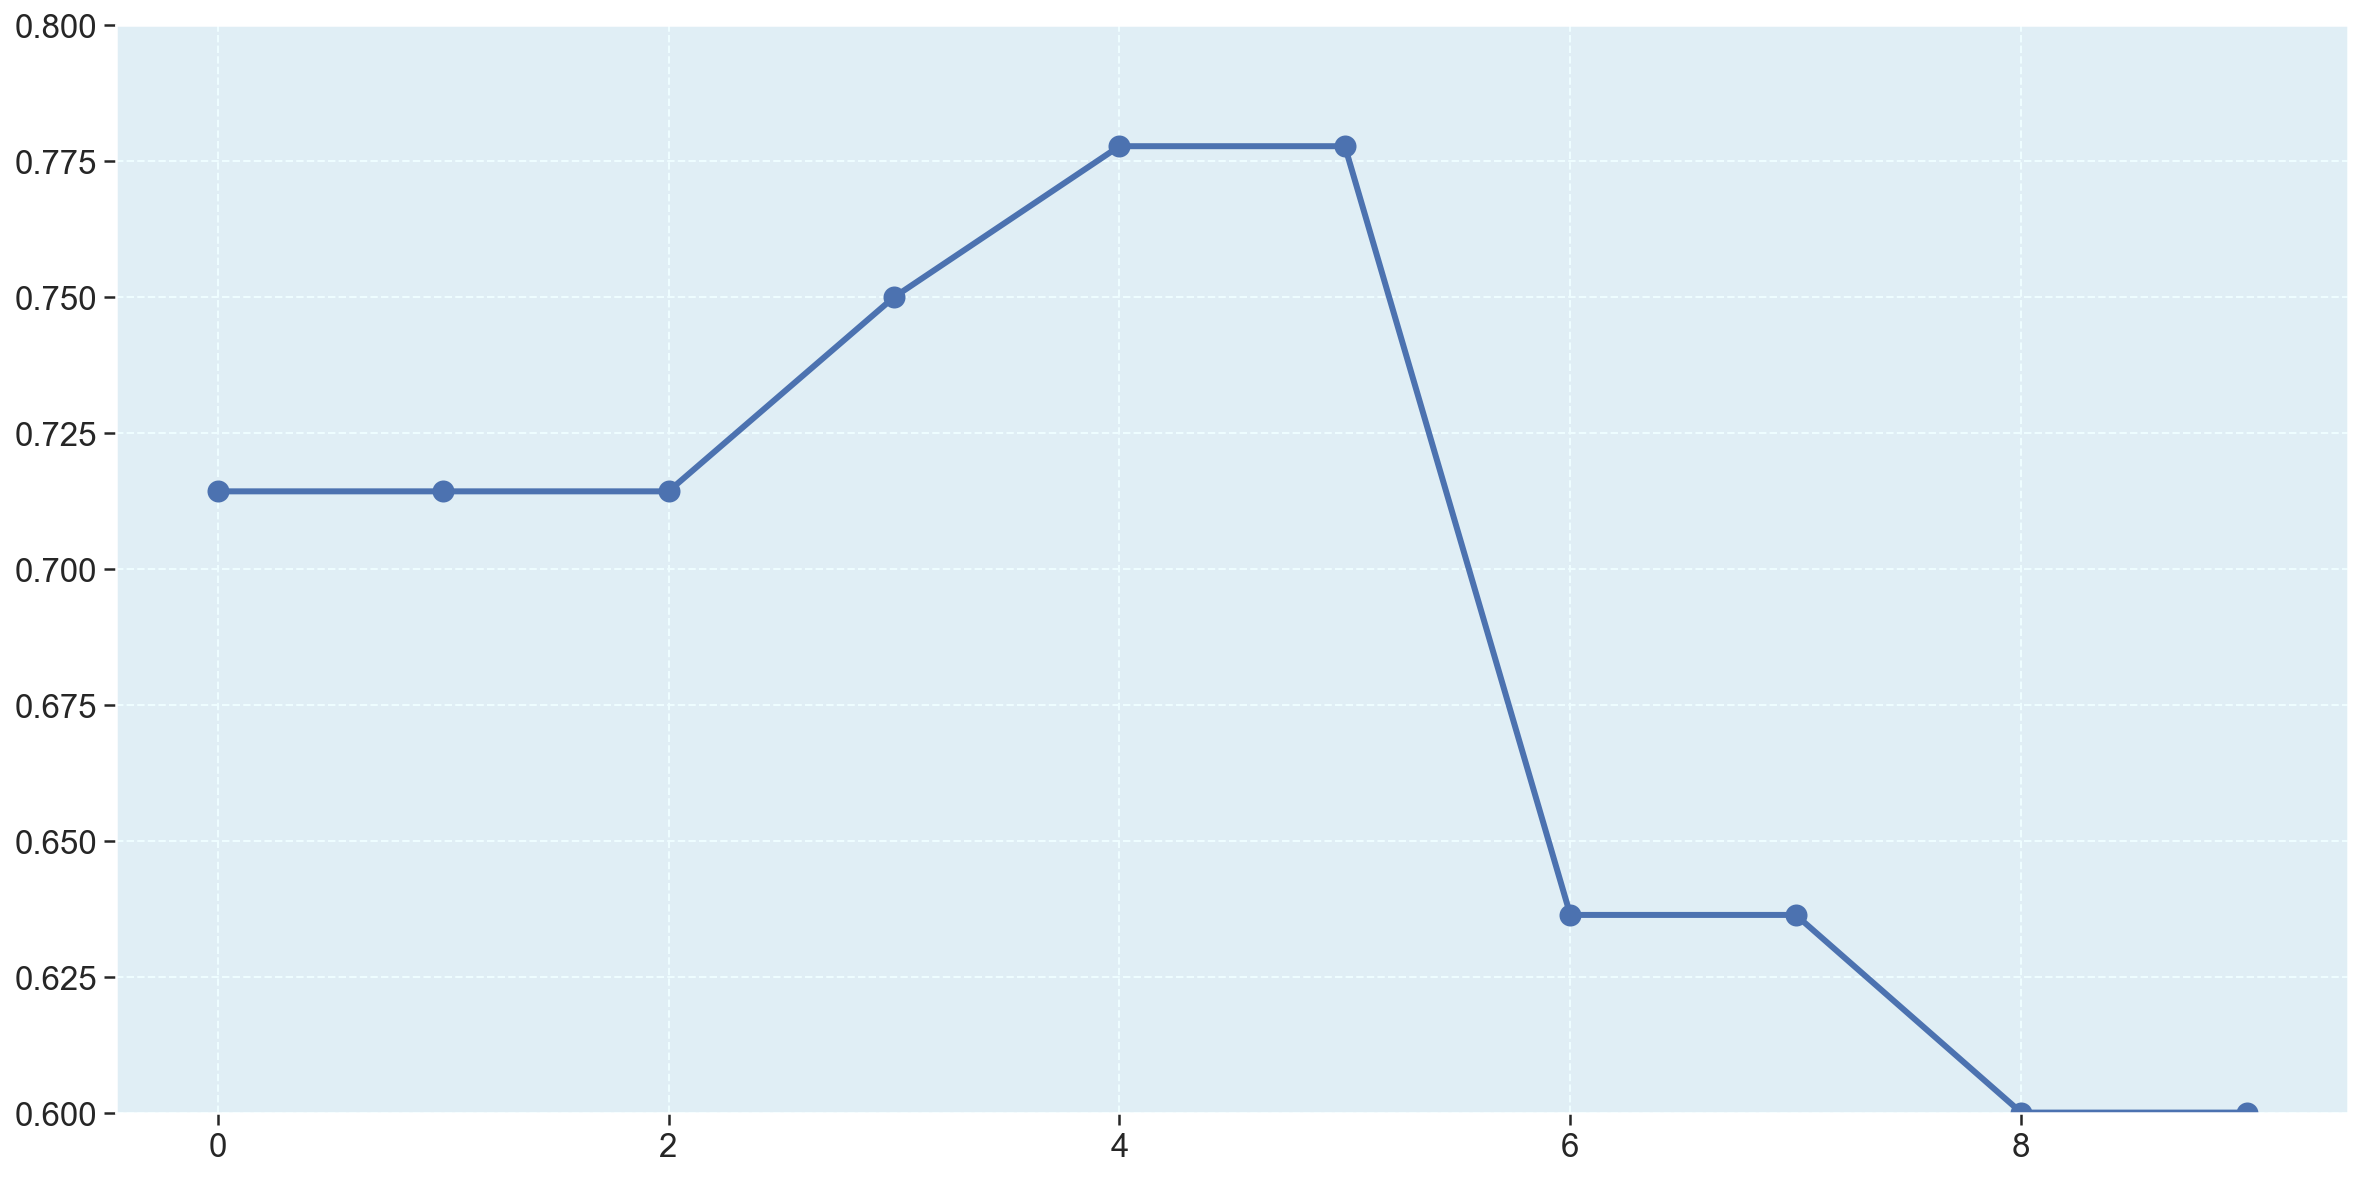

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['m1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.6,.8, color="#c9f9ff", alpha=0.3)

plt.ylim(.6,.8)


### m2

(-0.06, 0.06)

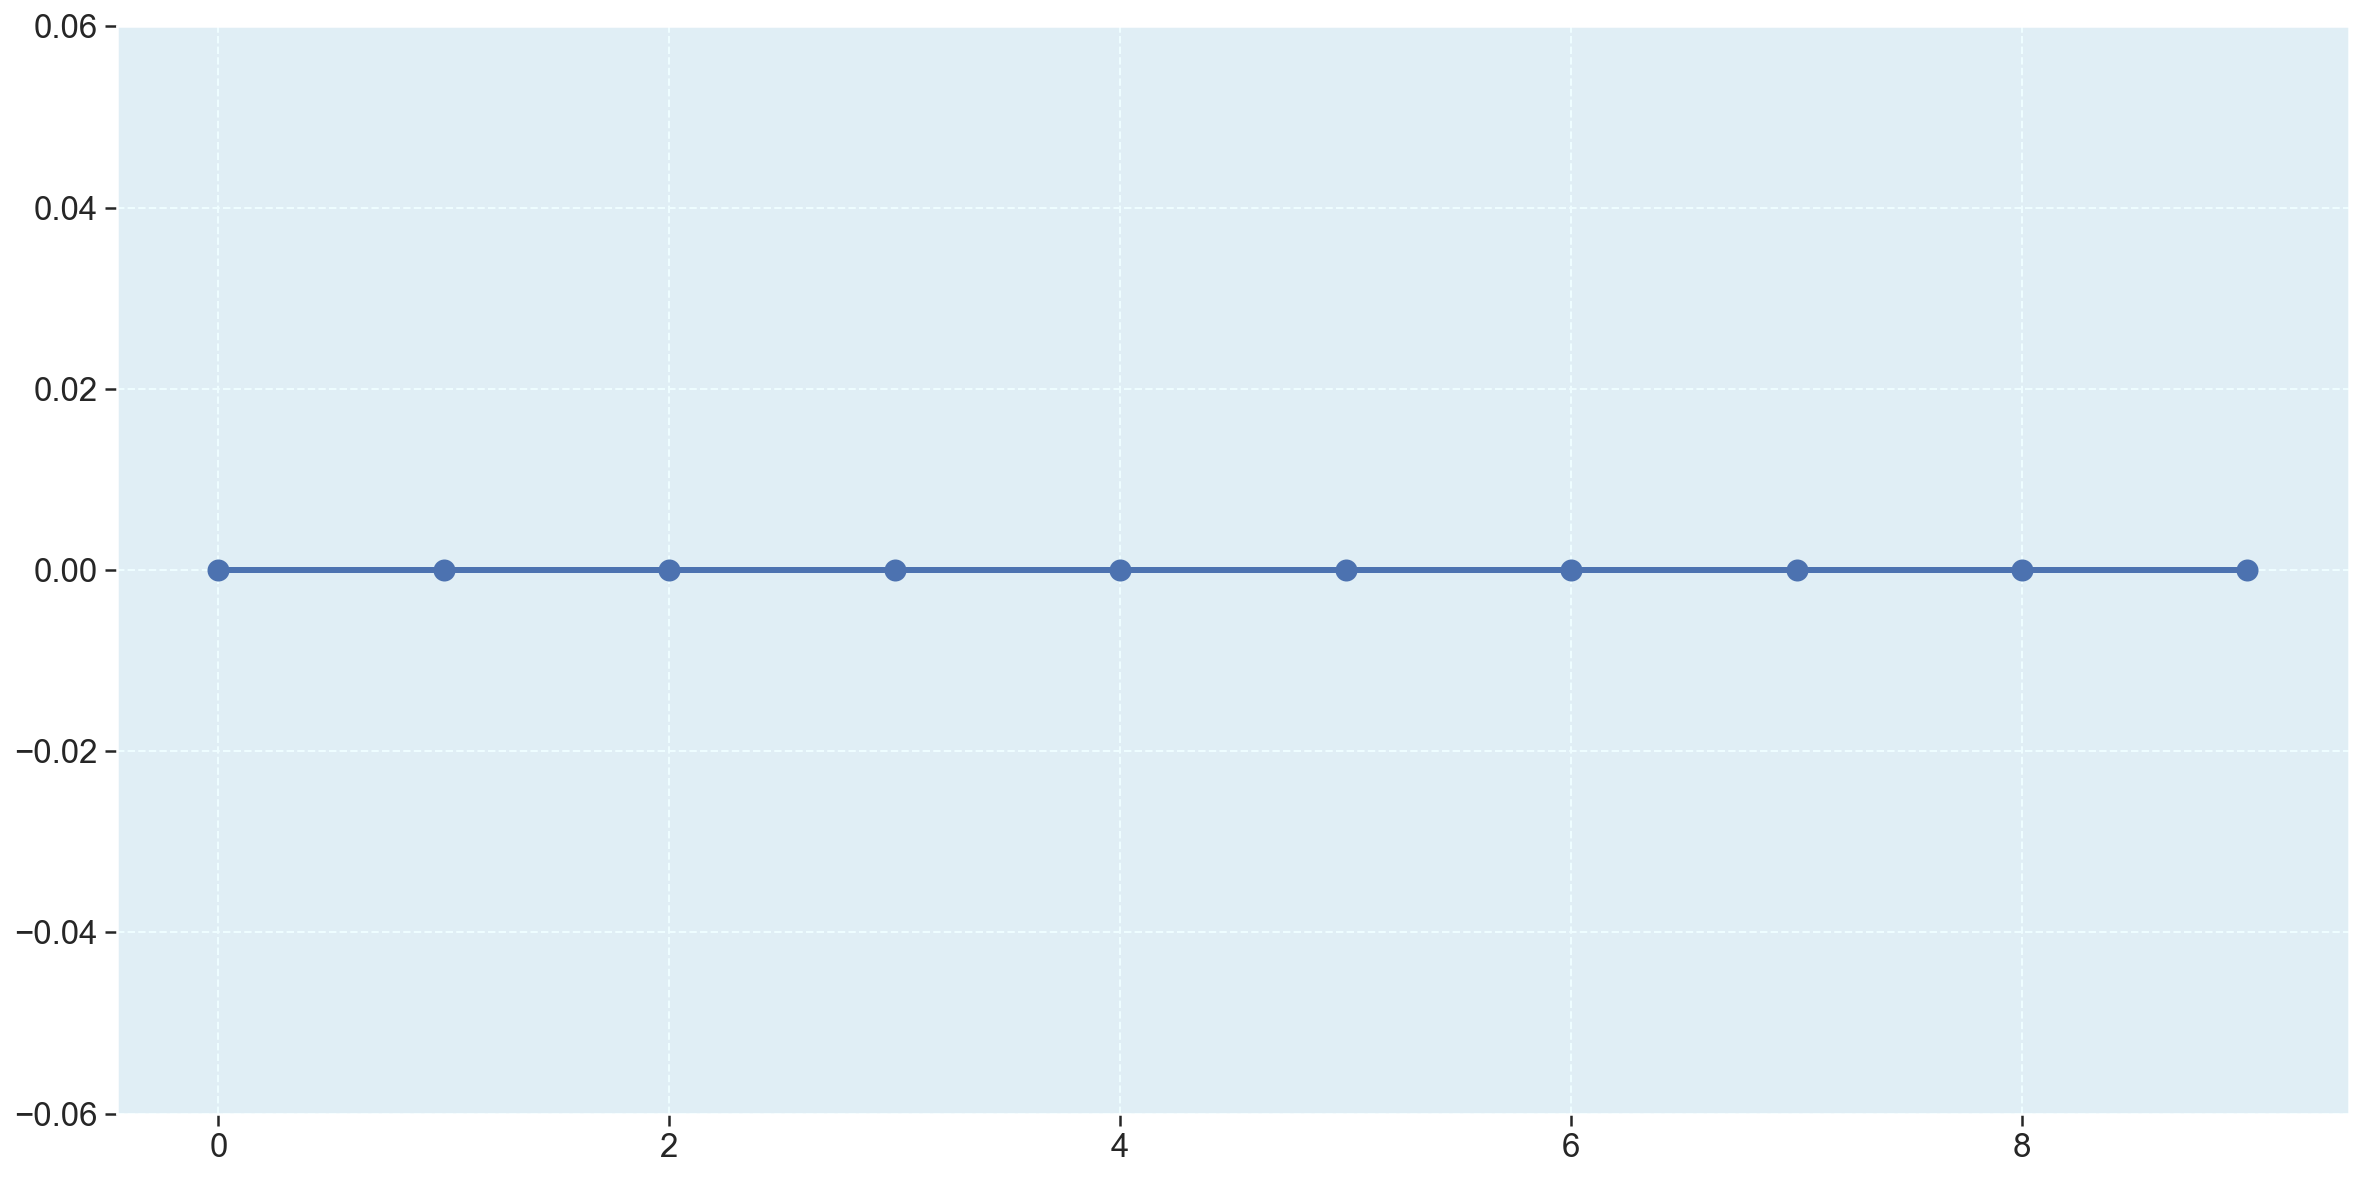

In [28]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['m2'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.06,.06, color="#c9f9ff", alpha=0.3)

plt.ylim(-.06,.06)

### m3

(0.98, 1.02)

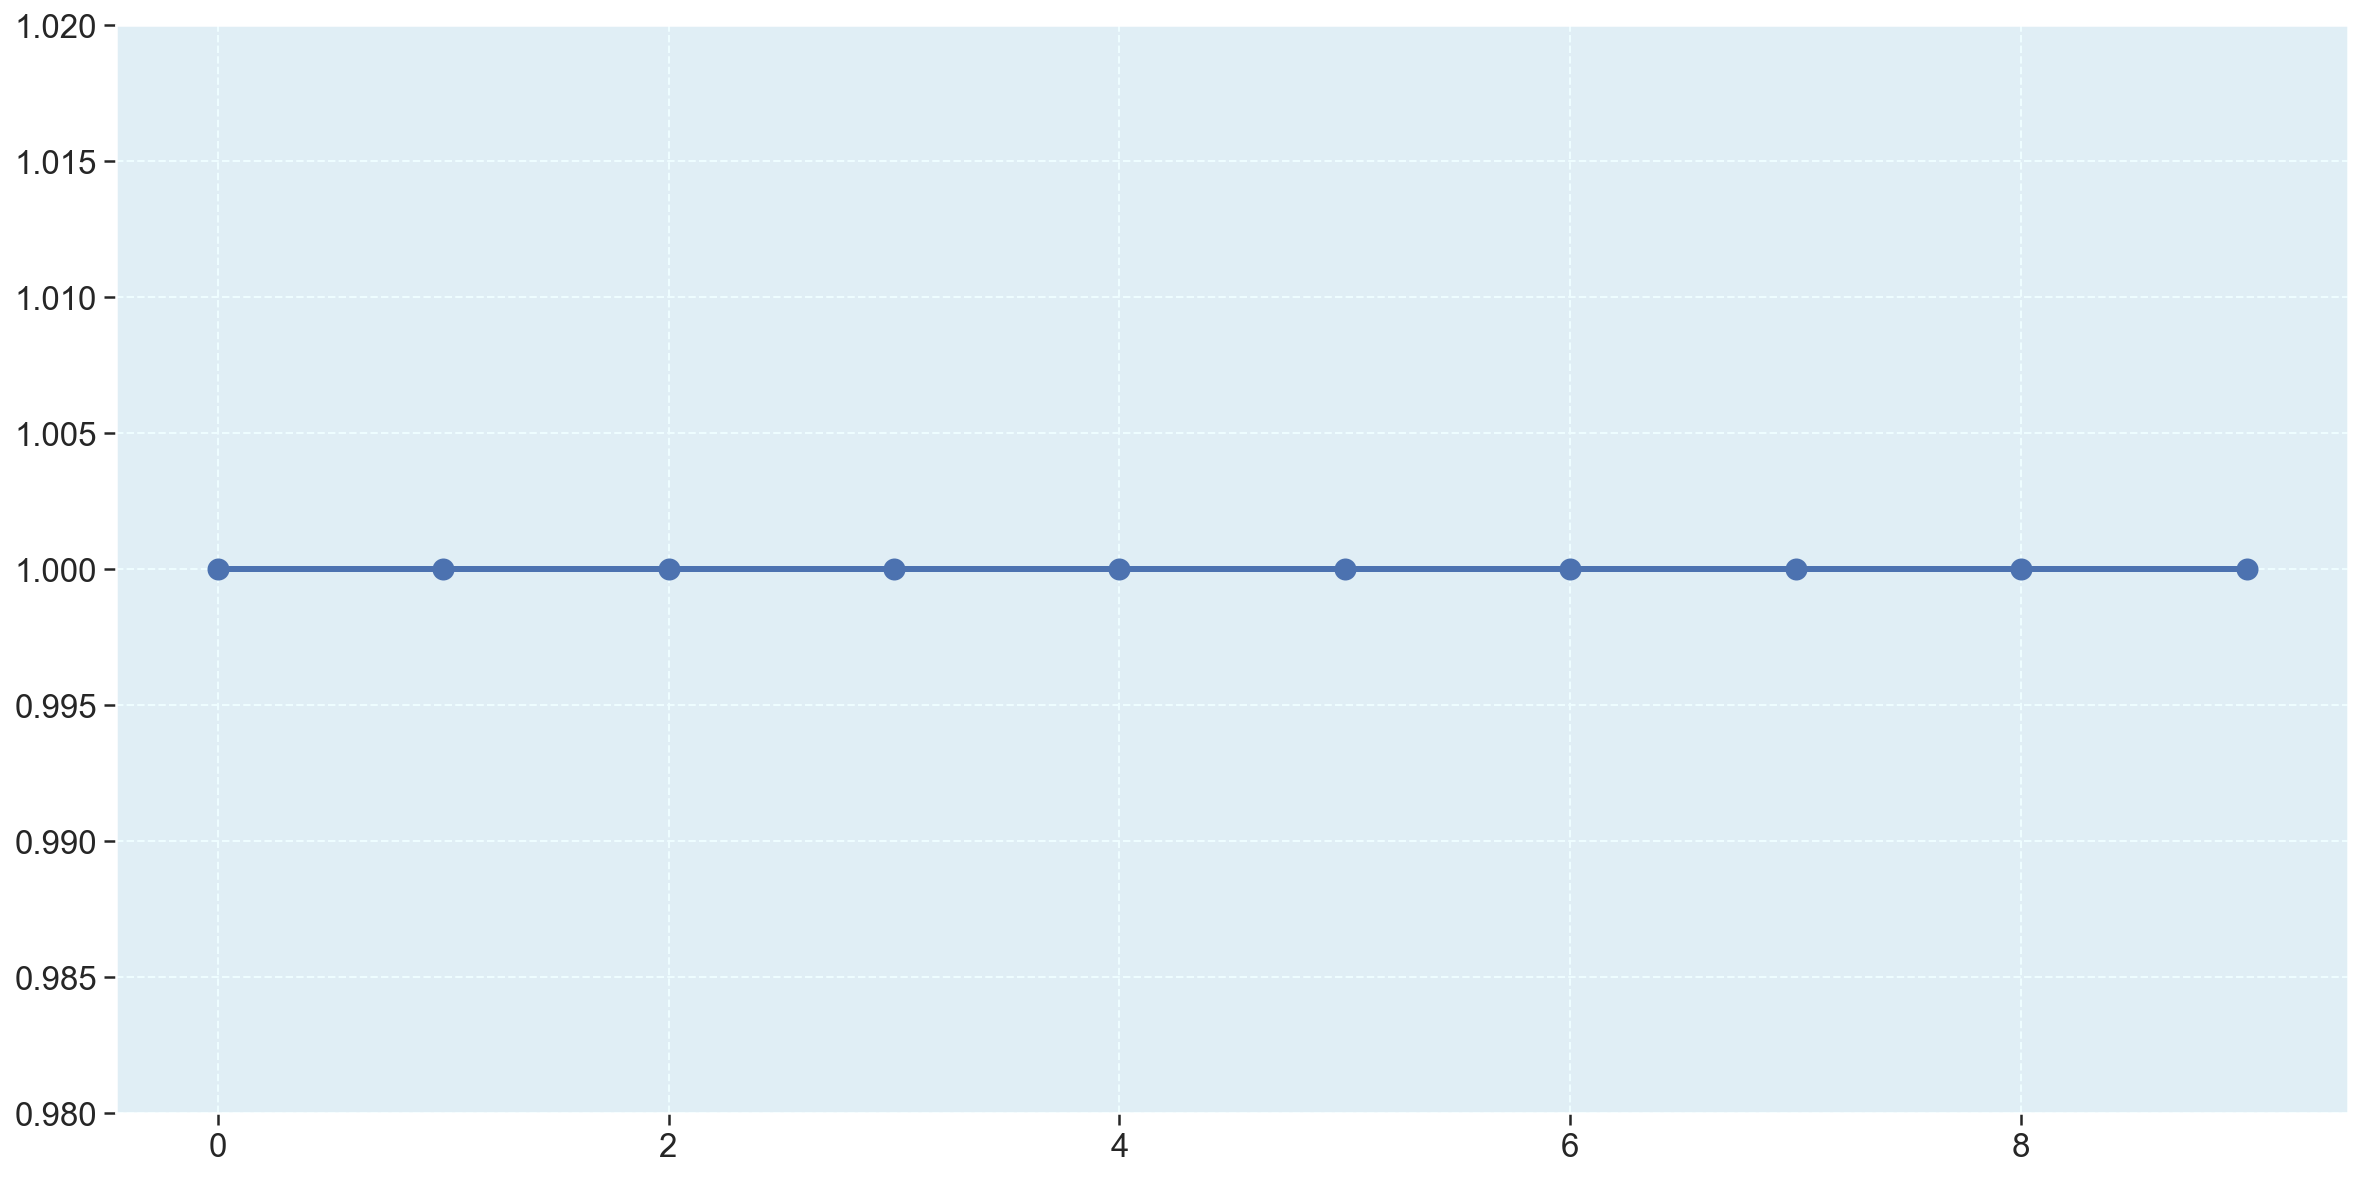

In [29]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.98,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(.98,1.02)

#### All metrics

(-0.02, 1.02)

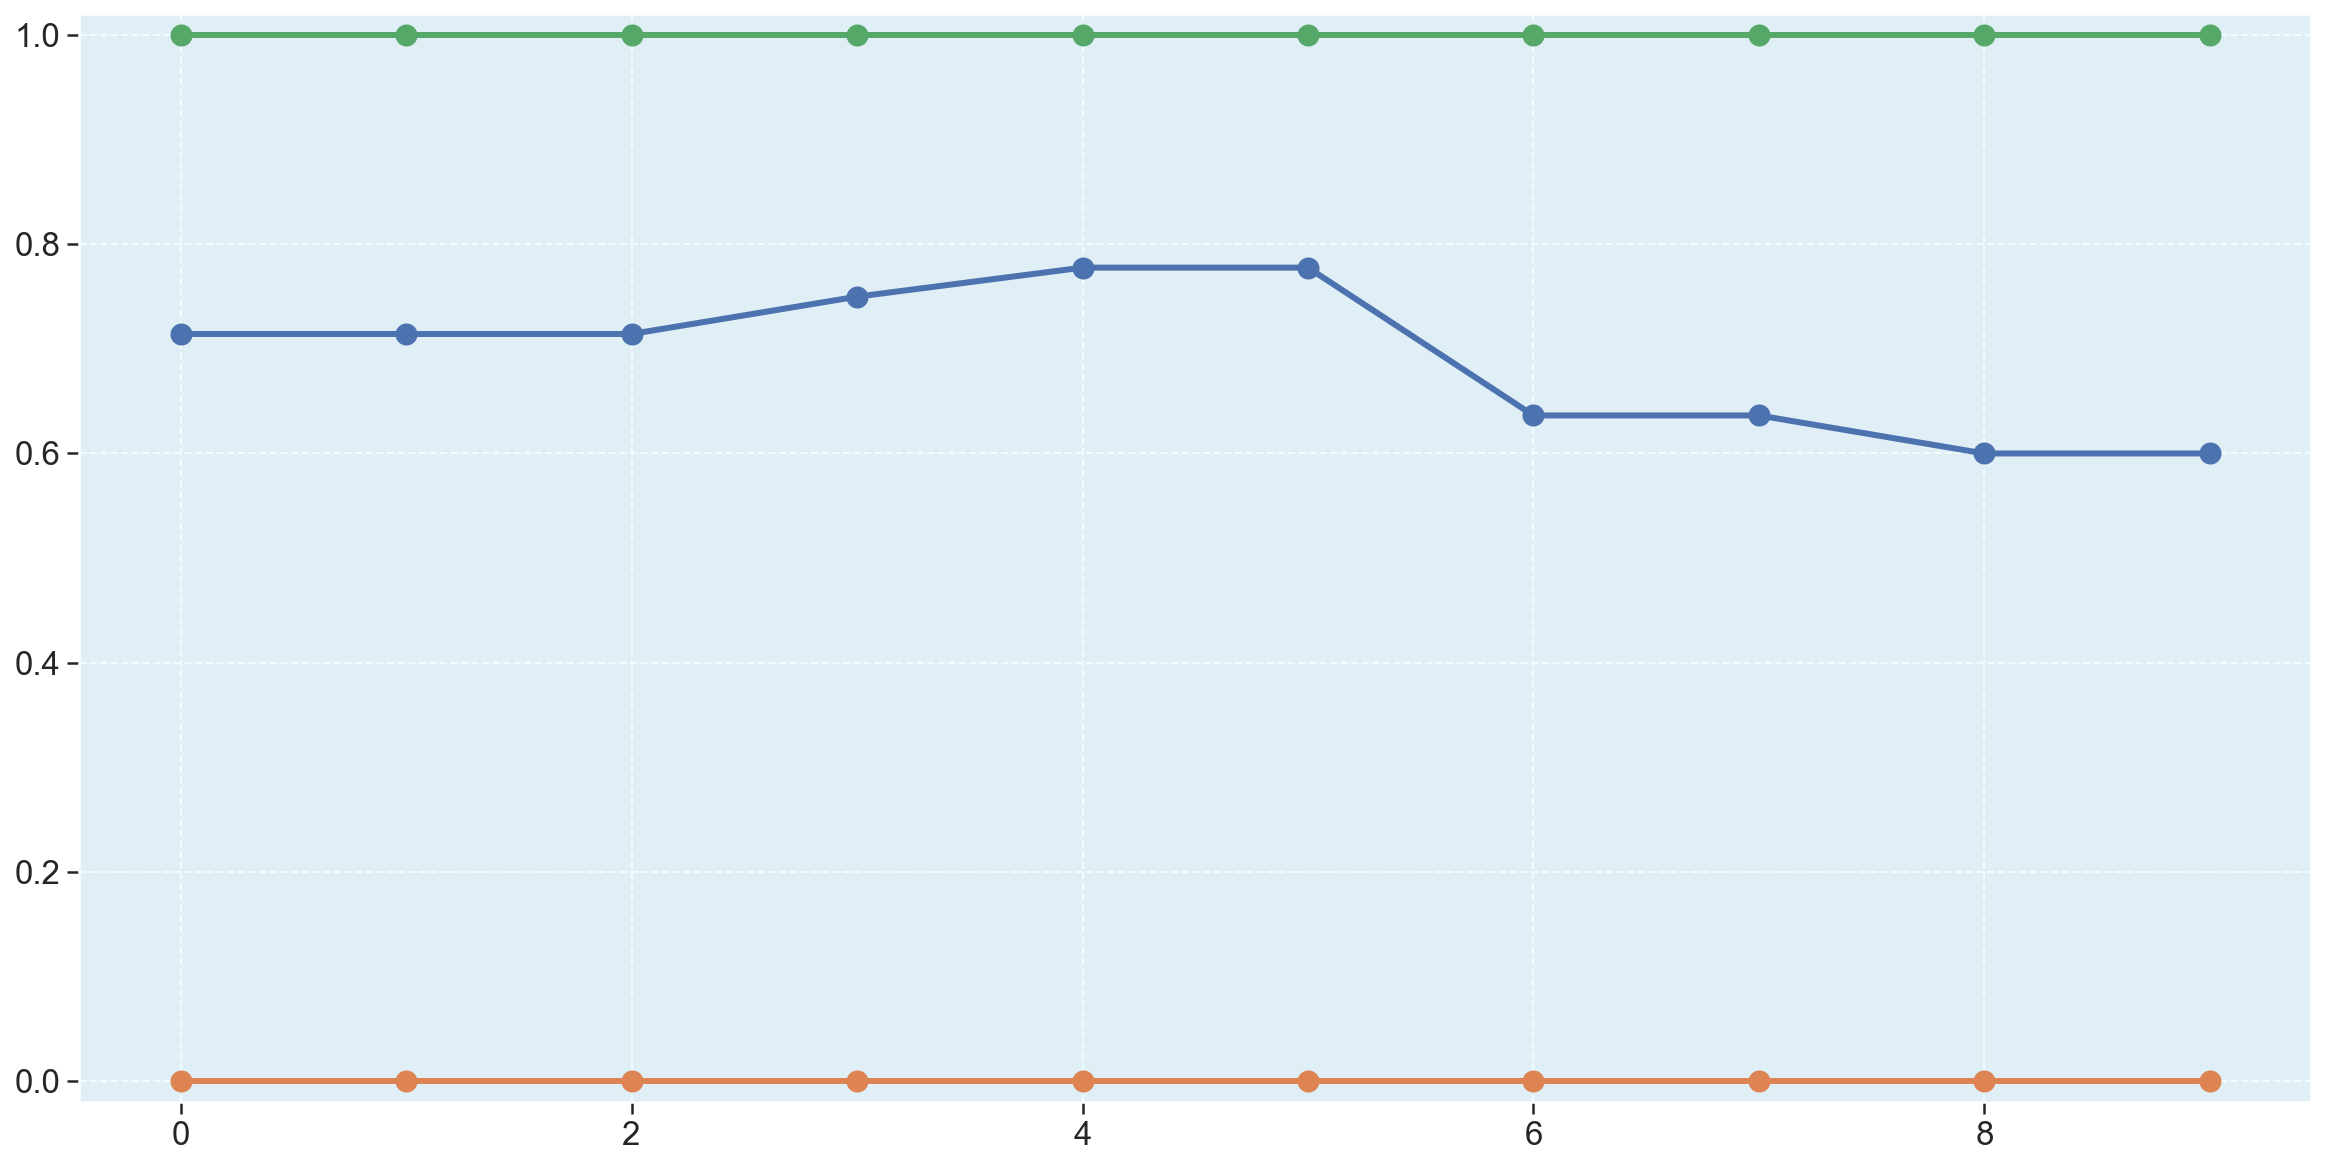

In [30]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(users_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(users_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

## Repository: Sectors

### m1

(0.6, 0.8)

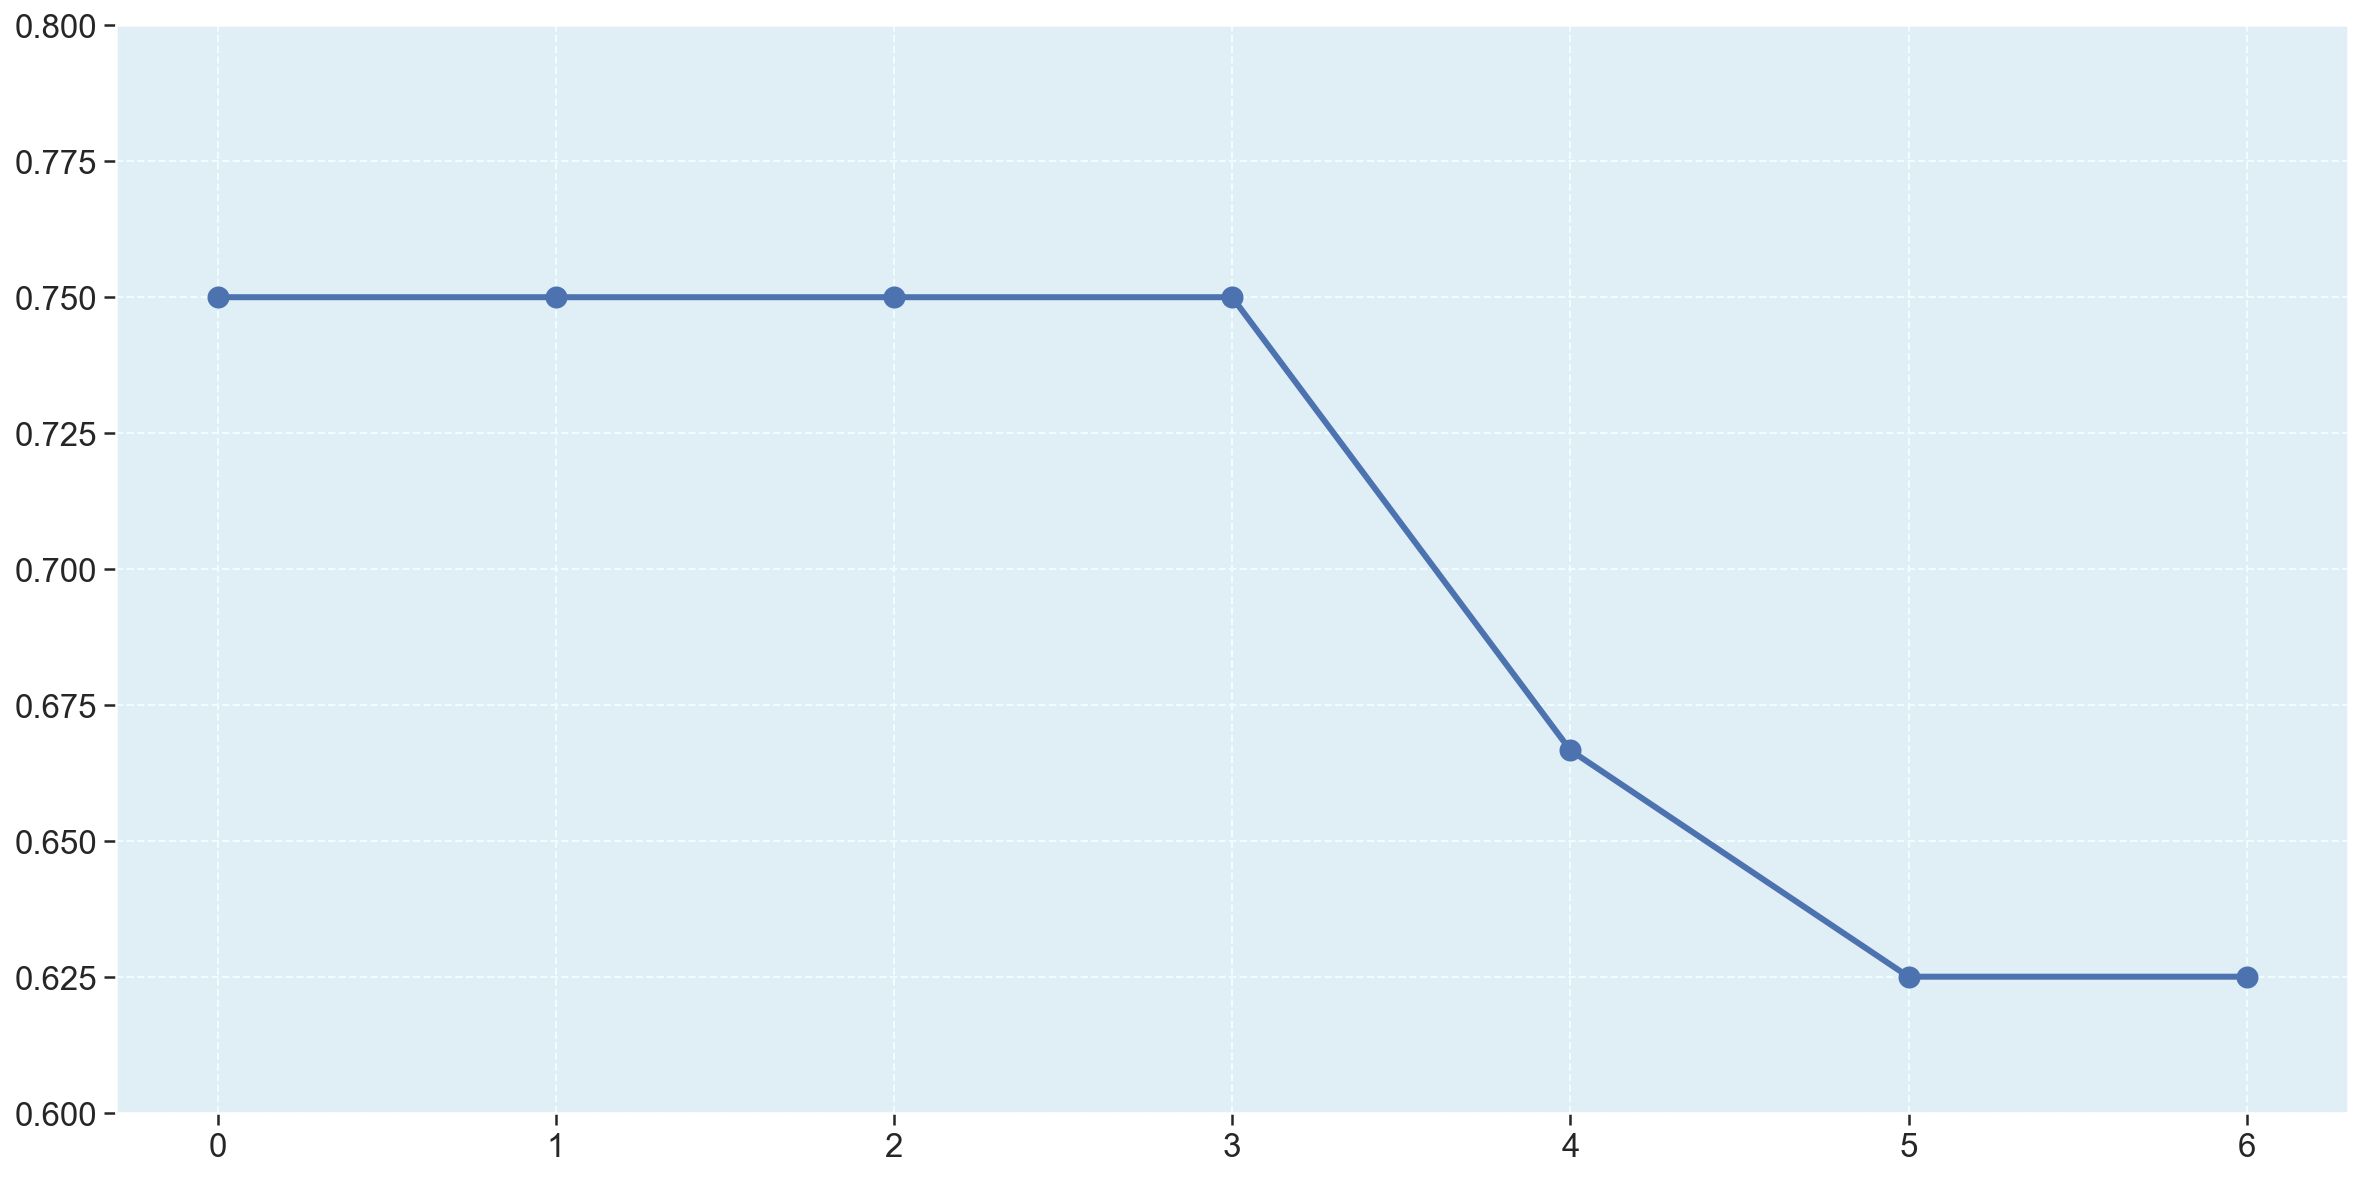

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['m1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.6,.8, color="#c9f9ff", alpha=0.3)

plt.ylim(.6,.8)

### m2

(-0.06, 0.06)

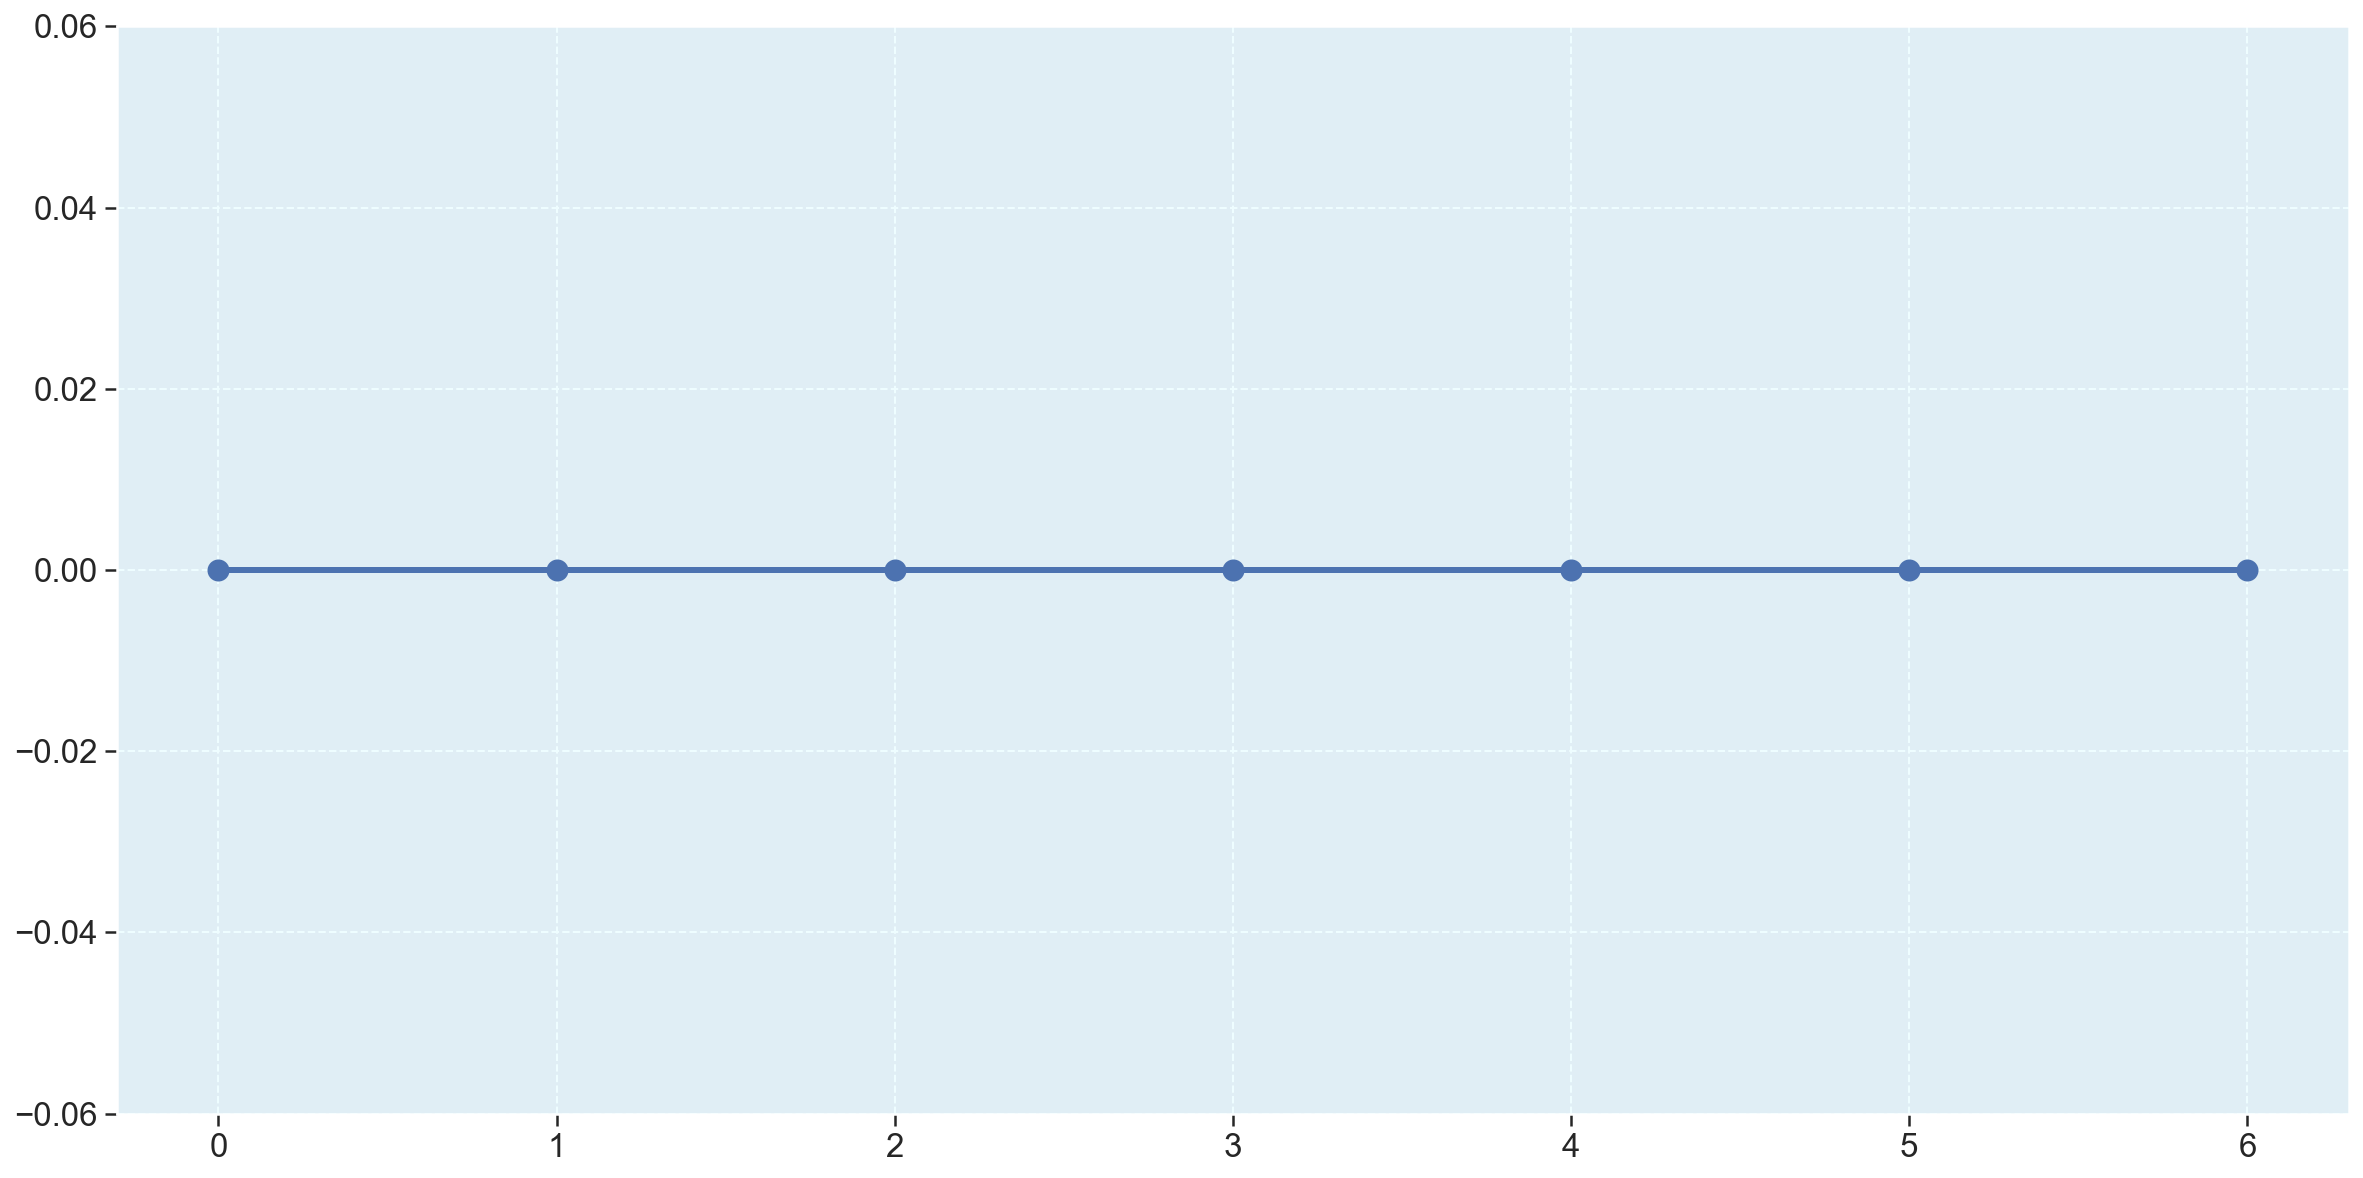

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['m2'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.06,.06, color="#c9f9ff", alpha=0.3)

plt.ylim(-.06,.06)

### m3

(0.7, 1.02)

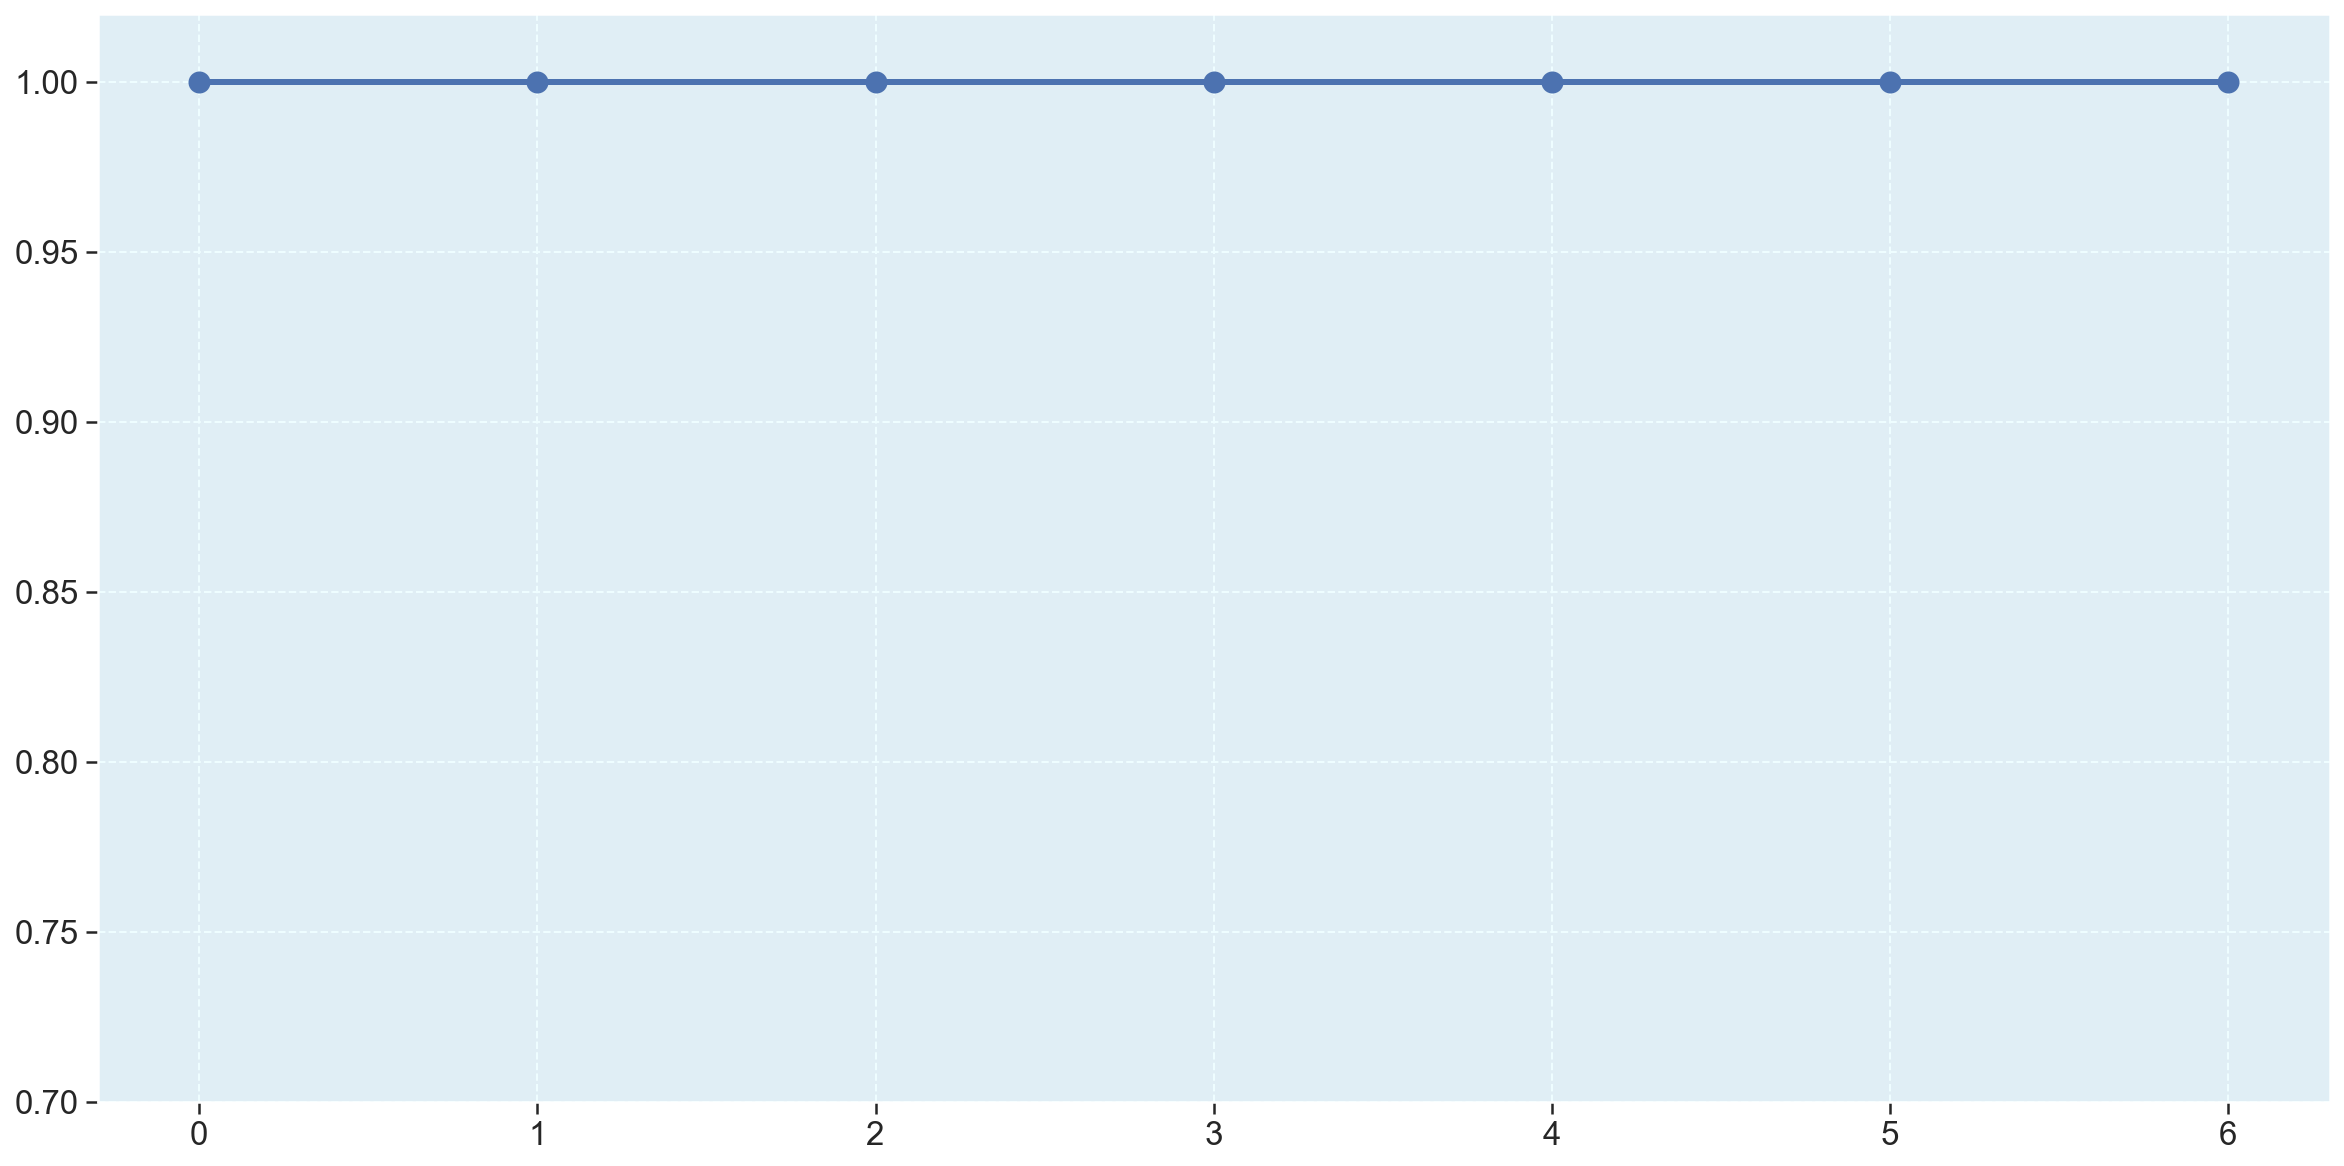

In [33]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.7,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(.7,1.02)

#### All metrics

(-0.02, 1.02)

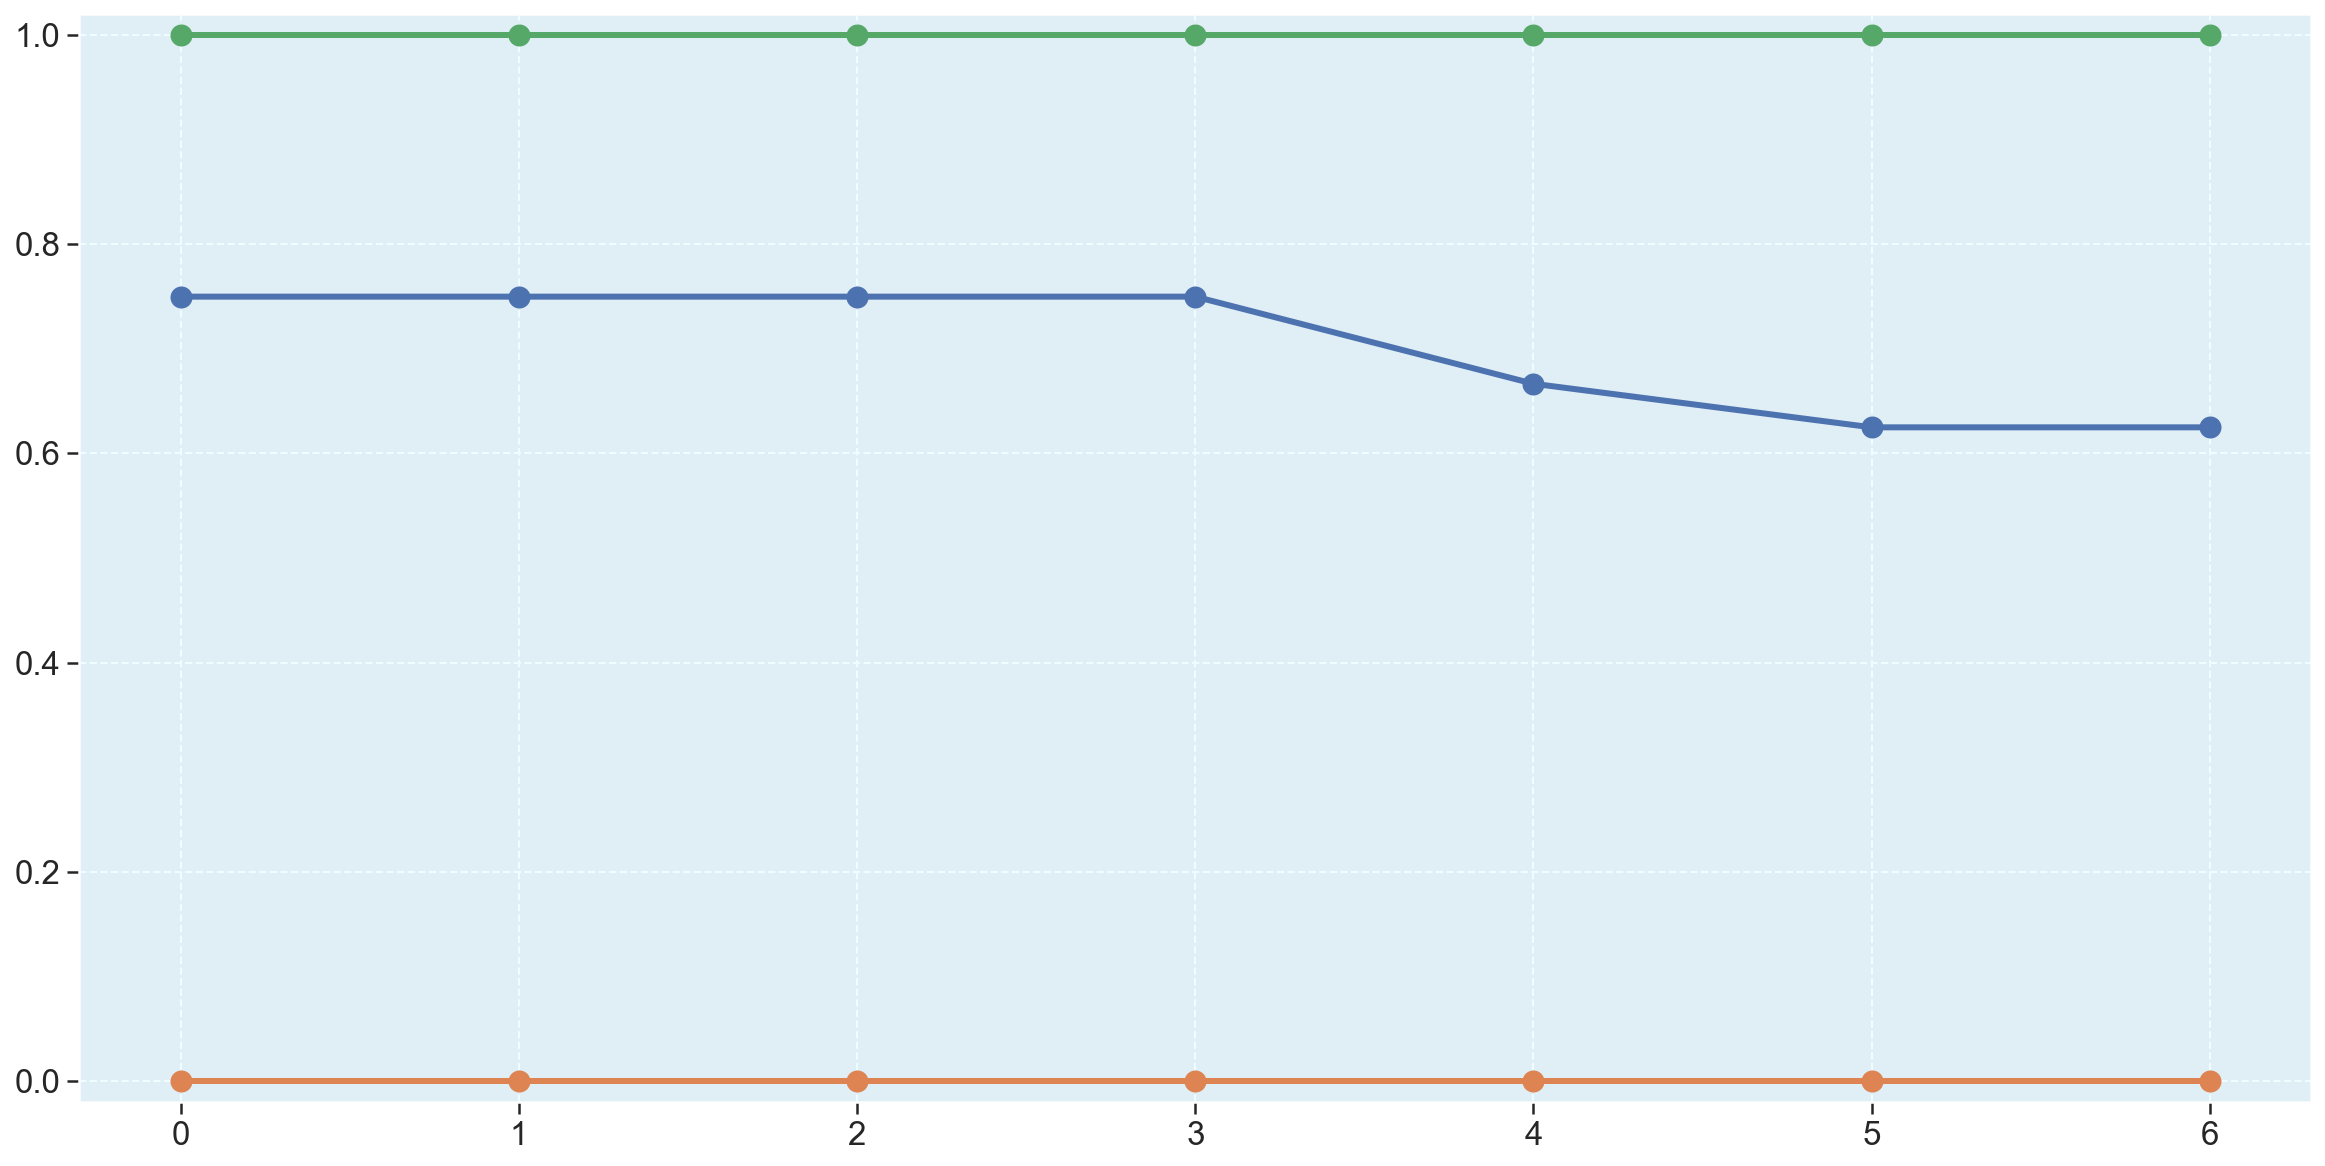

In [34]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(sectors_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(sectors_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

## Repository: Frontend

### m1

(0.625, 0.7)

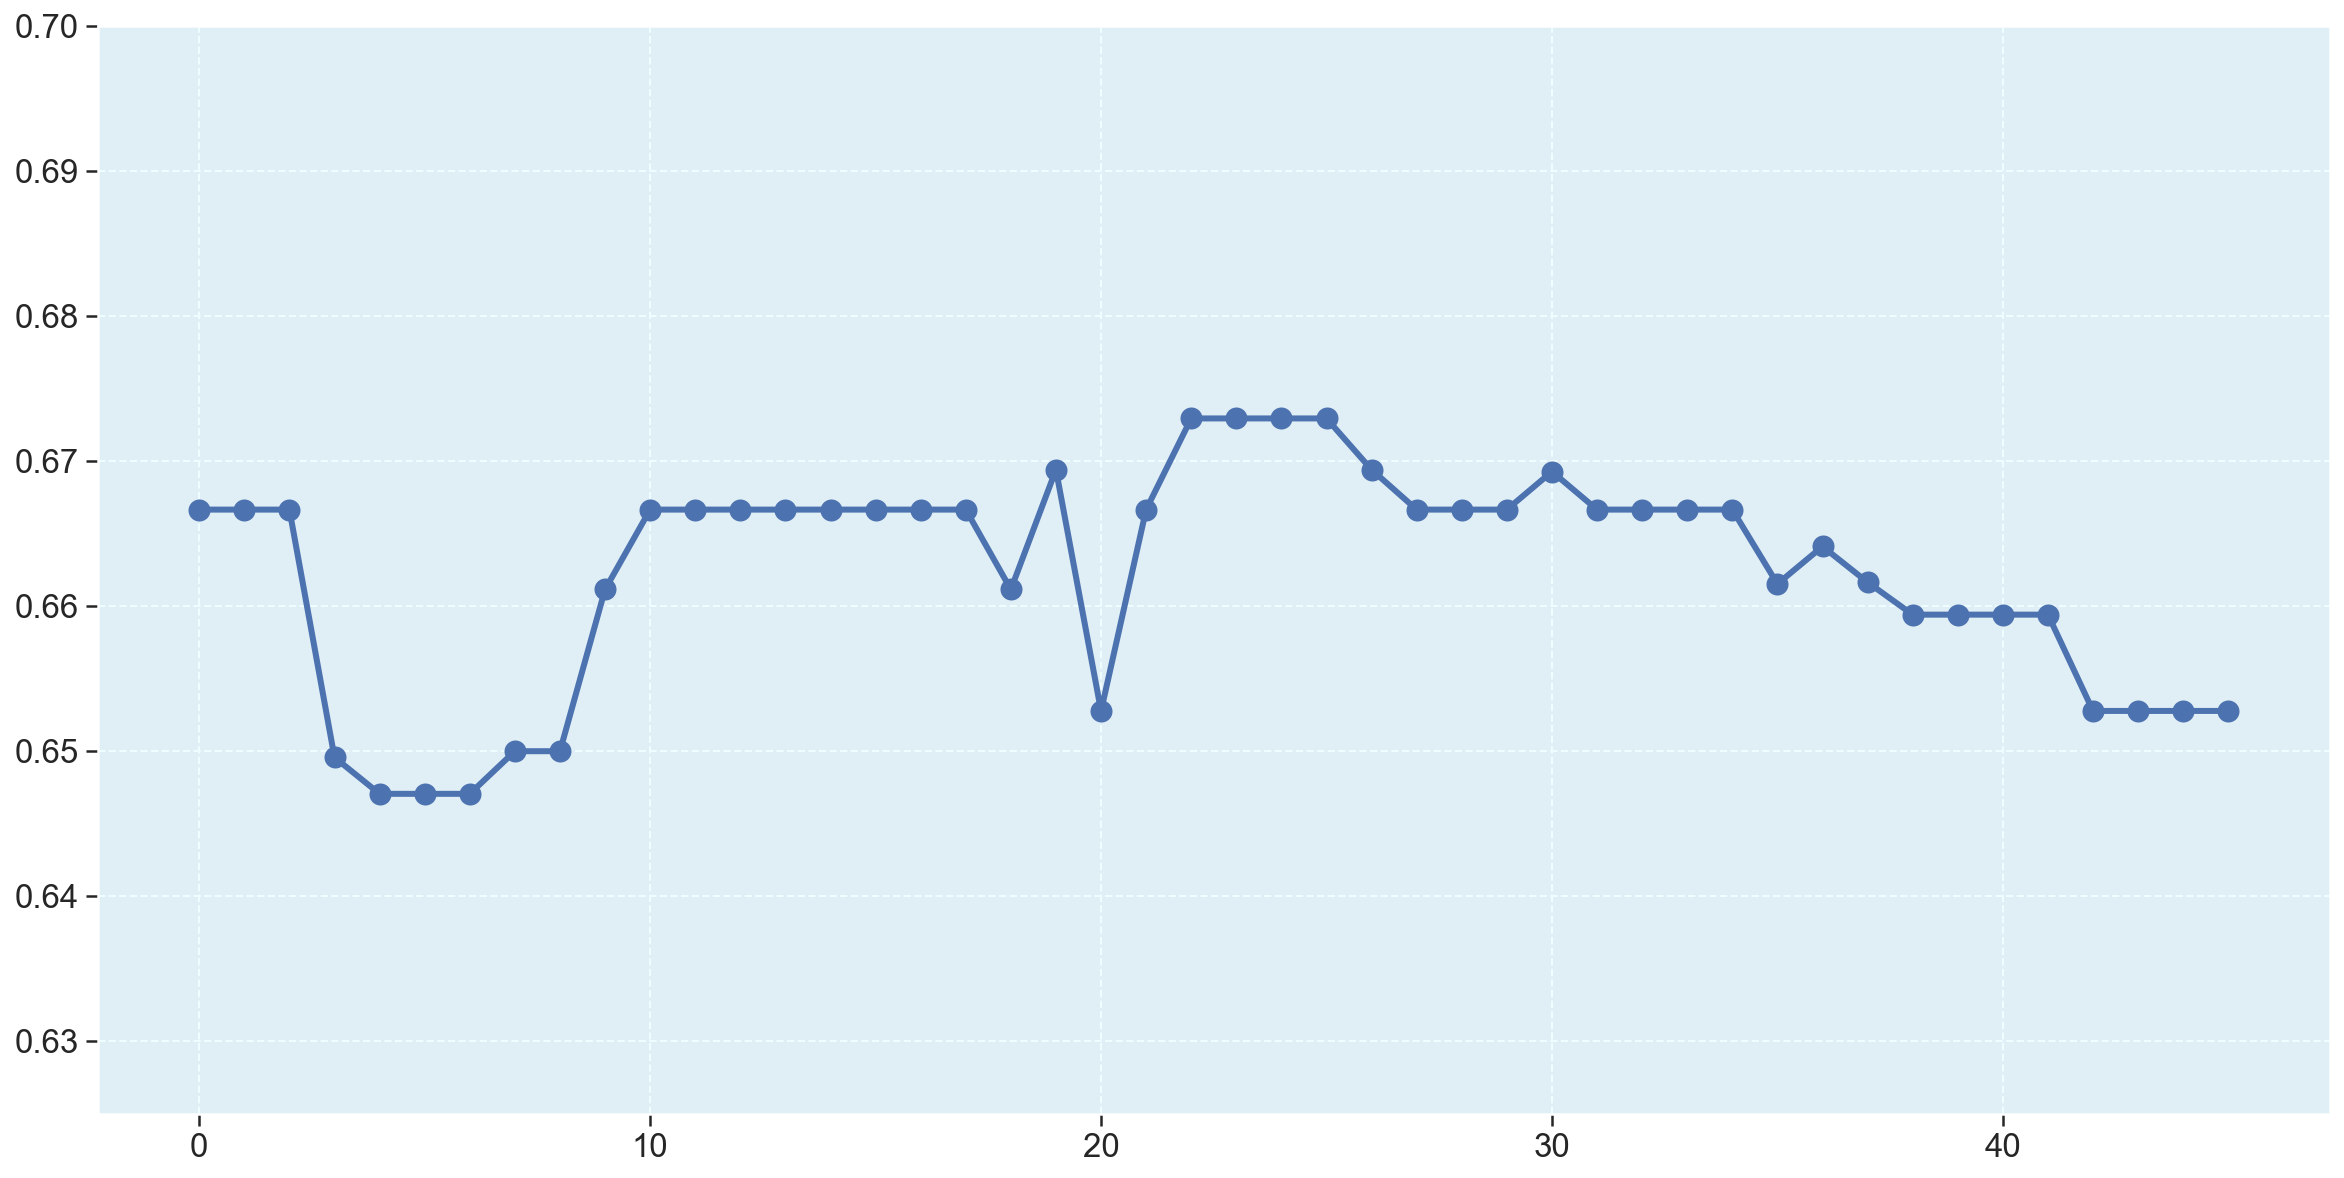

In [35]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.625,.7, color="#c9f9ff", alpha=0.3)

plt.ylim(.625,.7)

### m2

(-0.001, 0.016)

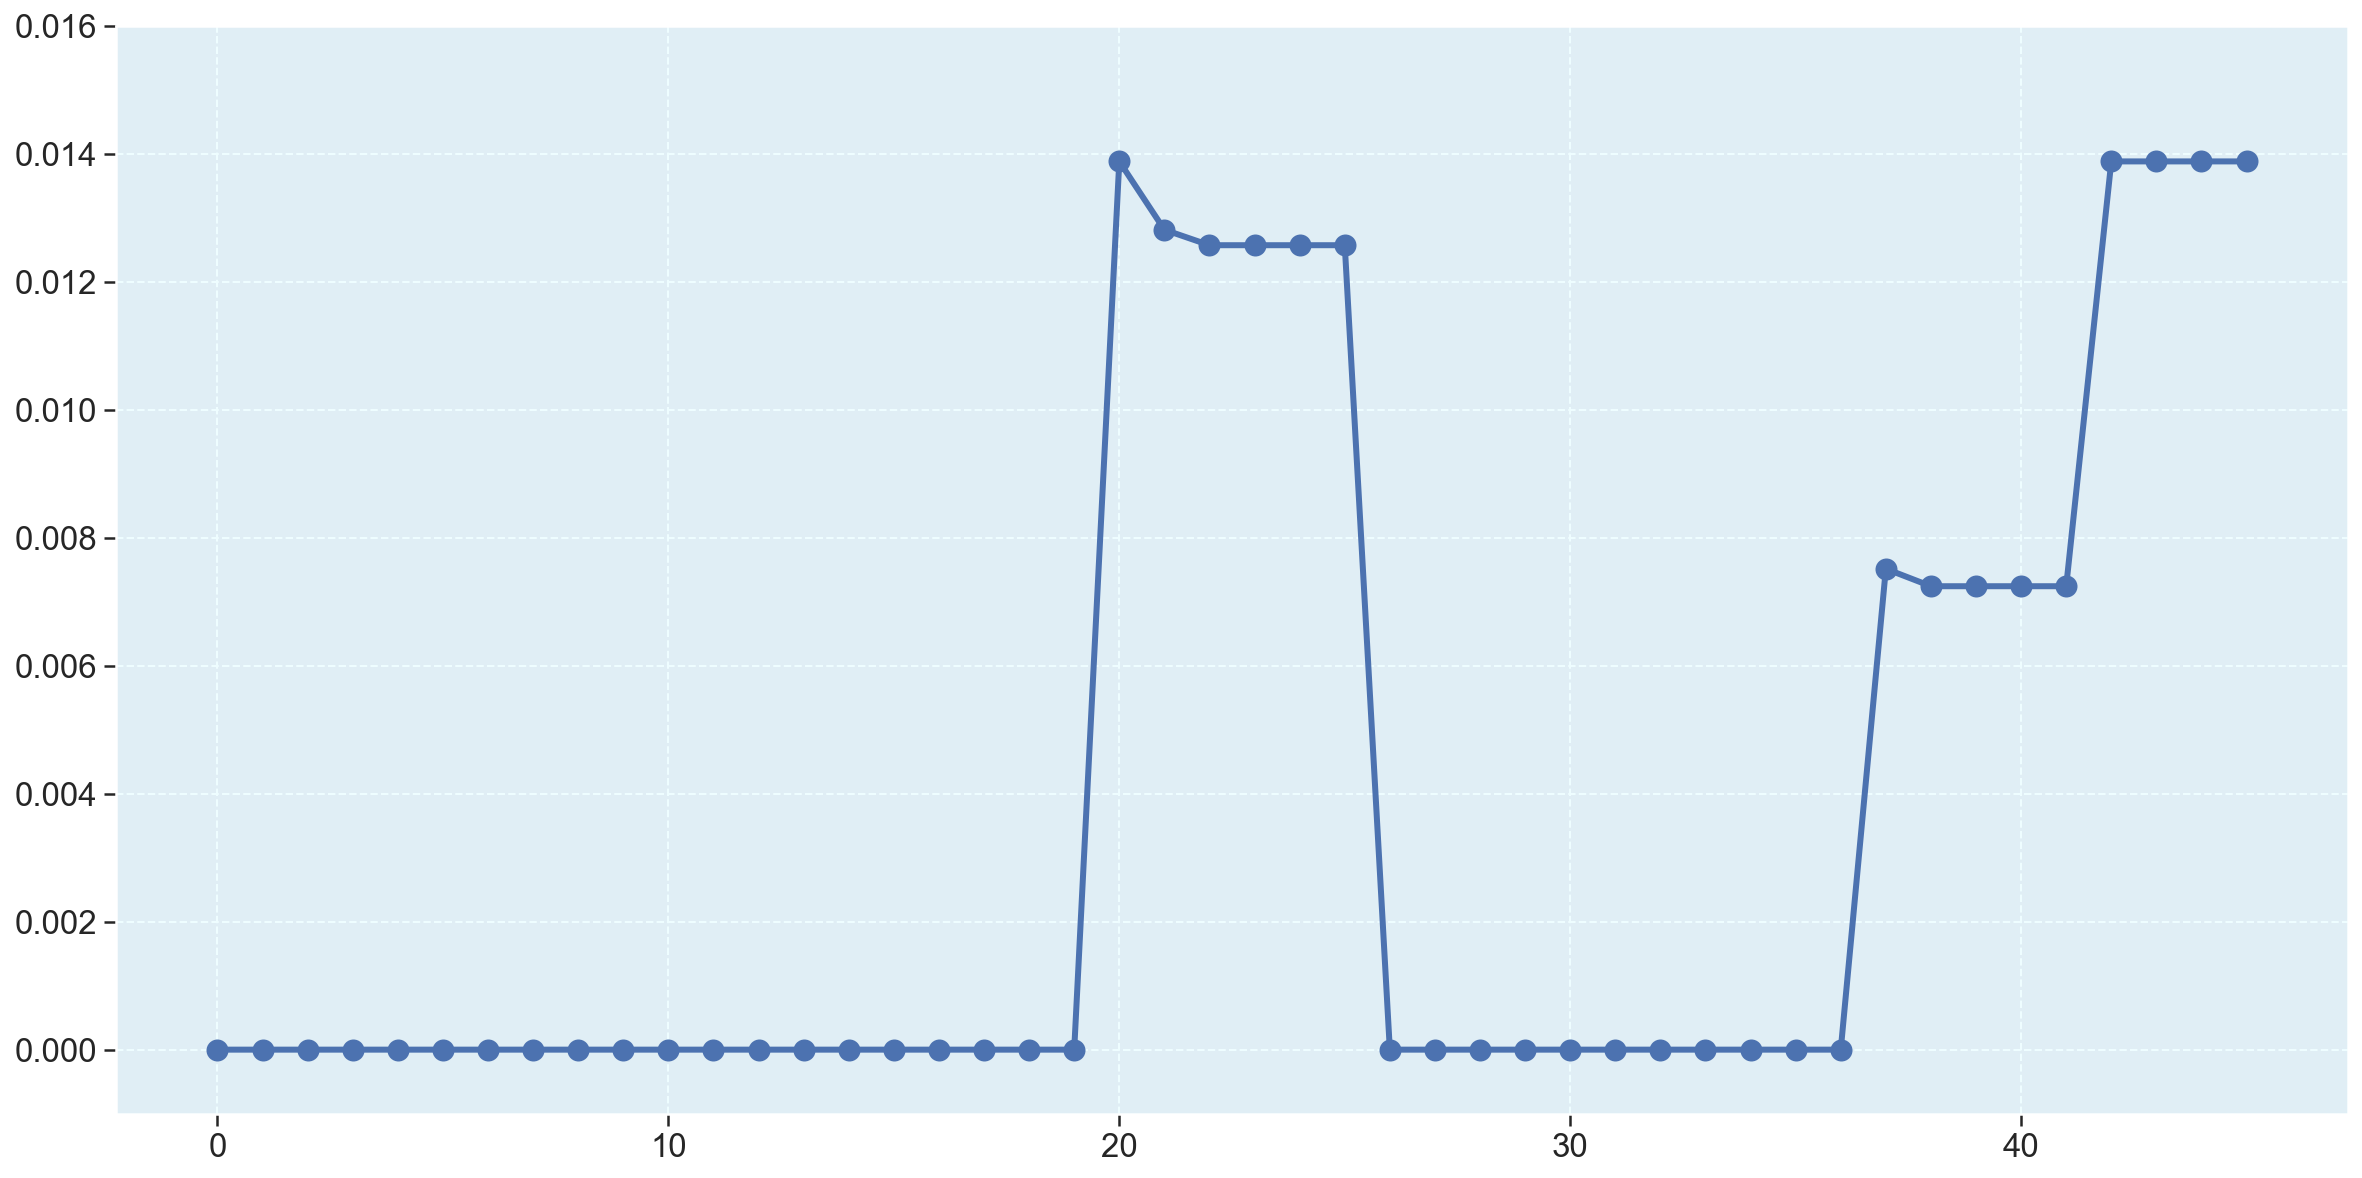

In [36]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.001,.016, color="#c9f9ff", alpha=0.3)

plt.ylim(-.001,.016)

### m3

(0.95, 1.01)

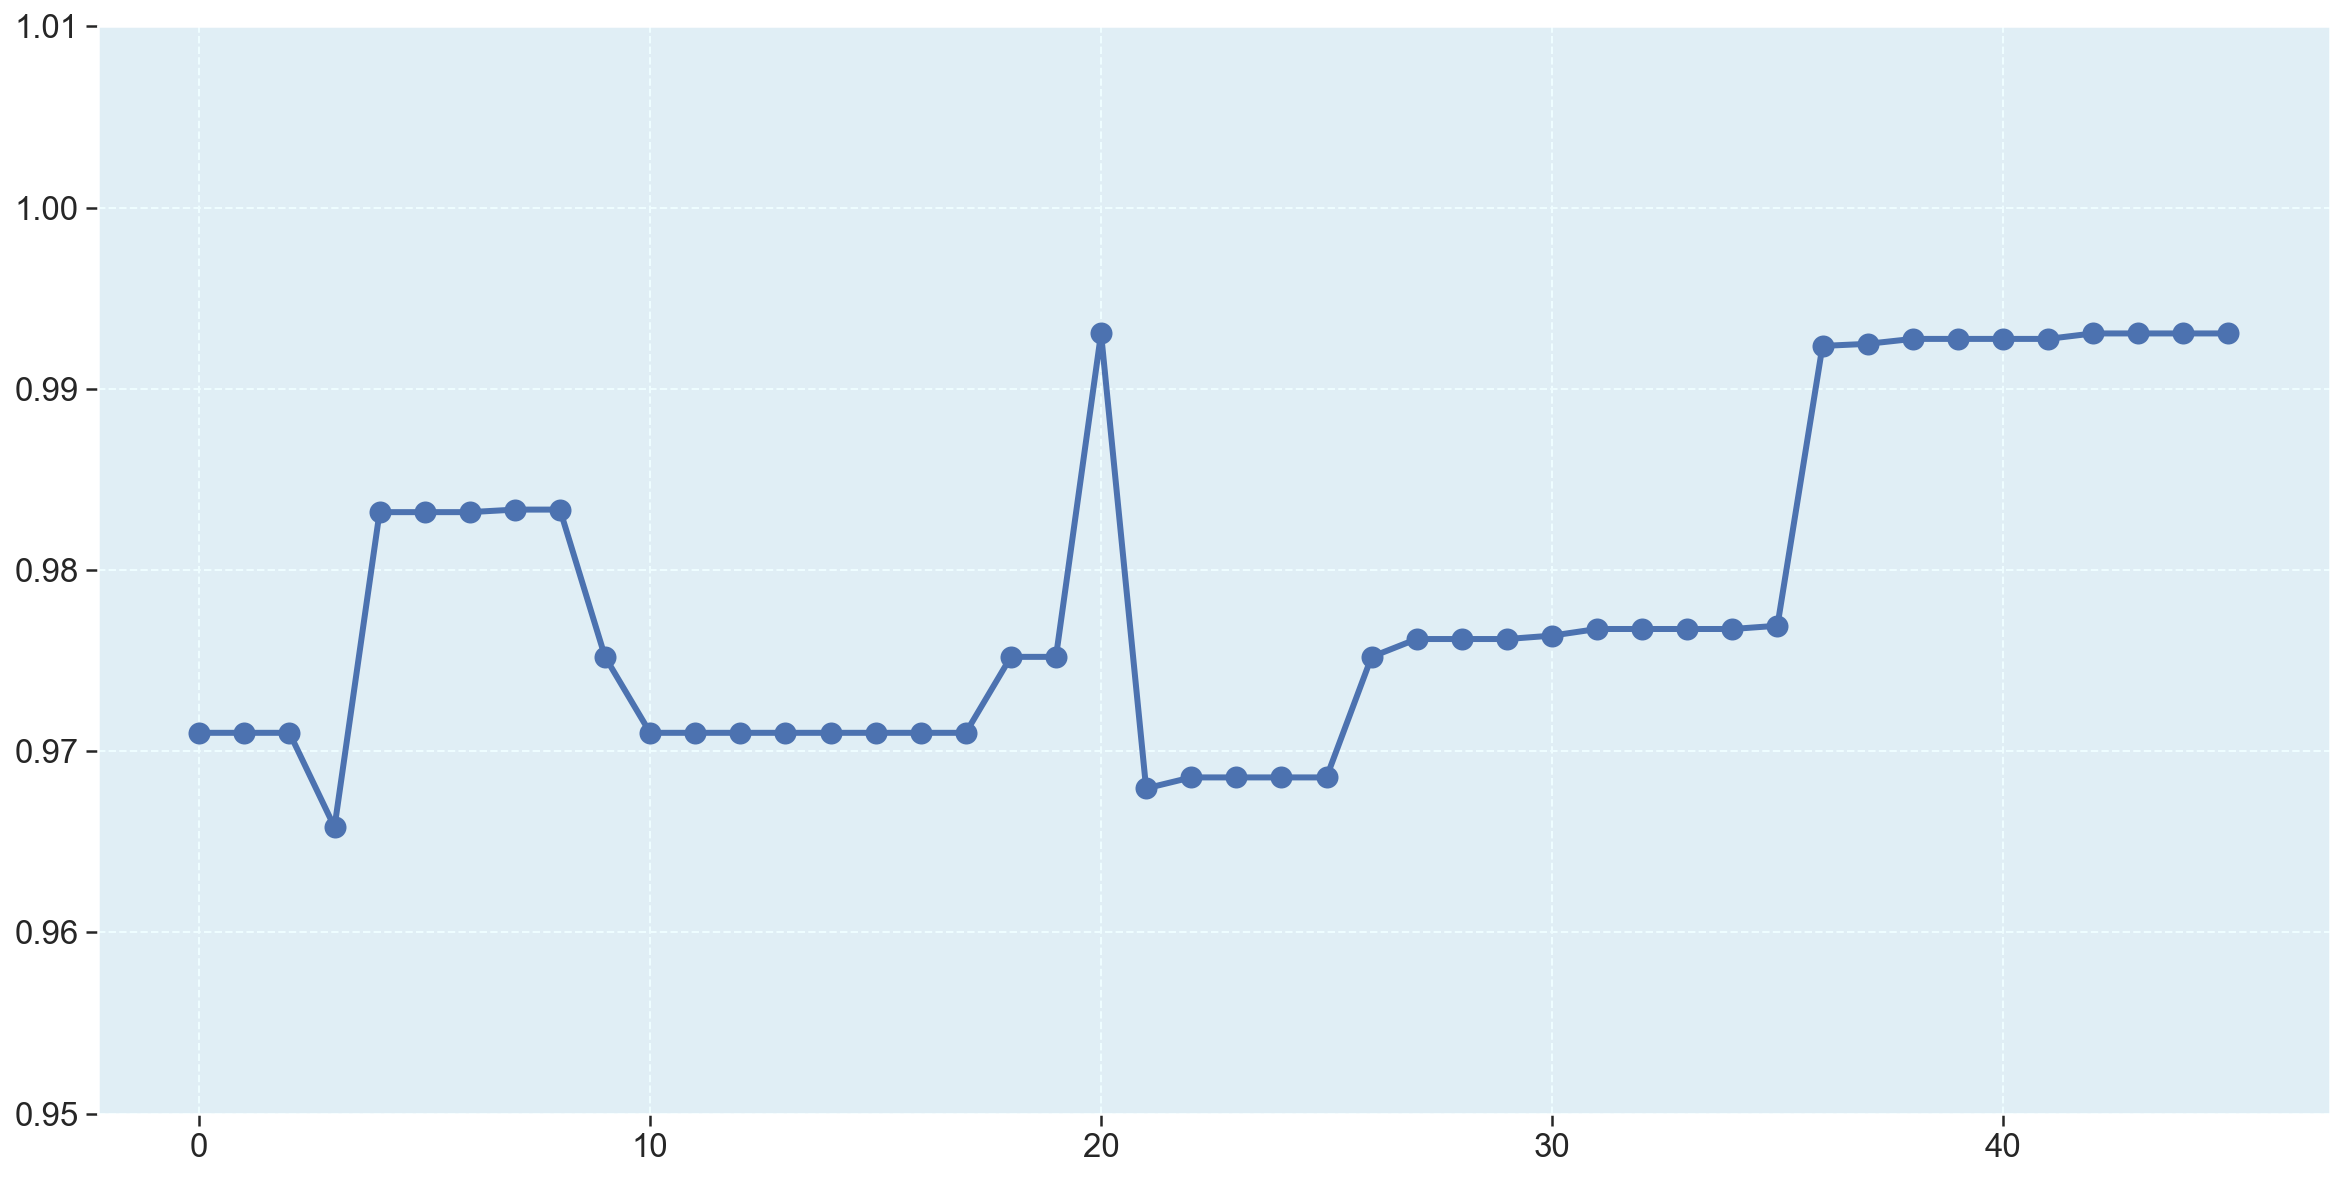

In [37]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.95,1.01, color="#c9f9ff", alpha=0.3)

plt.ylim(.95,1.01)

#### All metrics

(-0.02, 1.02)

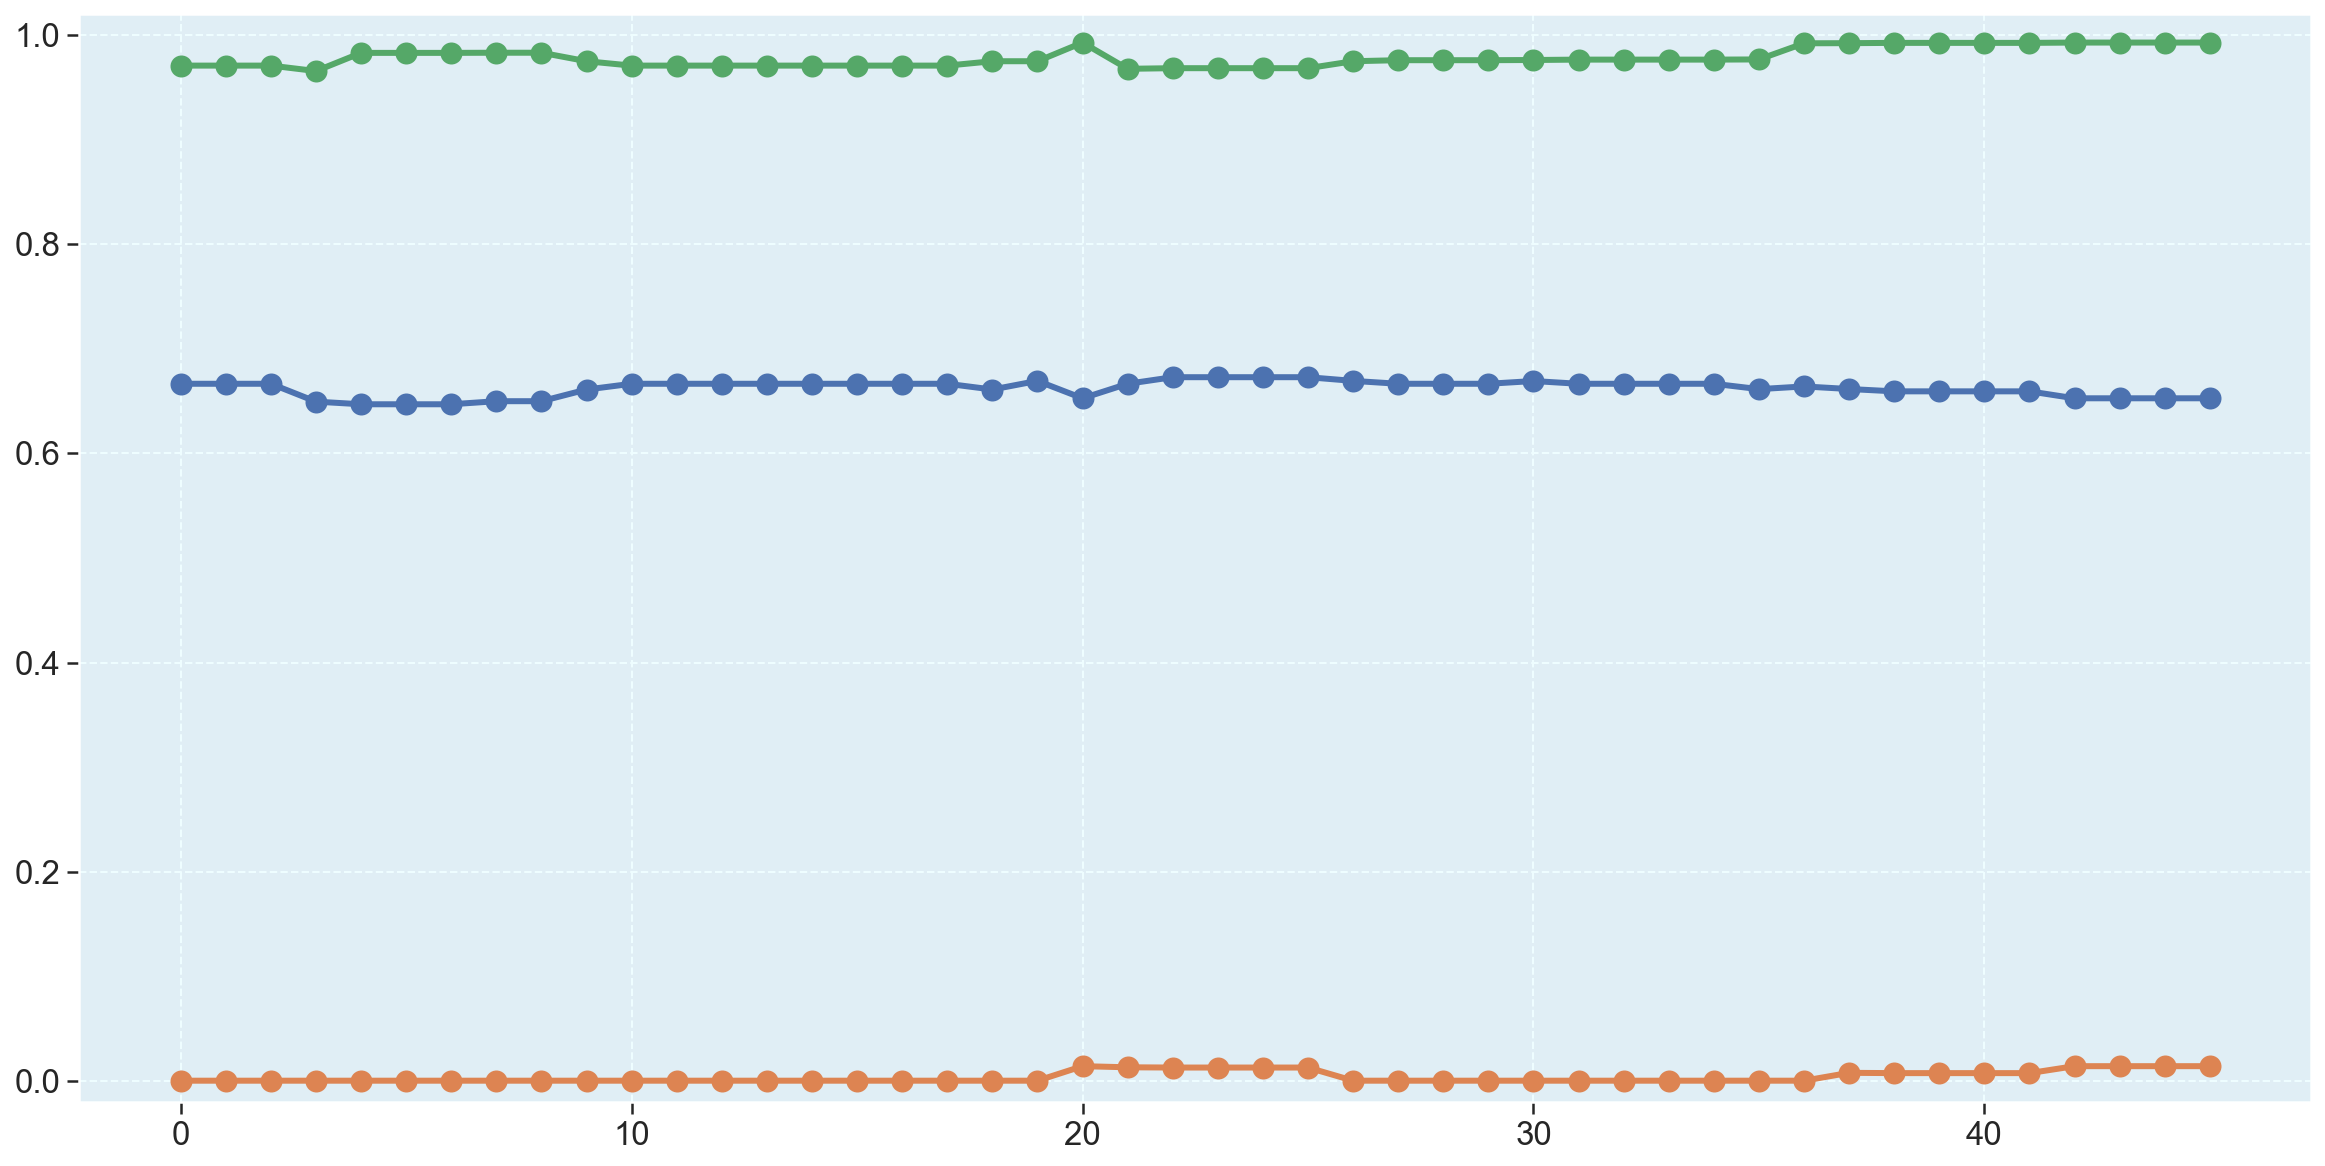

In [38]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

## Repository: Demands

### m1

(0.55, 0.75)

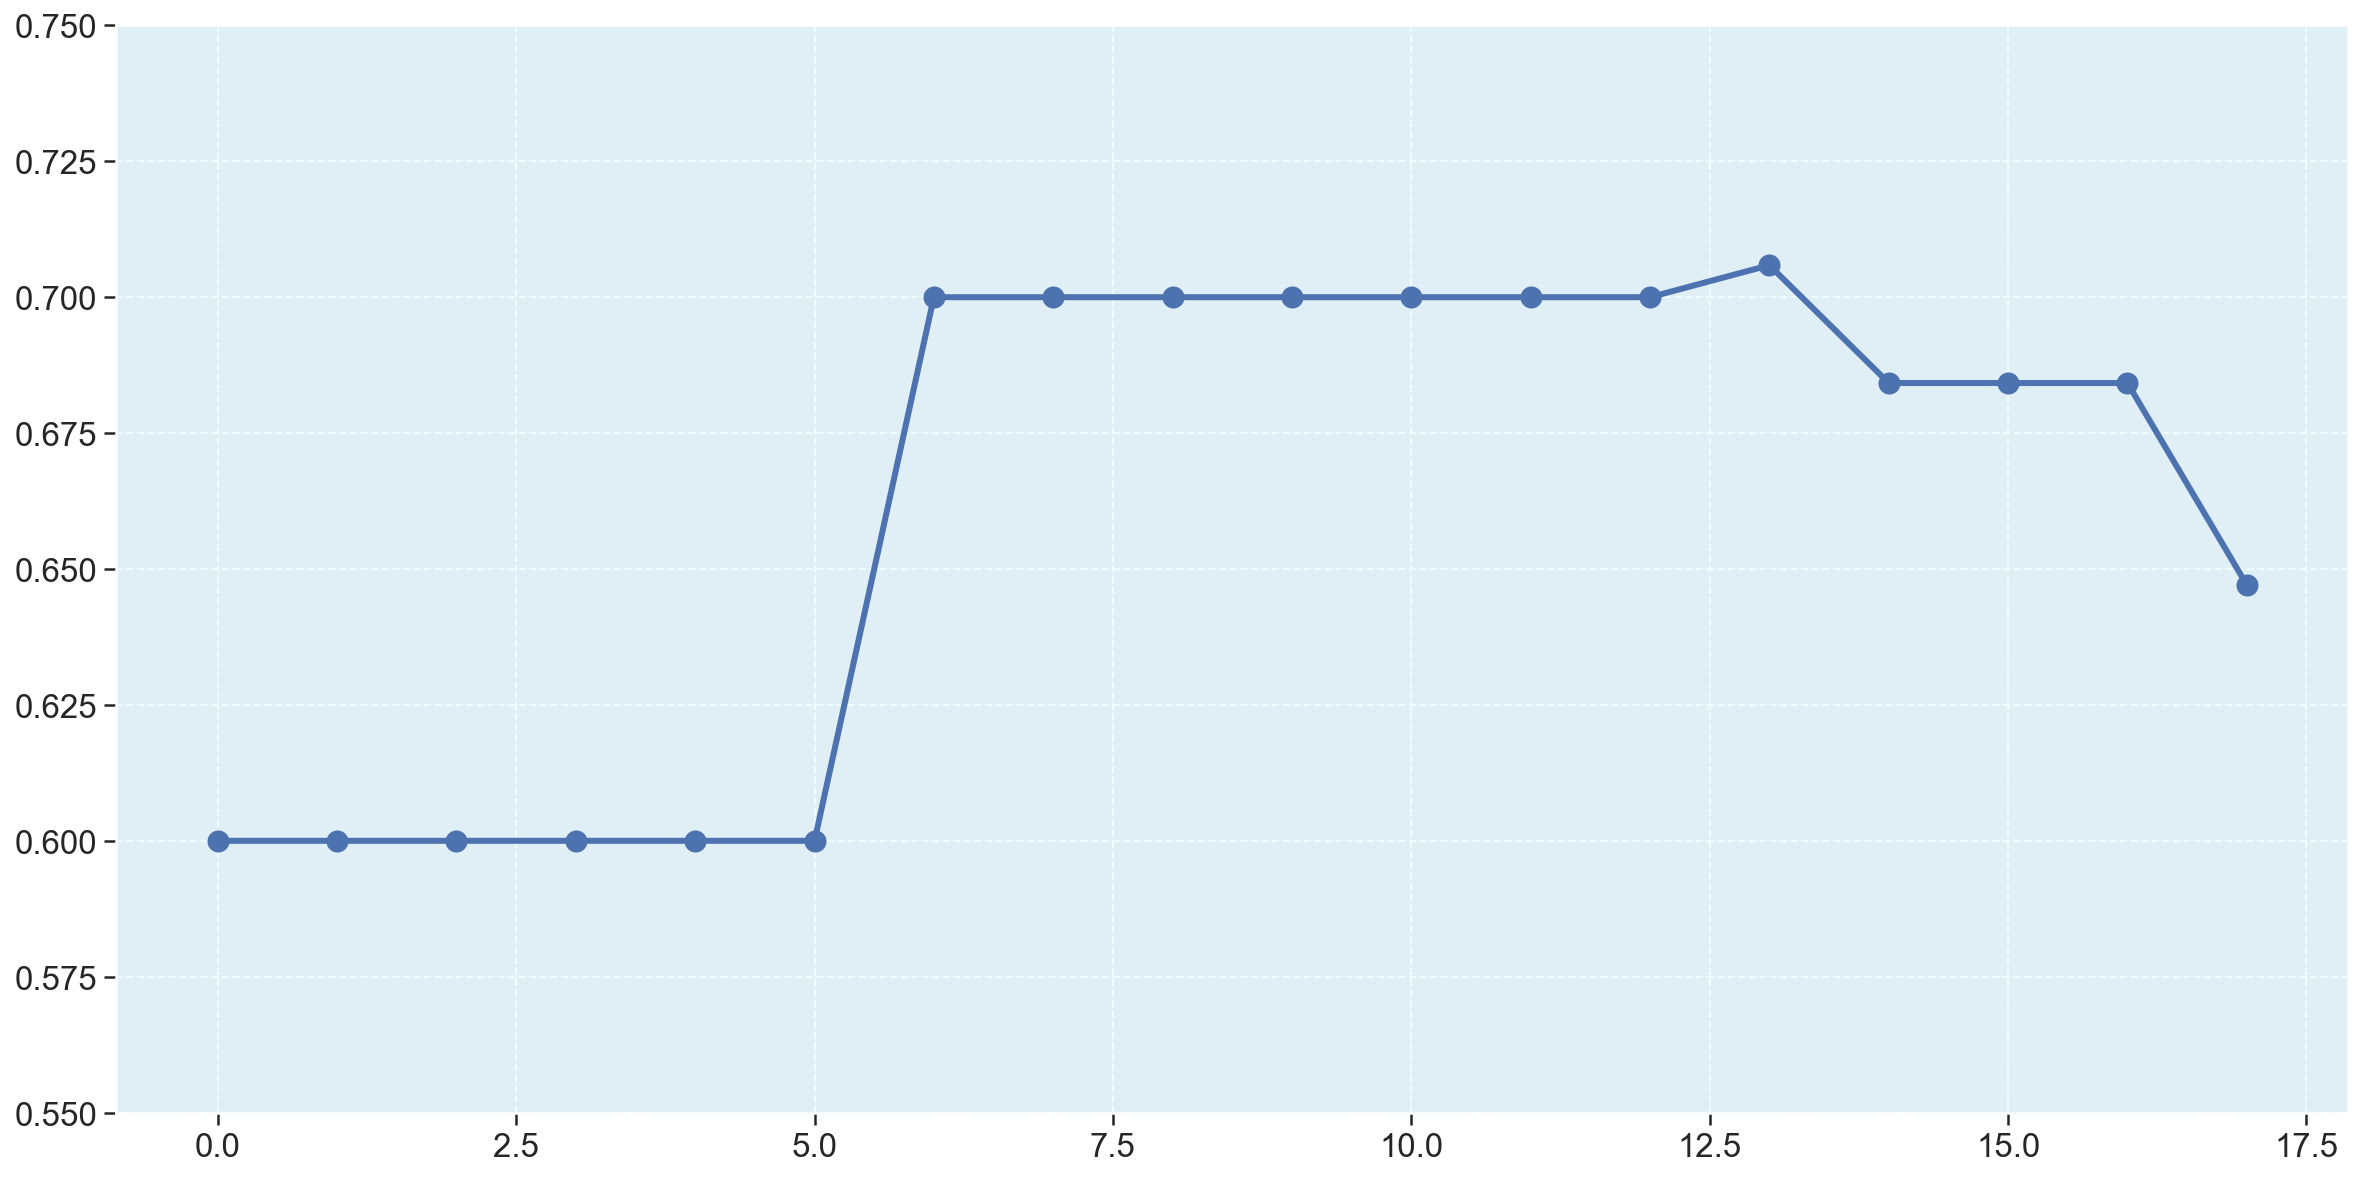

In [39]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['m1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.55,.75, color="#c9f9ff", alpha=0.3)

plt.ylim(.55,.75)

### m2

(-0.03, 0.03)

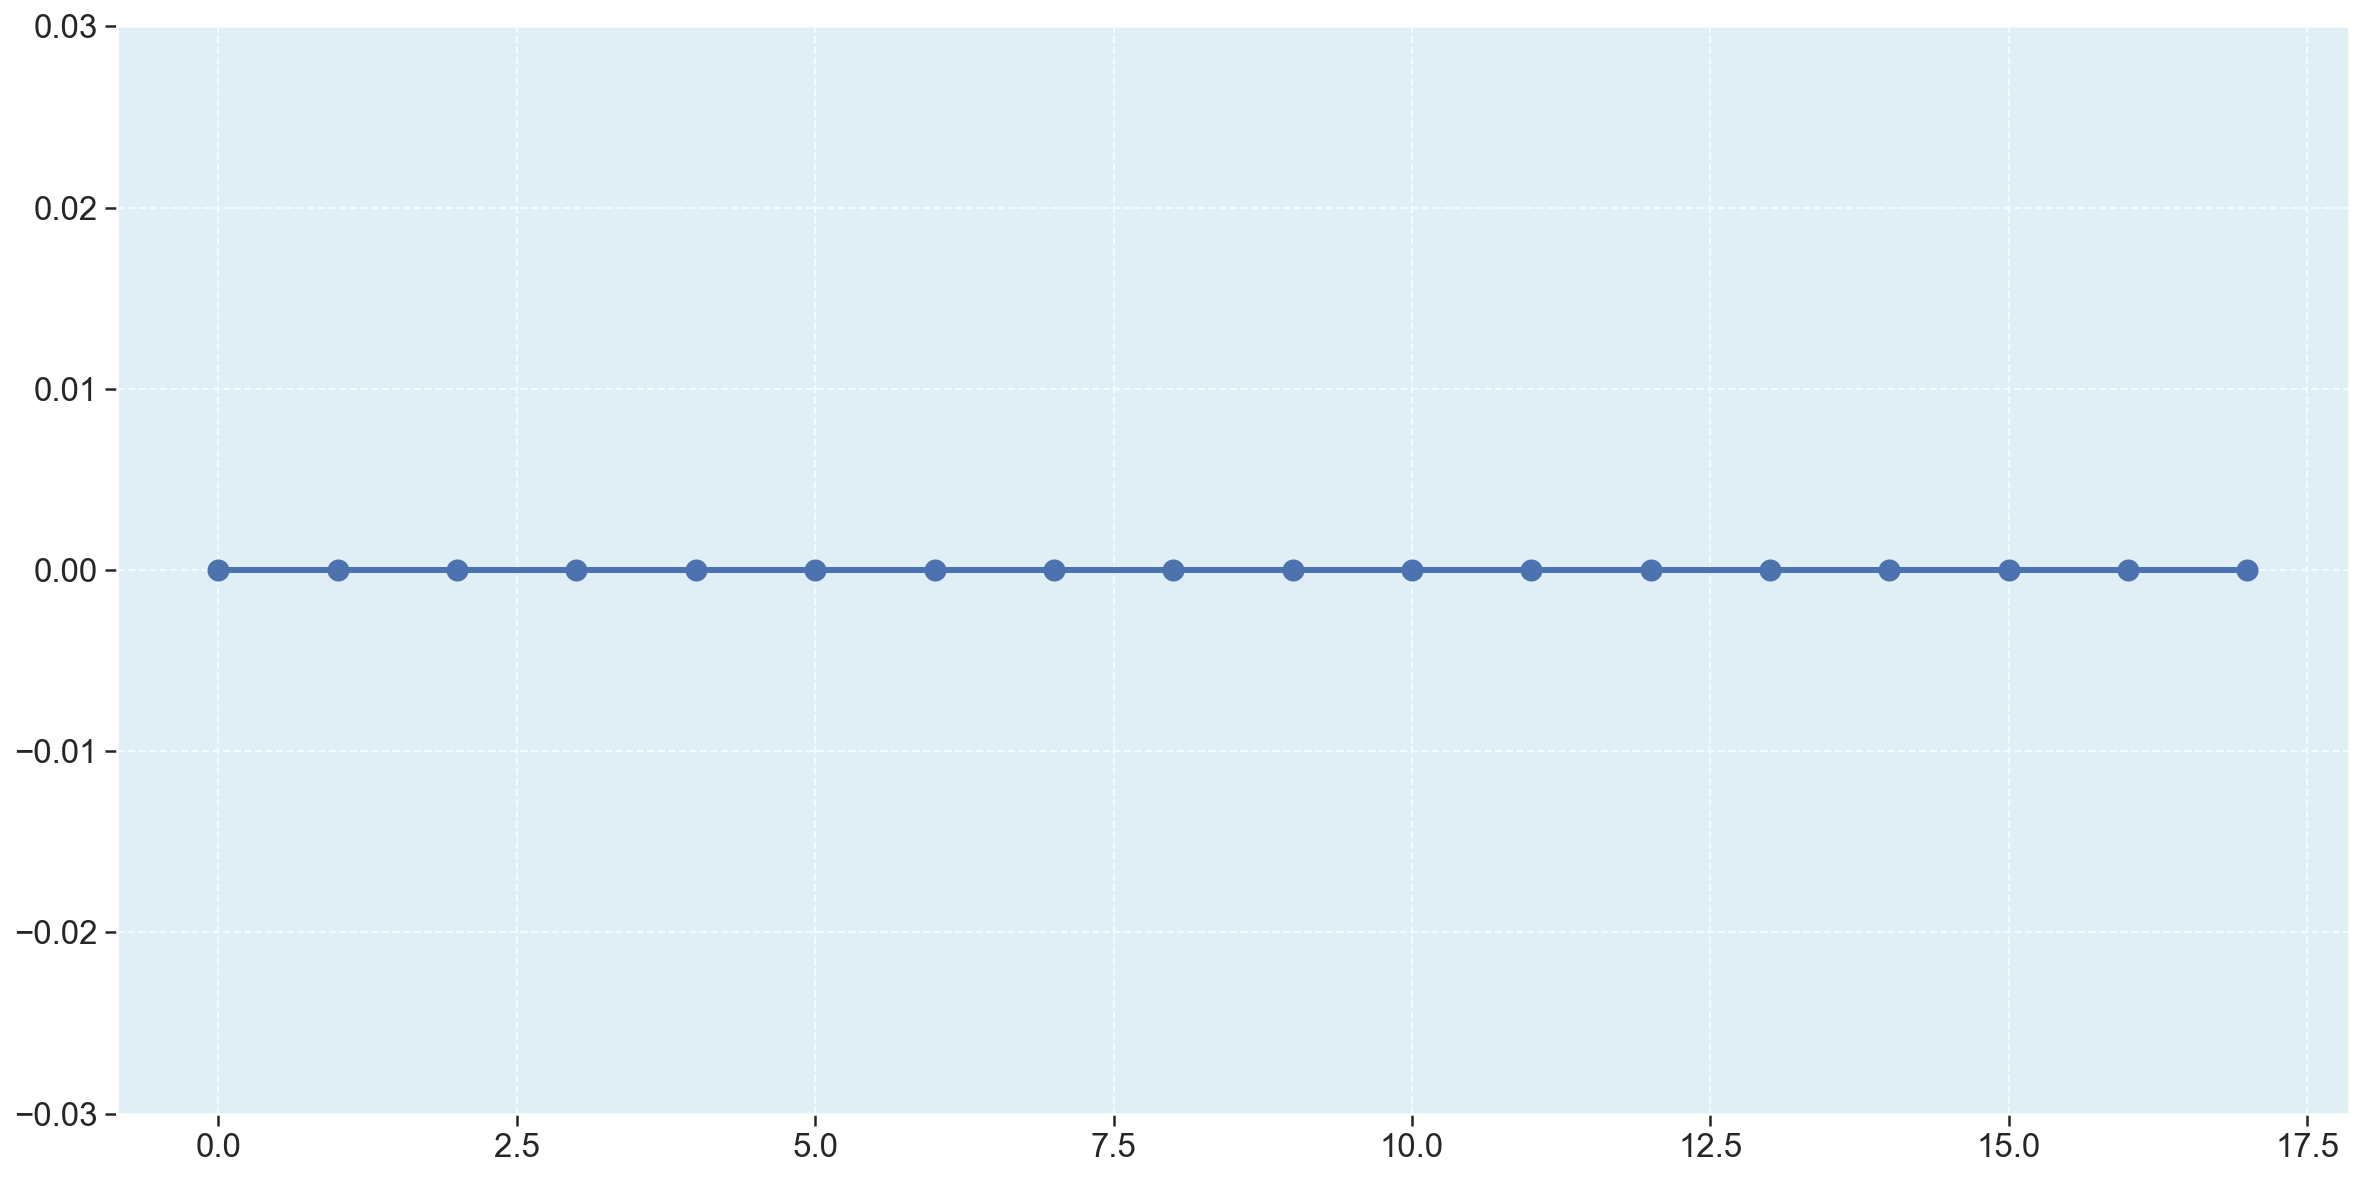

In [40]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['m2'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.03,.03, color="#c9f9ff", alpha=0.3)

plt.ylim(-.03,.03)

### m3

(0.93, 1.01)

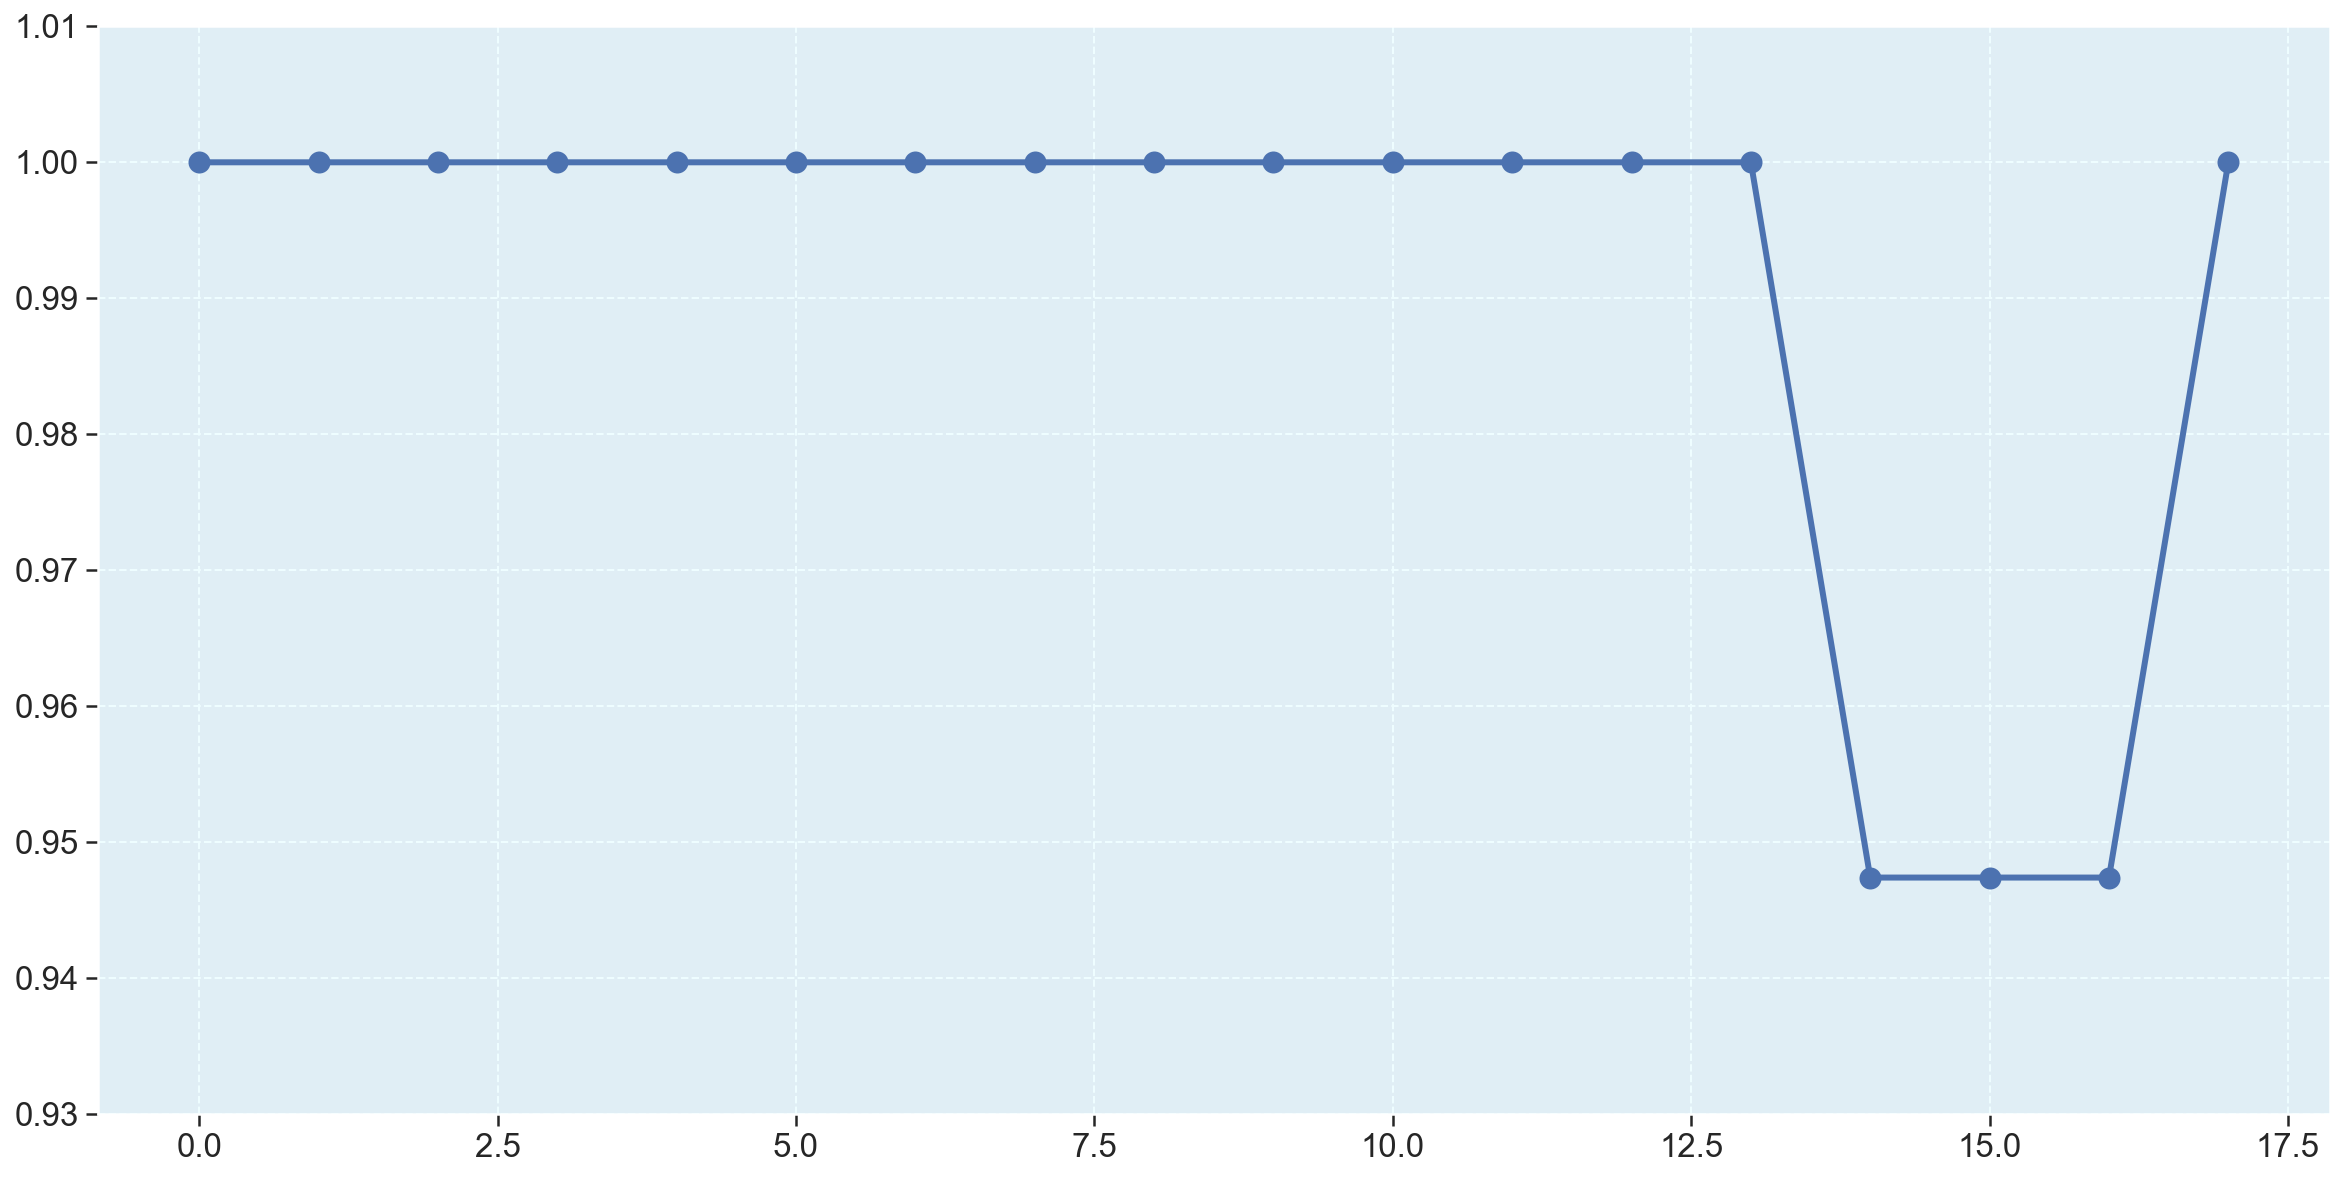

In [41]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.93,1.01, color="#c9f9ff", alpha=0.3)

plt.ylim(.93,1.01)

#### All metrics

(-0.02, 1.02)

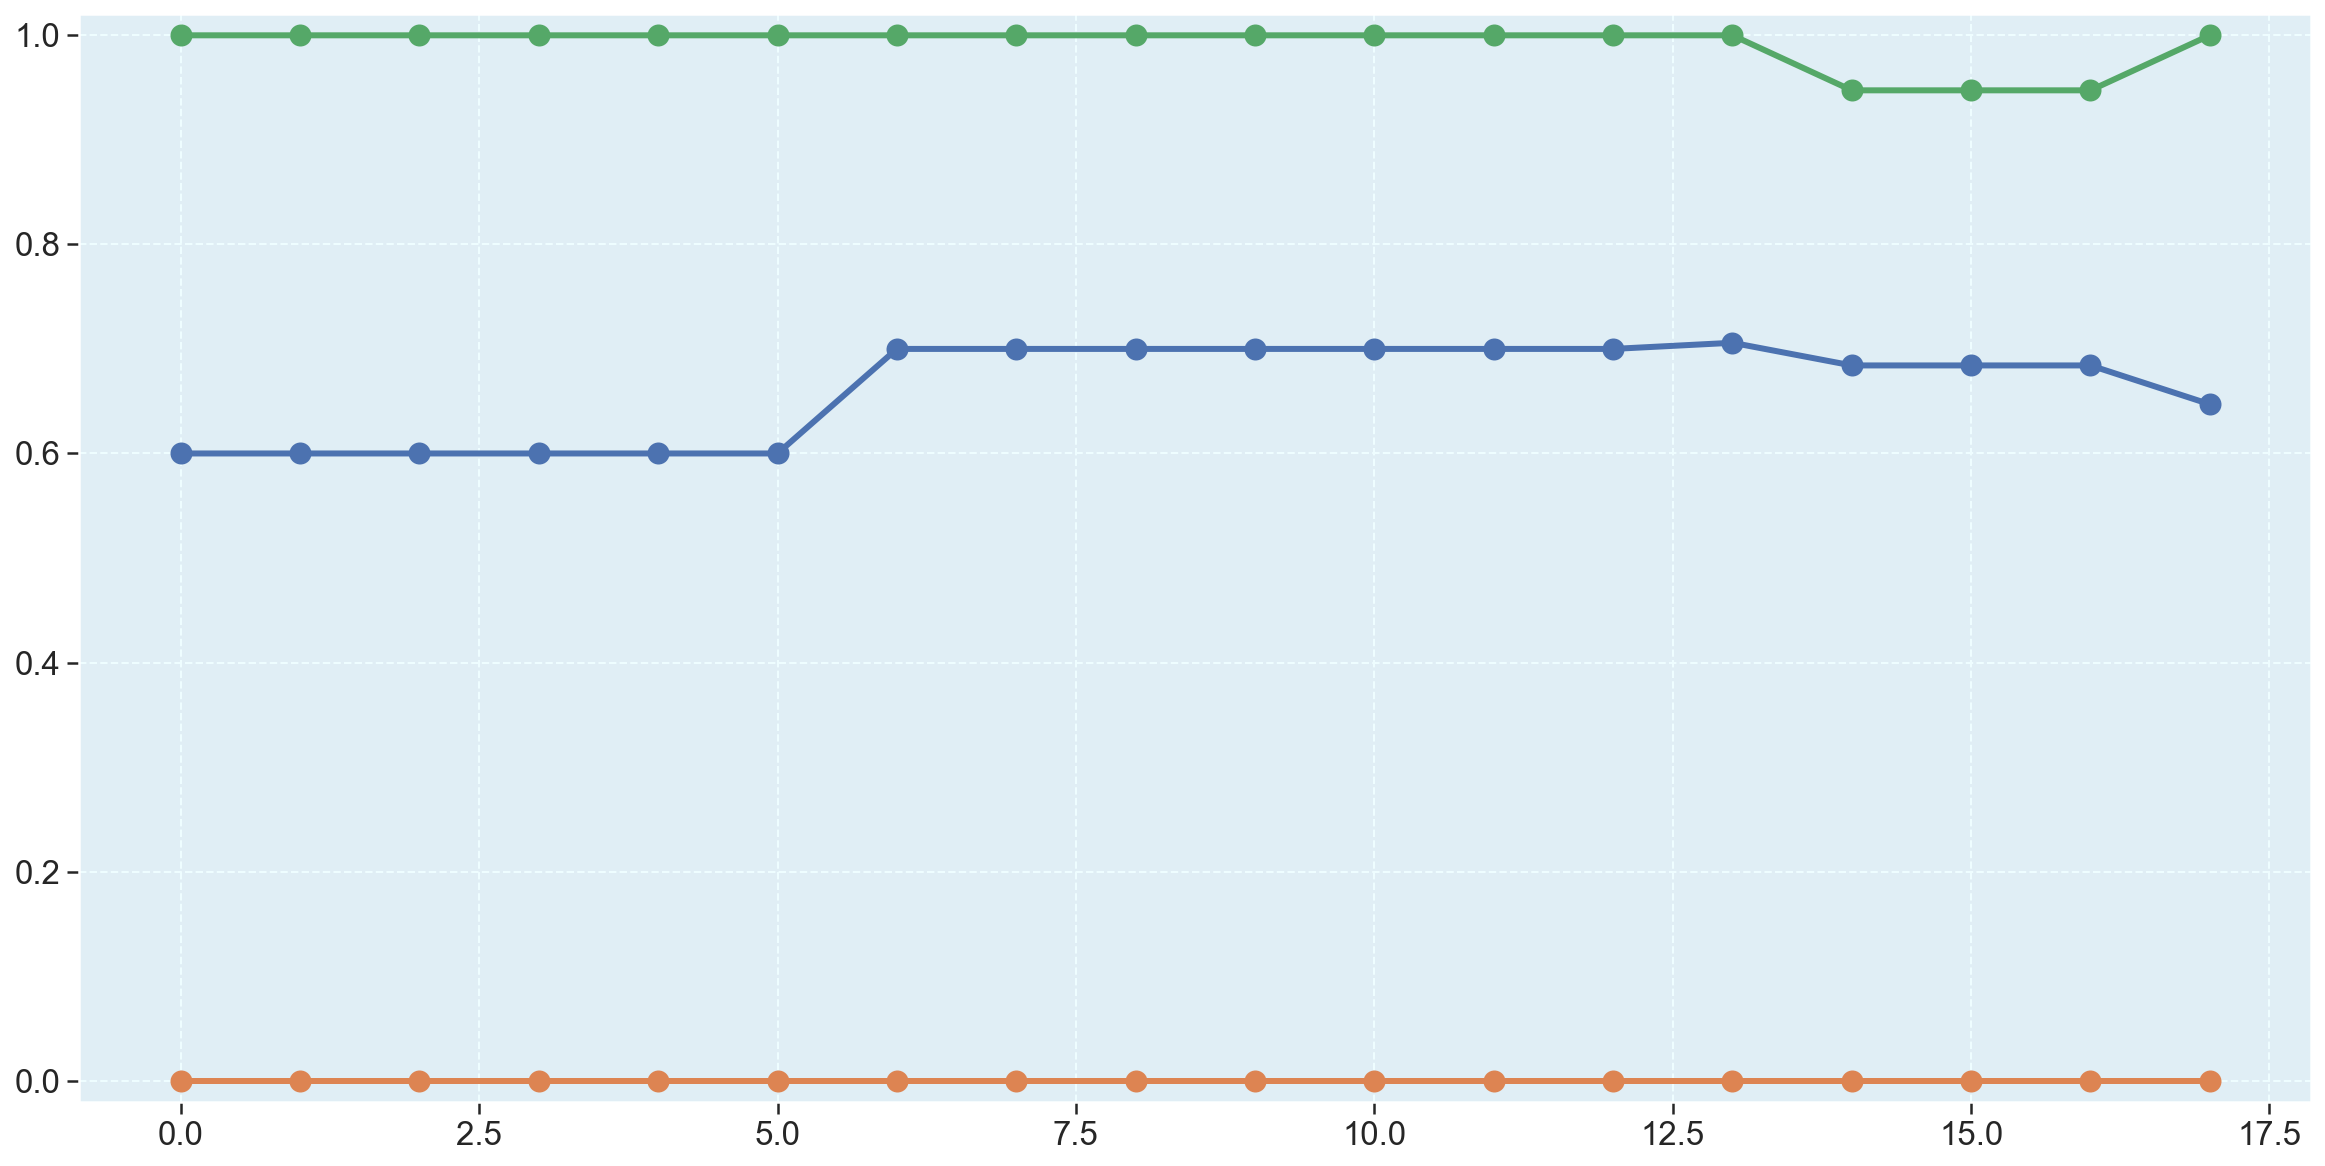

In [42]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(demands_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(demands_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

## Repository: Clients

### m1

(0.55, 0.8)

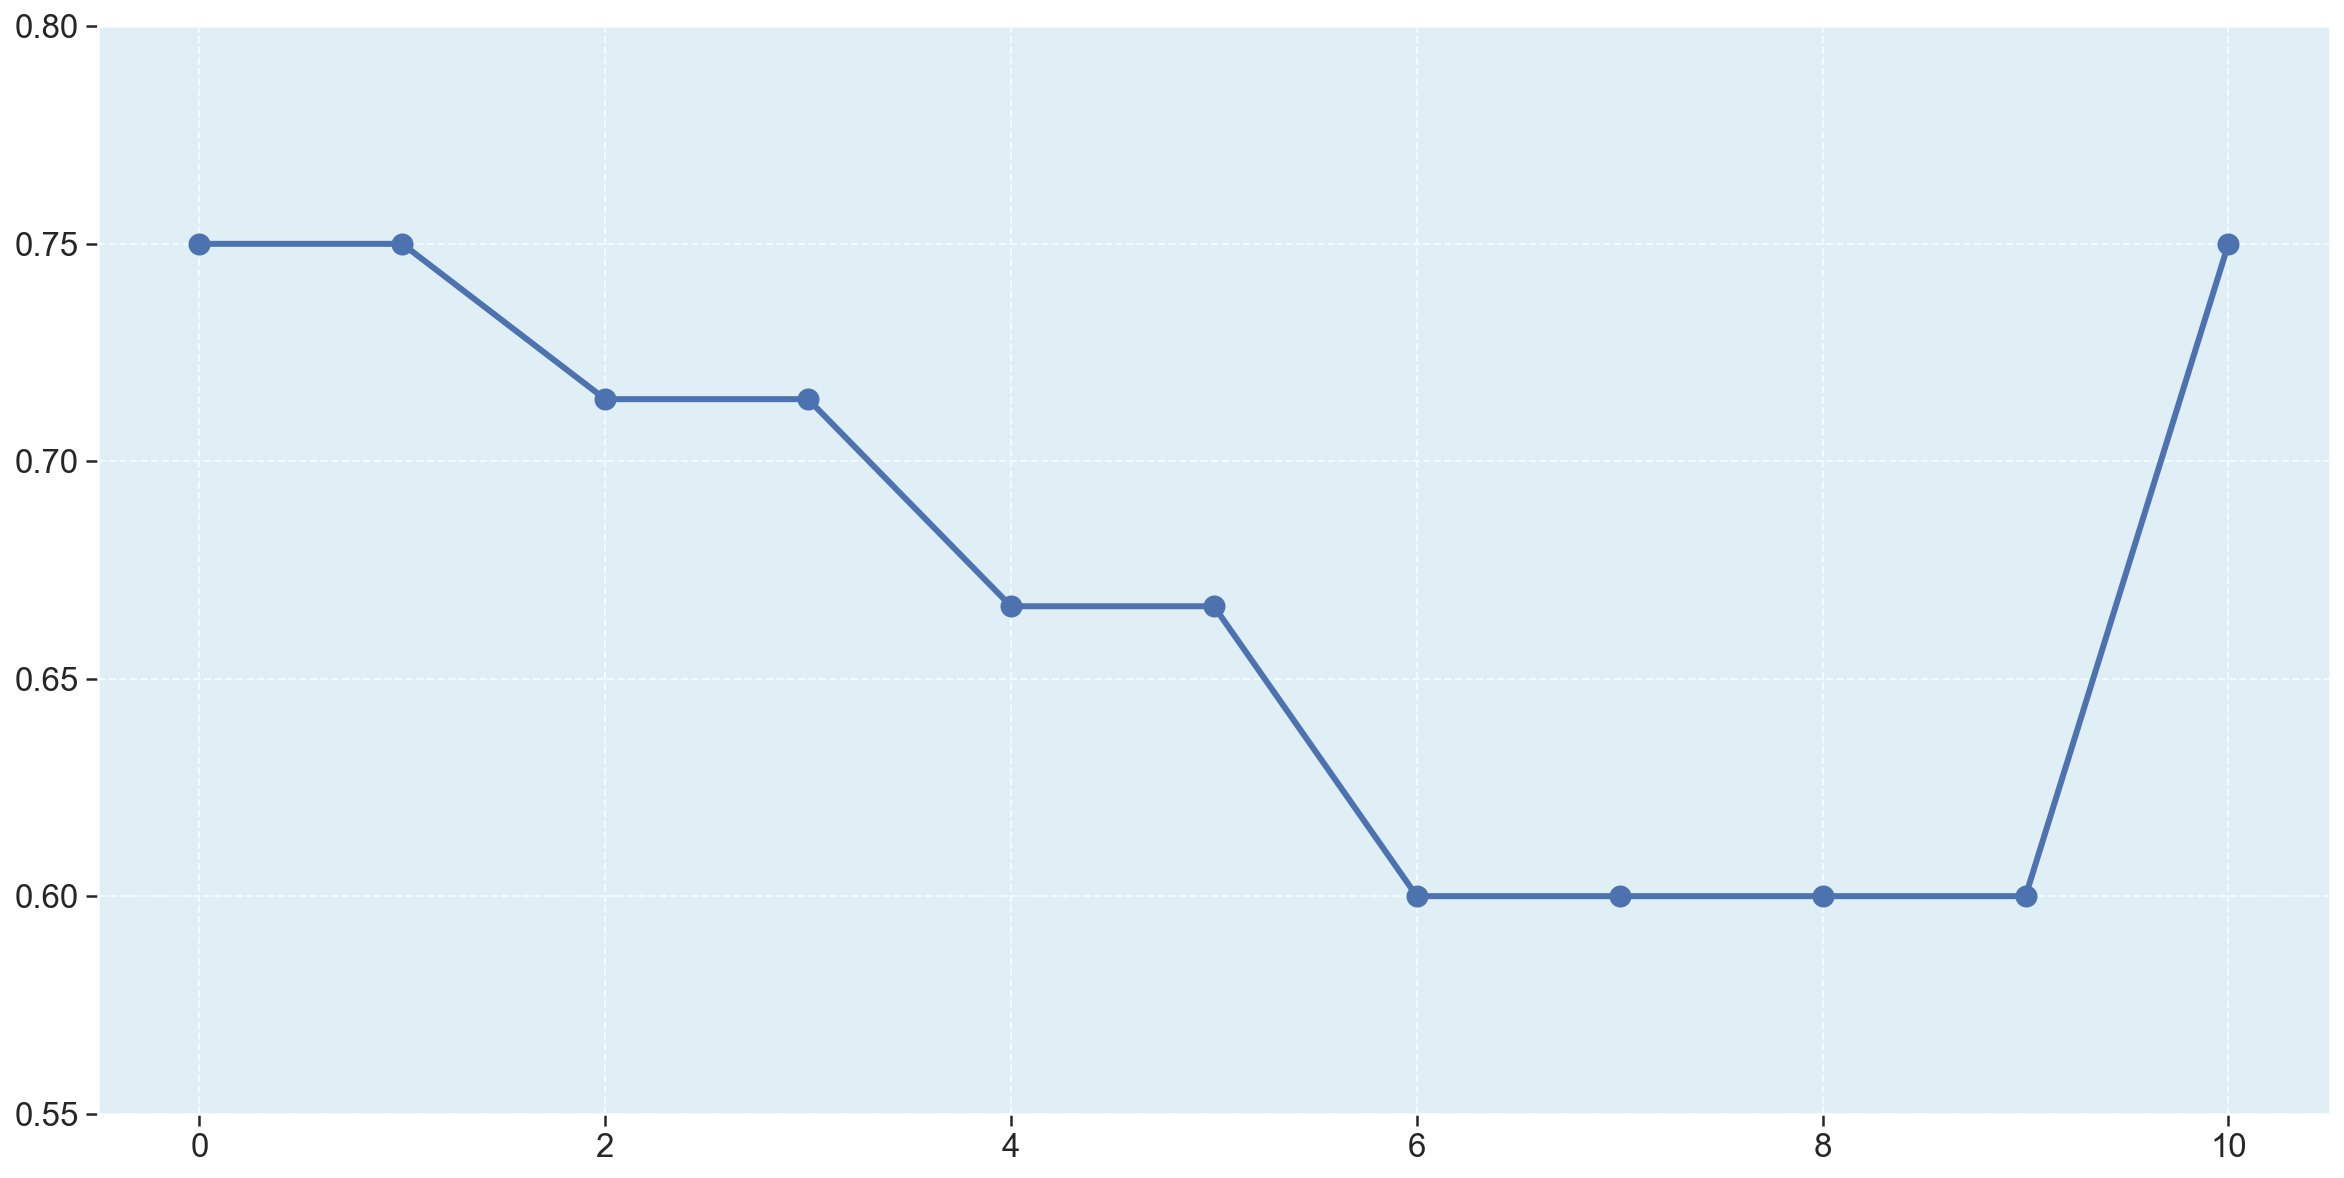

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['m1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.55,.8, color="#c9f9ff", alpha=0.3)

plt.ylim(.55,.8)

### m2

(-0.03, 0.03)

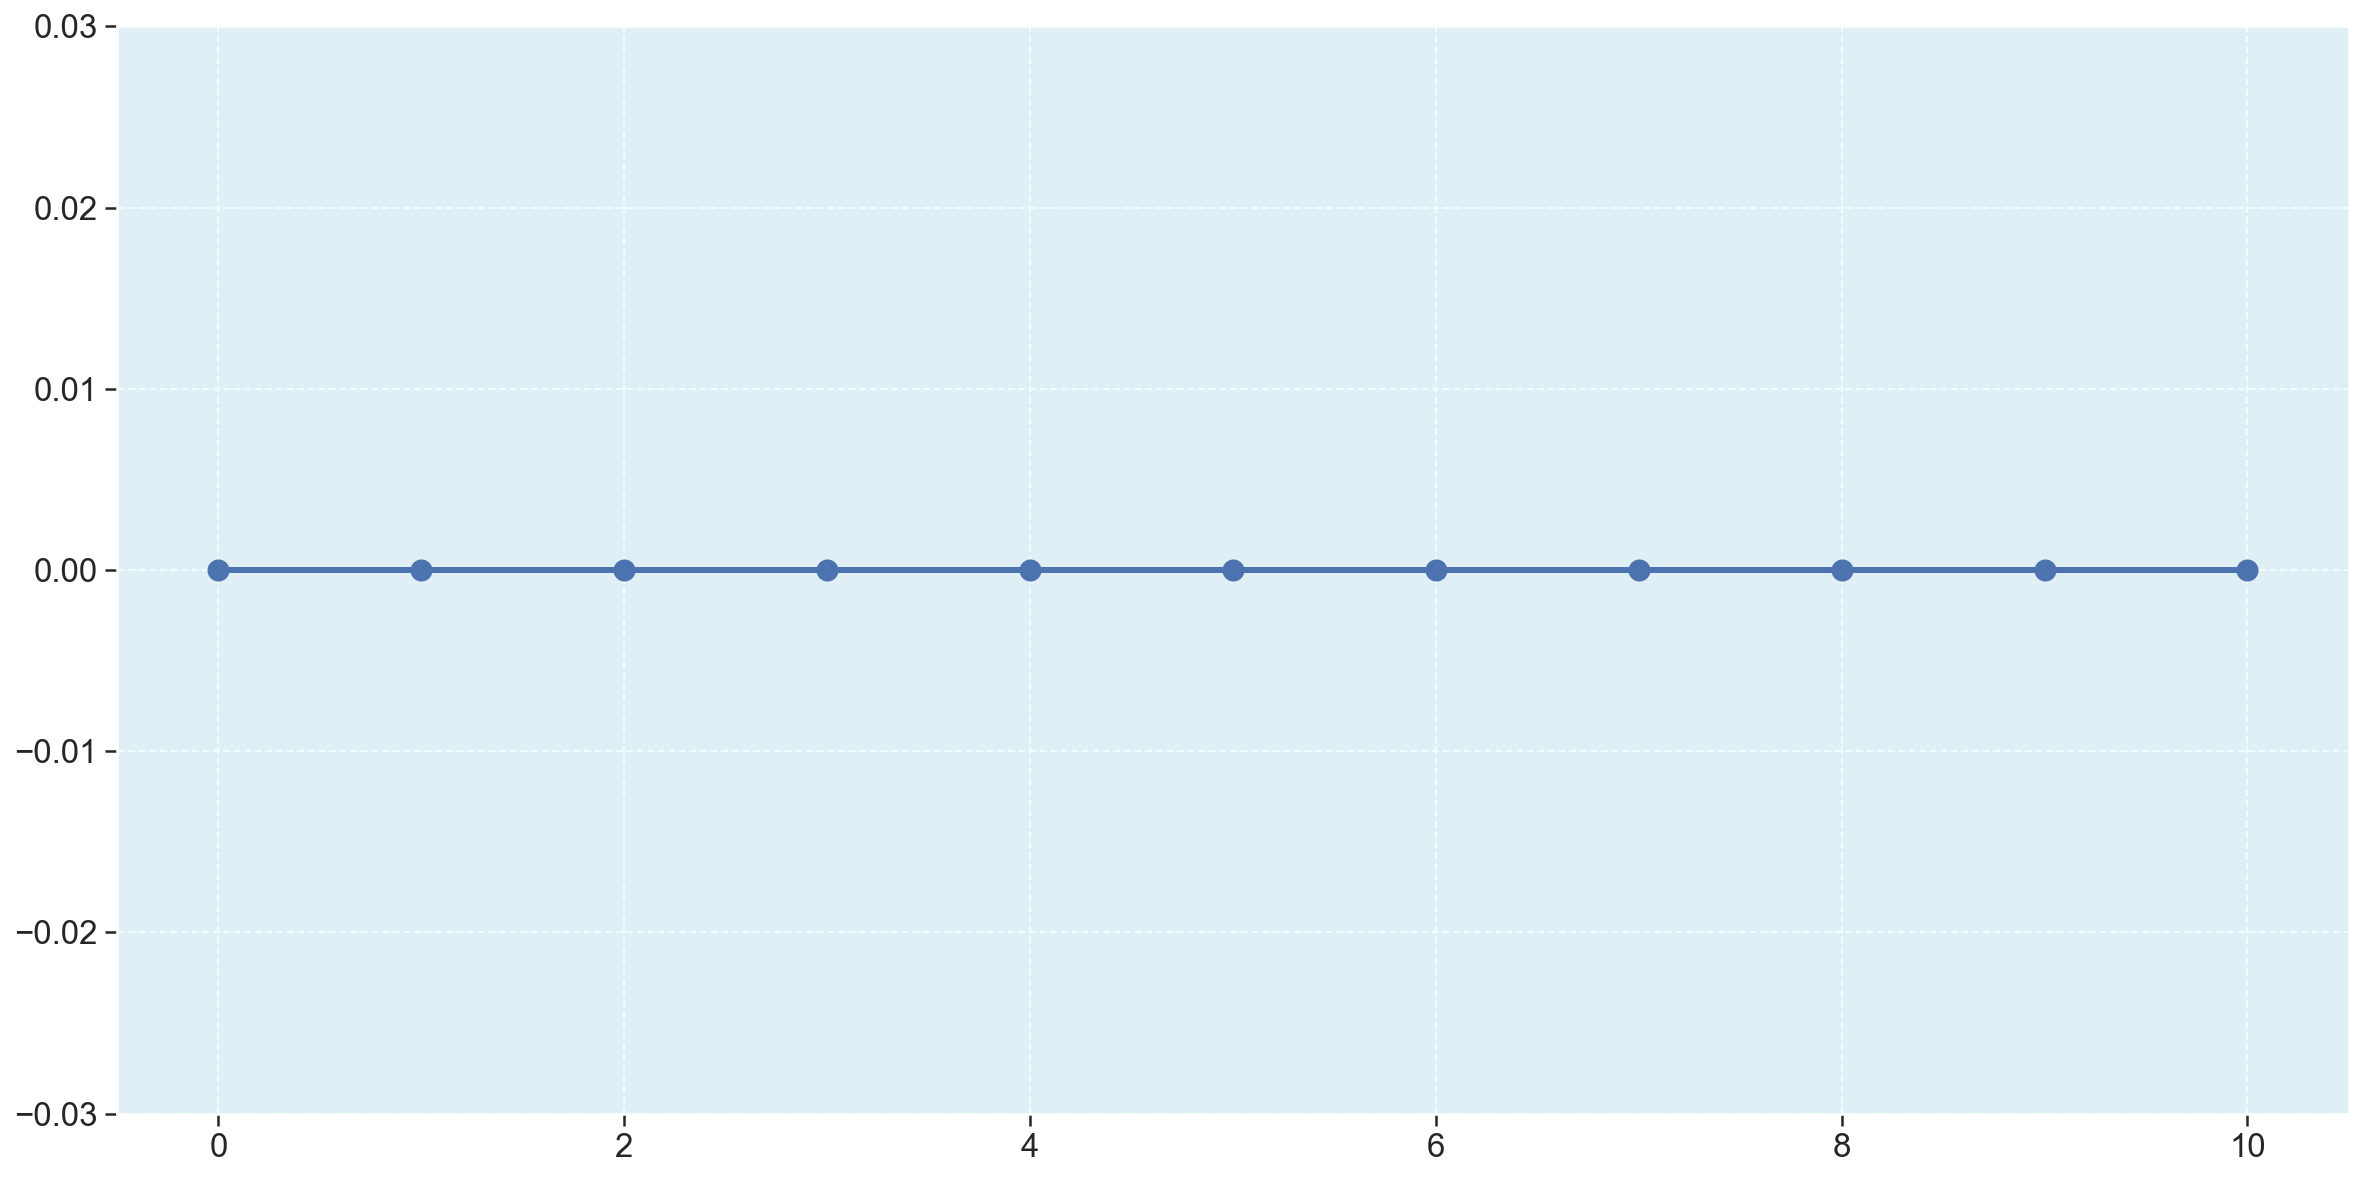

In [44]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['m2'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.03,.03, color="#c9f9ff", alpha=0.3)

plt.ylim(-.03,.03)

### m3

(0.91, 1.04)

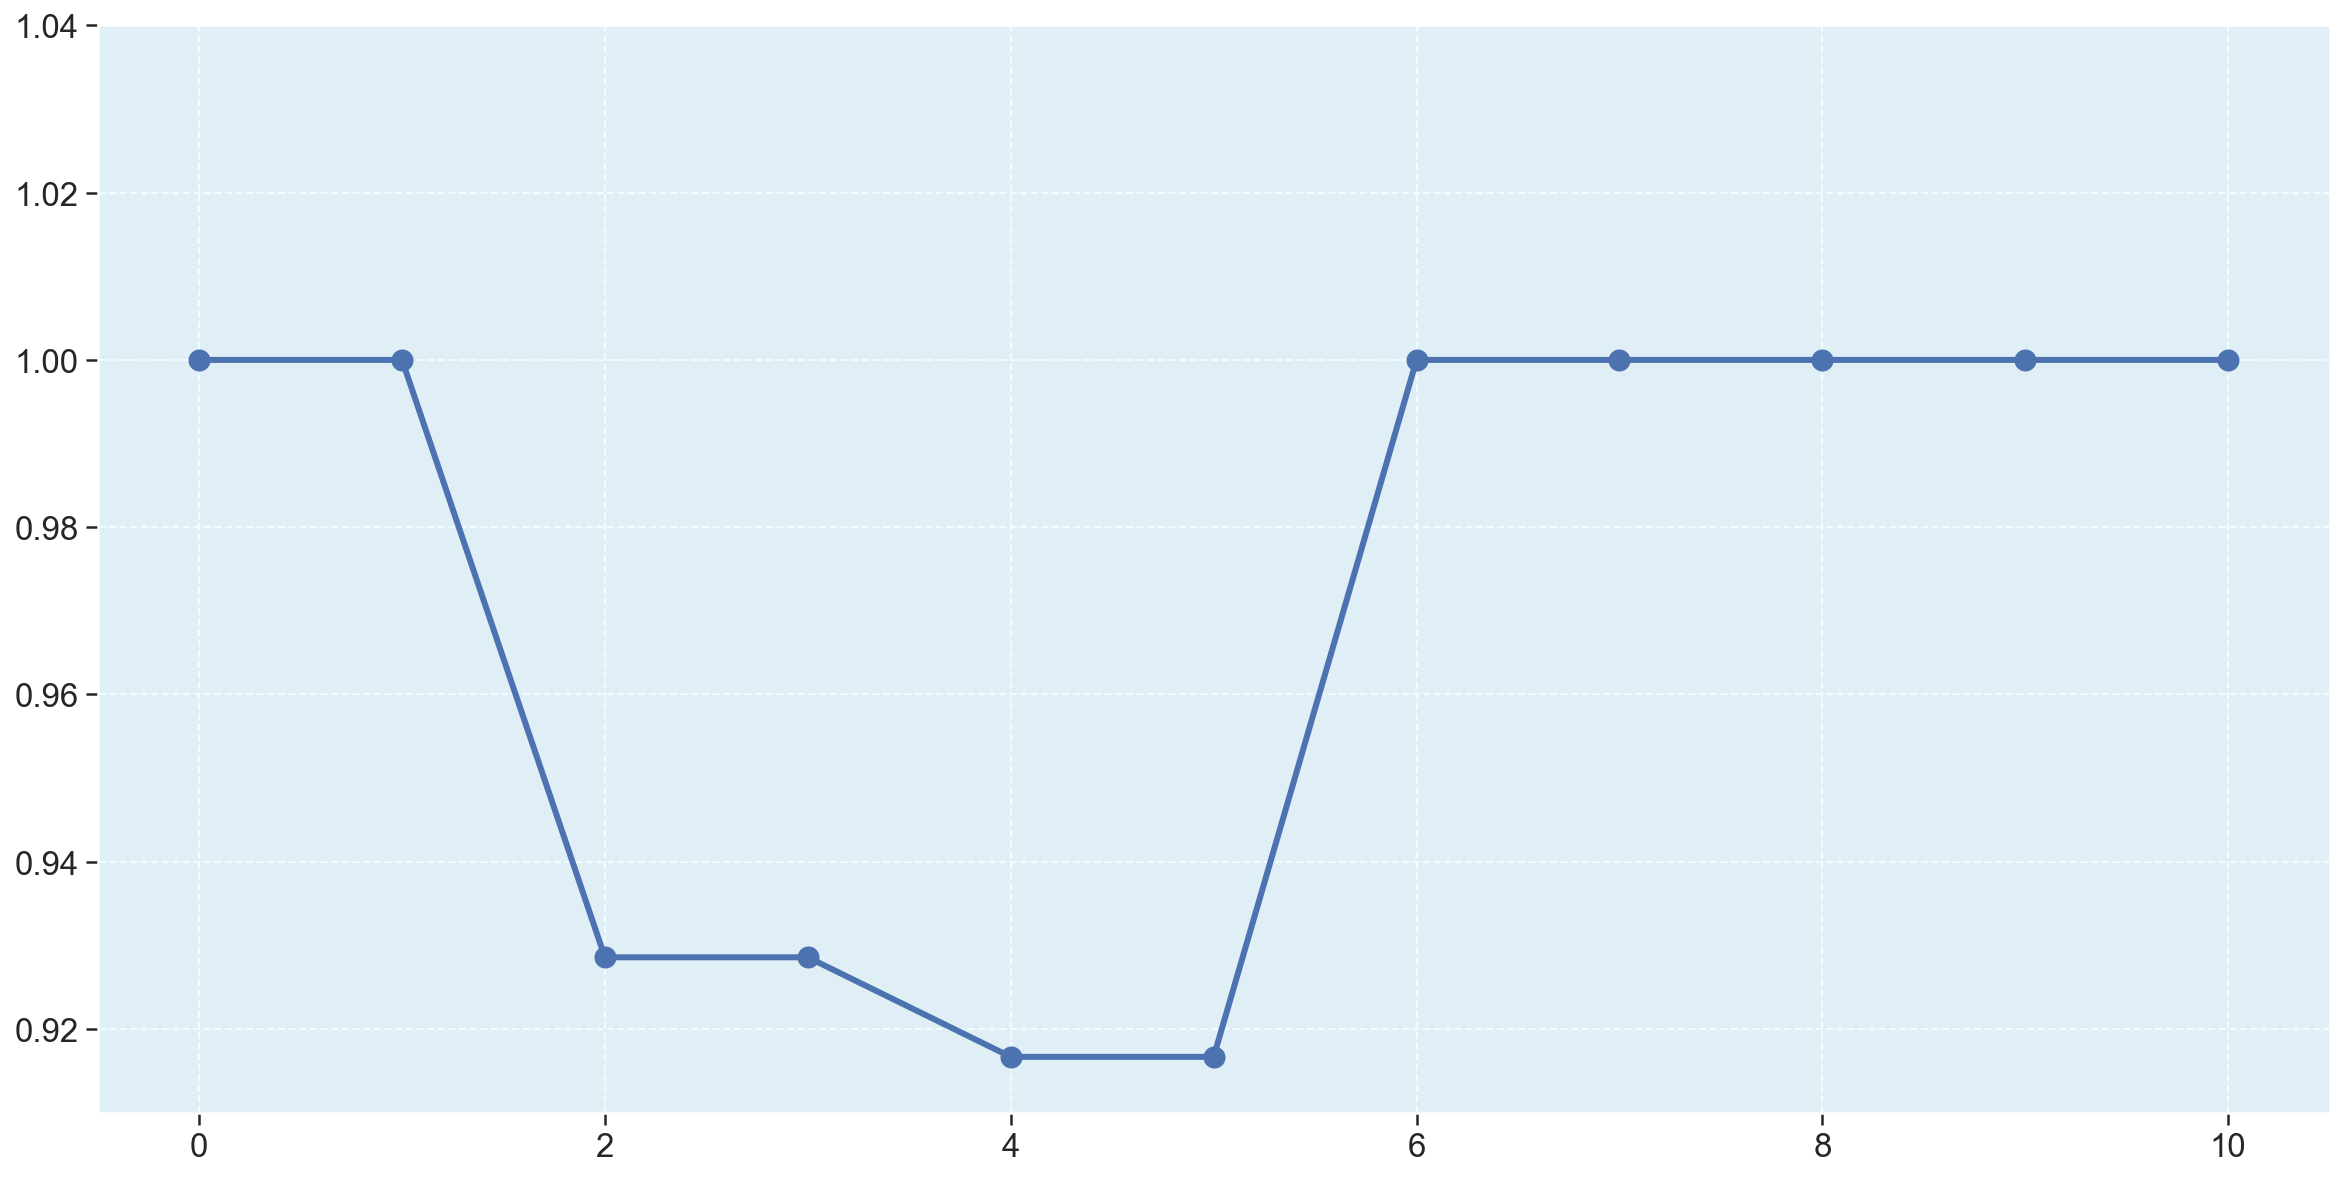

In [45]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.91,1.04, color="#c9f9ff", alpha=0.3)

plt.ylim(.91,1.04)

(-0.02, 1.02)

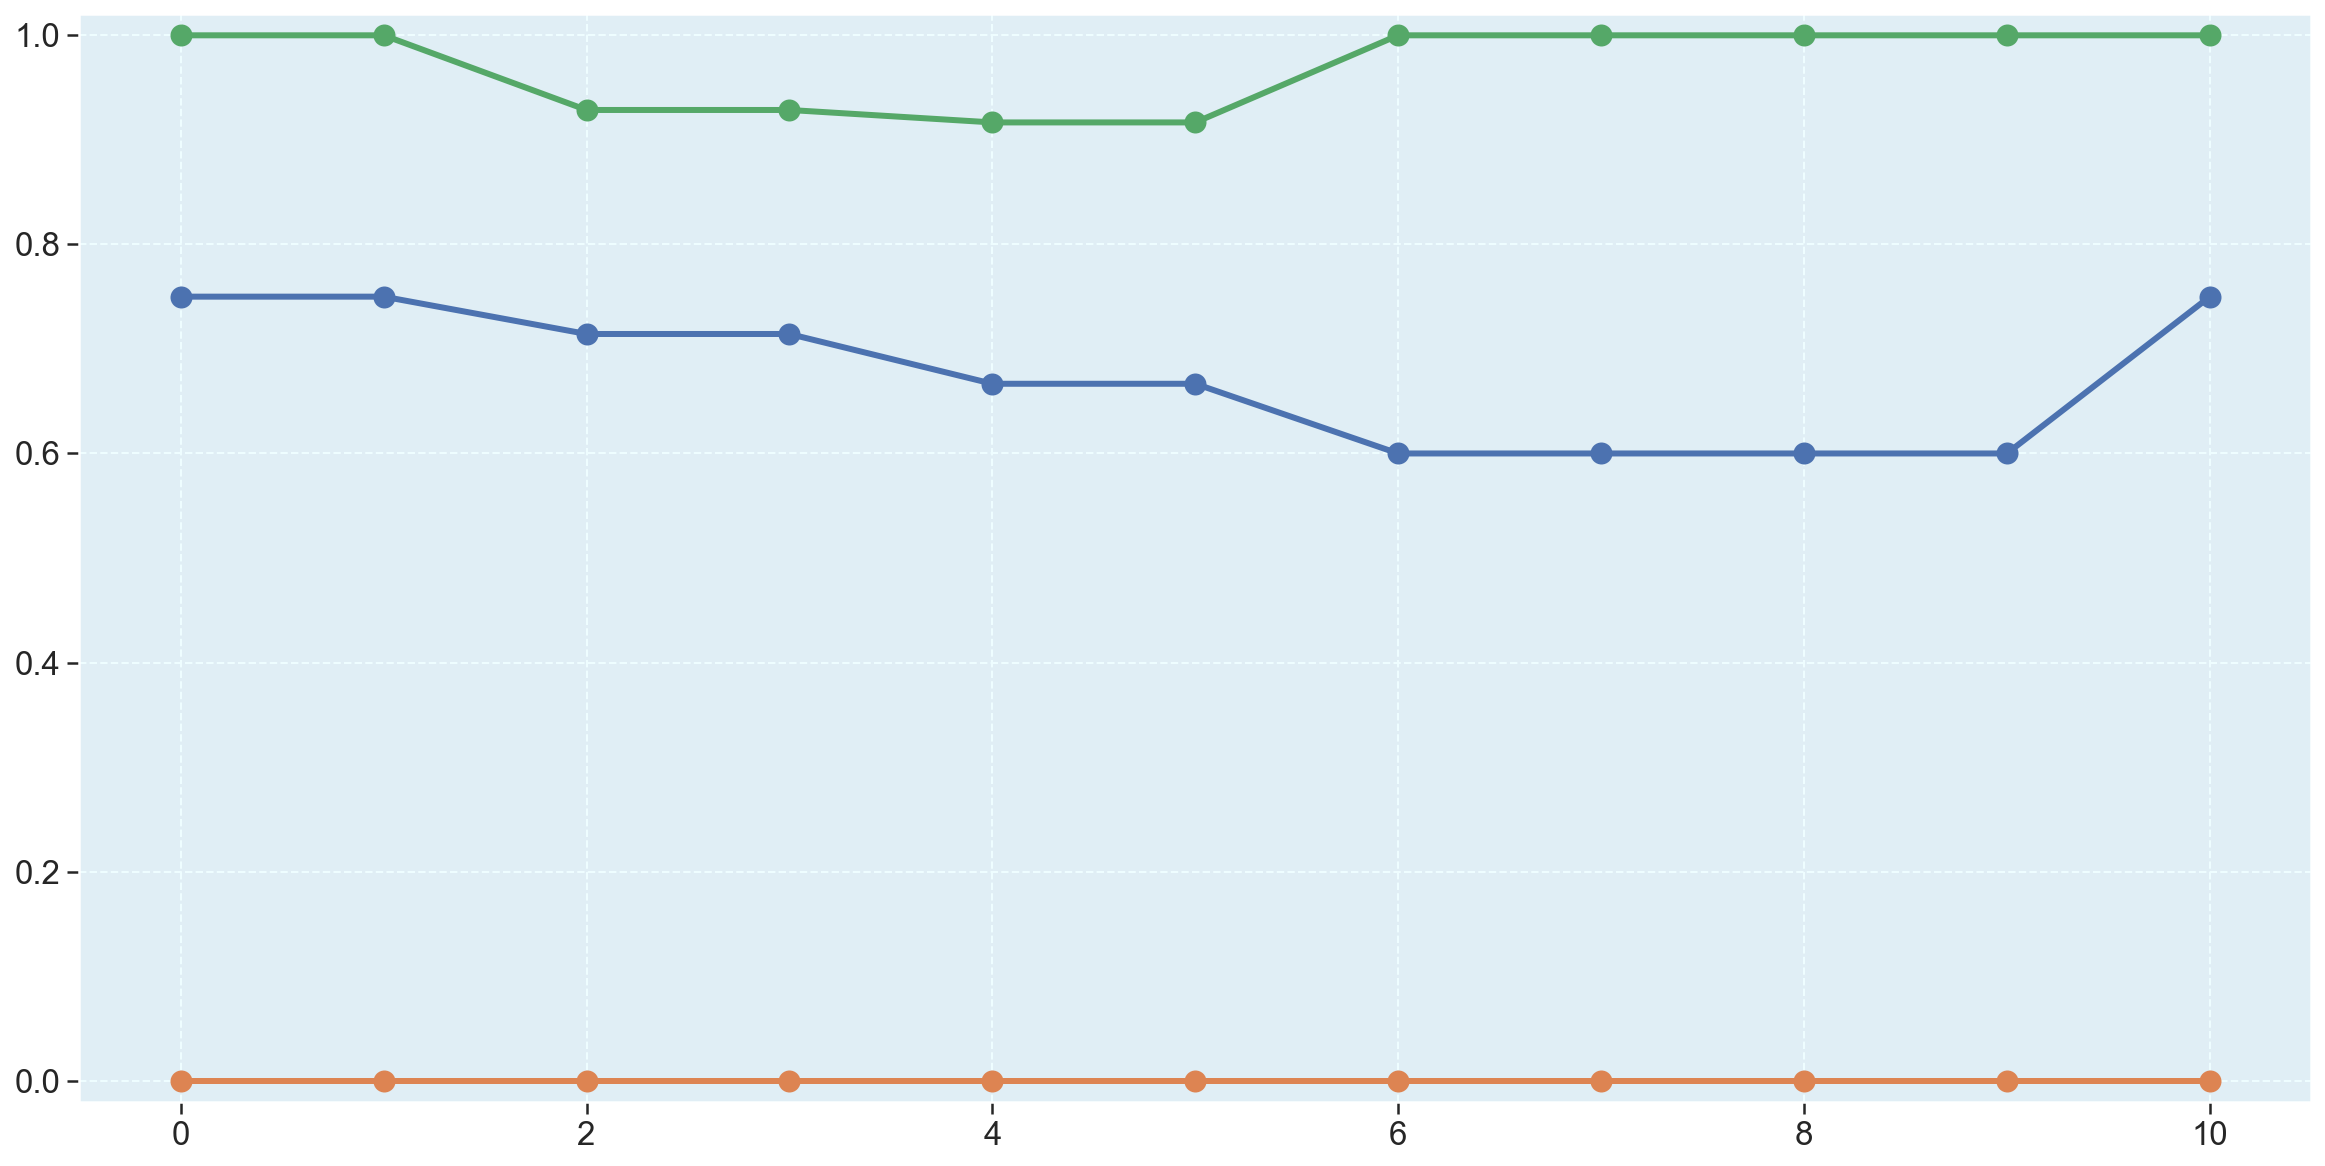

In [46]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(clients_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(clients_metrics['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

### Ponderação e Agregação na SubCaracterística

In [47]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

users_metrics['asc1'] = ((users_metrics['m1']*pm1)+(users_metrics['m2']*pm2)+(users_metrics['m3']*pm3))*psc1
sectors_metrics['asc1'] = ((sectors_metrics['m1']*pm1)+(sectors_metrics['m2']*pm2)+(sectors_metrics['m3']*pm3))*psc1
frontend_metrics['asc1'] = ((frontend_metrics['m1']*pm1)+(frontend_metrics['m2']*pm2)+(frontend_metrics['m3']*pm3))*psc1
demands_metrics['asc1'] = ((demands_metrics['m1']*pm1)+(demands_metrics['m2']*pm2)+(demands_metrics['m3']*pm3))*psc1
clients_metrics['asc1'] = ((clients_metrics['m1']*pm1)+(clients_metrics['m2']*pm2)+(clients_metrics['m3']*pm3))*psc1

(0.53, 0.6)

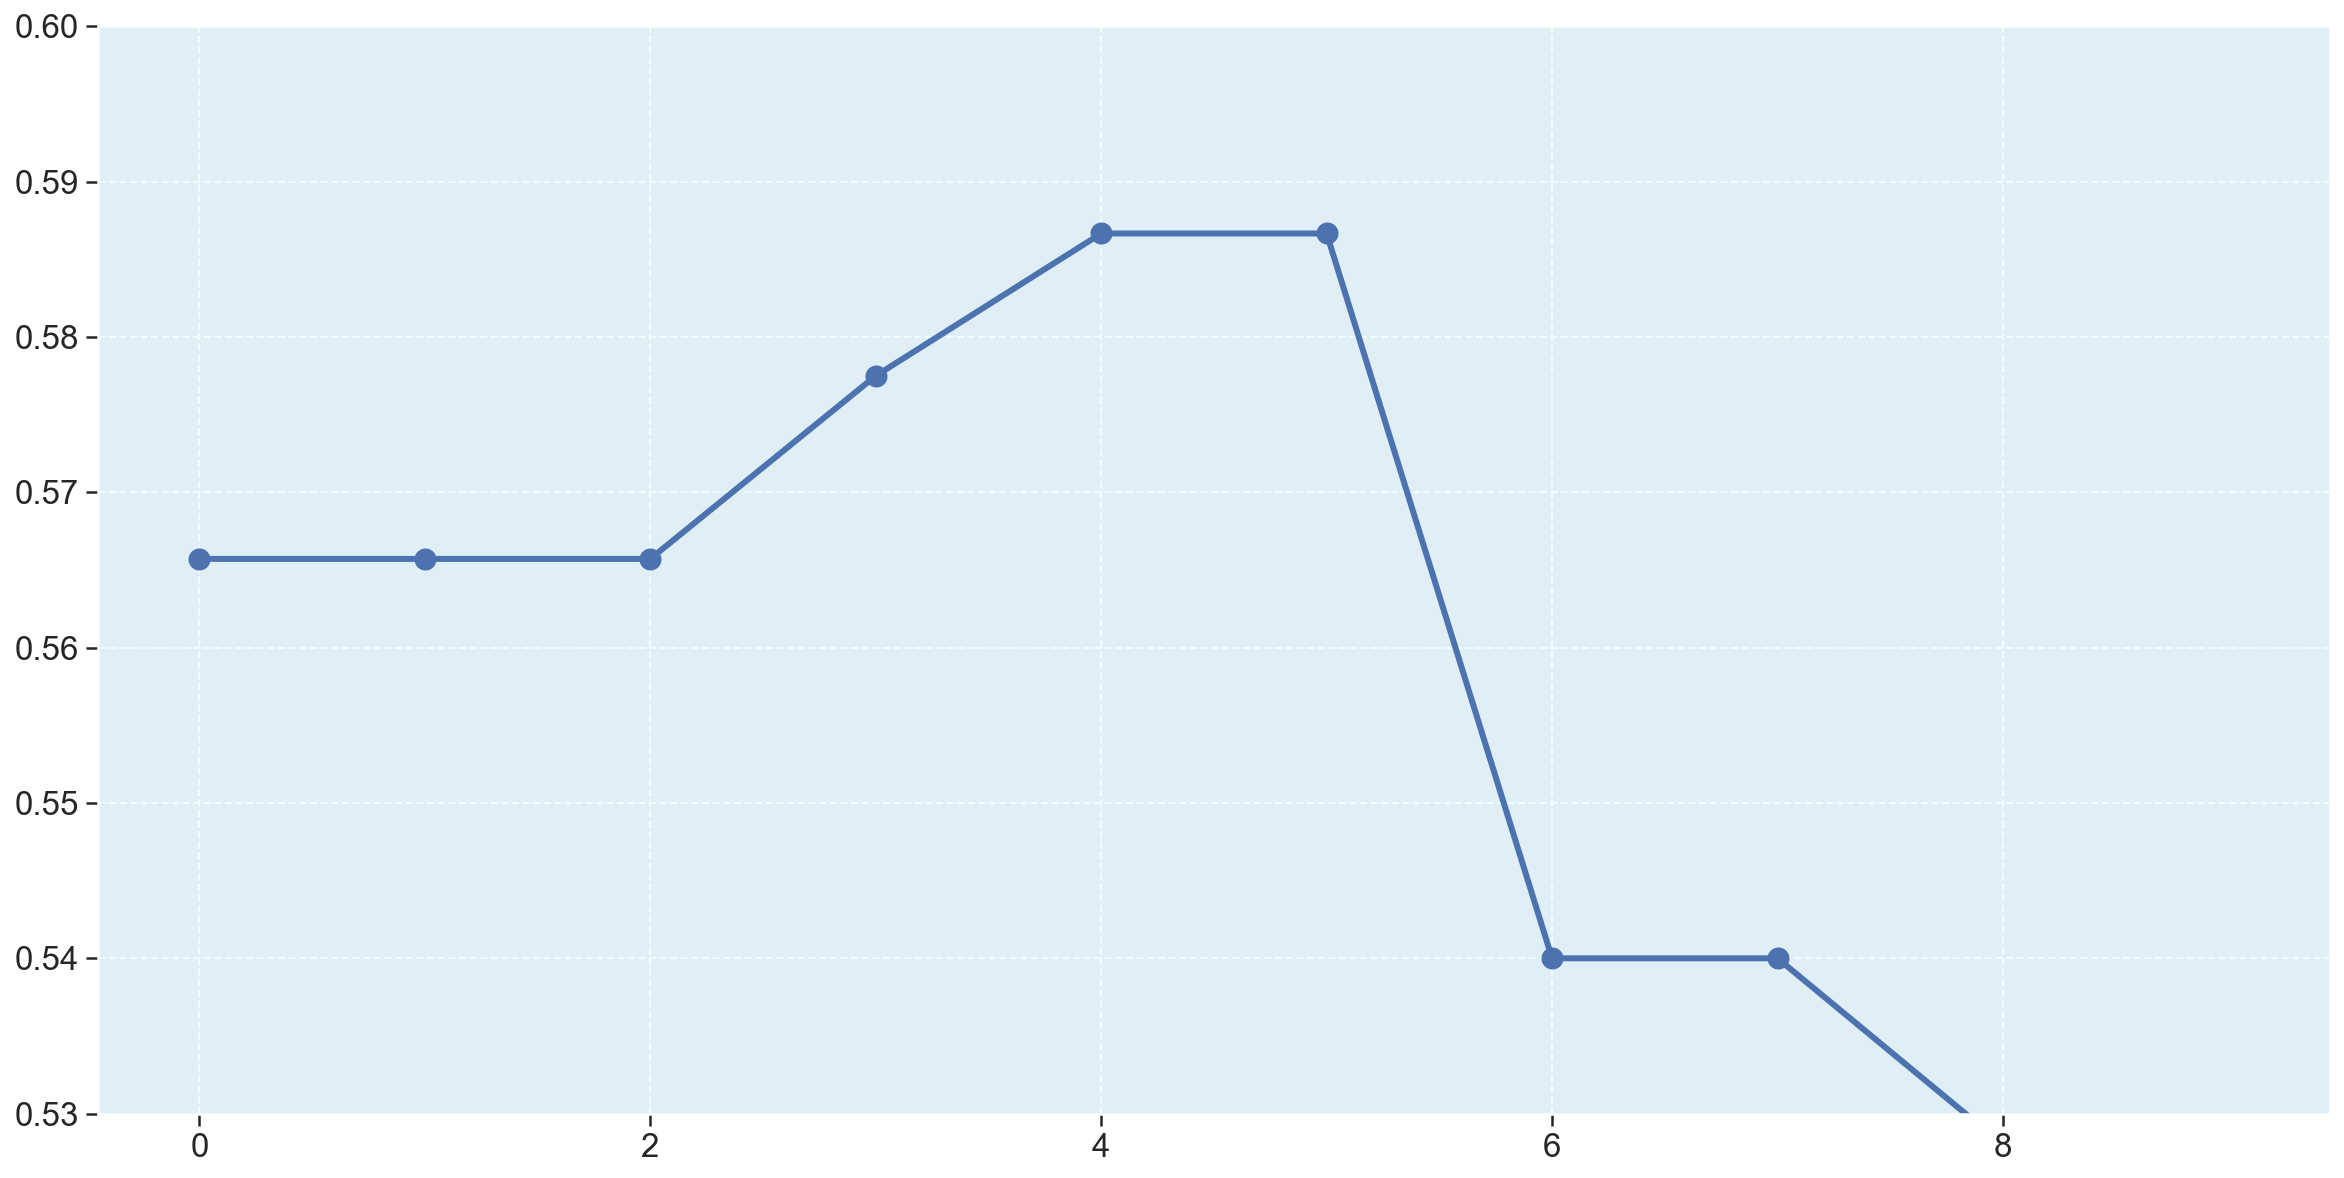

In [48]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.53,.6, color="#c9f9ff", alpha=0.3)

plt.ylim(.53,.6)

(0.45, 0.6)

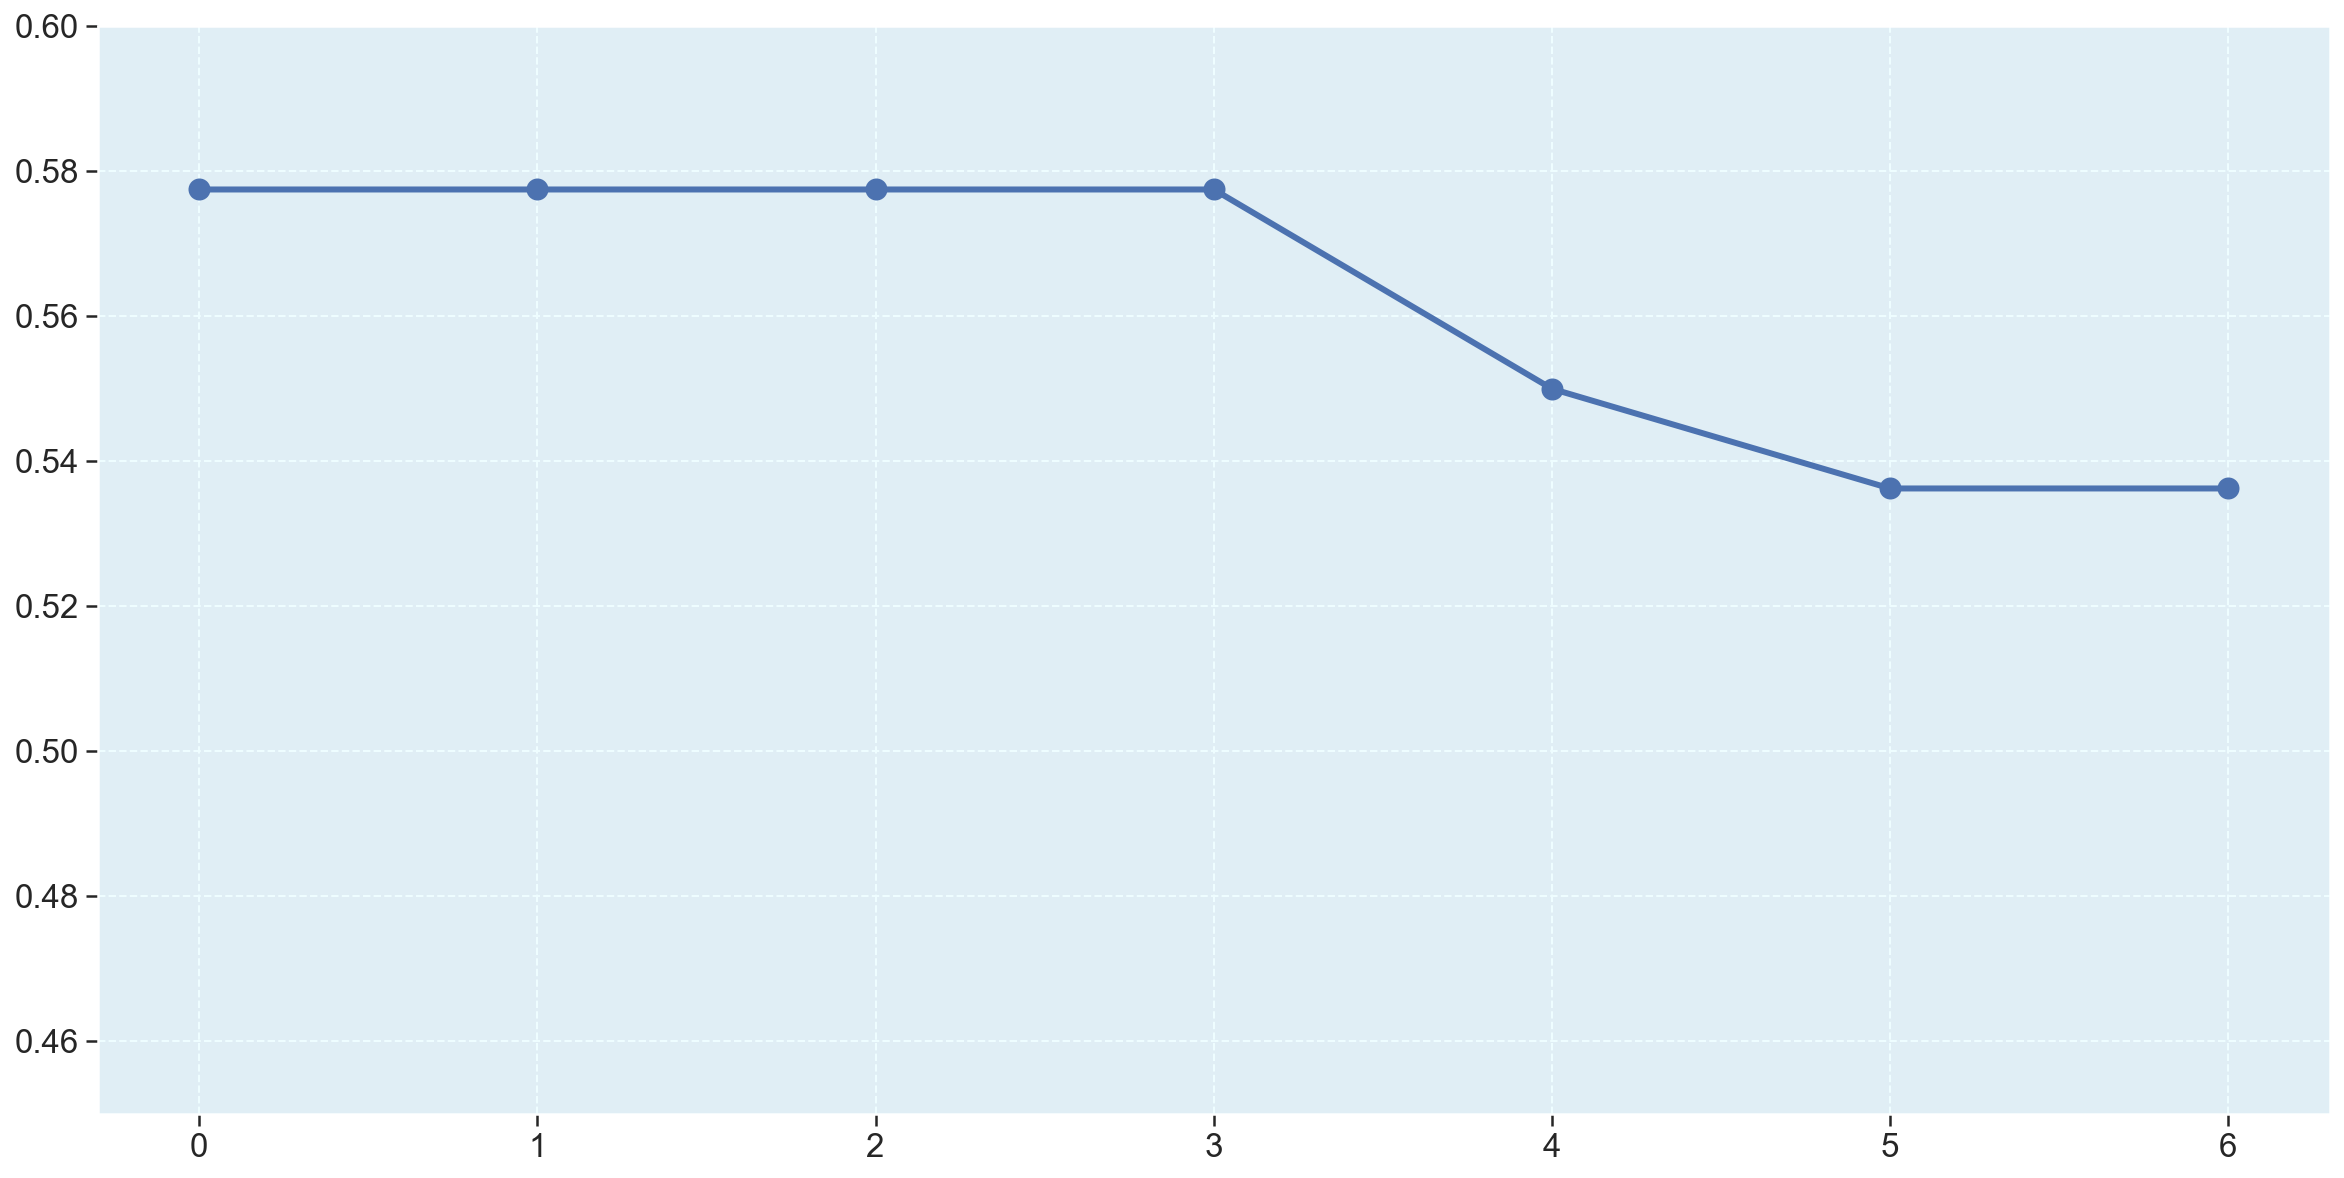

In [49]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.45,.6, color="#c9f9ff", alpha=0.3)

plt.ylim(.45,.6)

(0.53, 0.56)

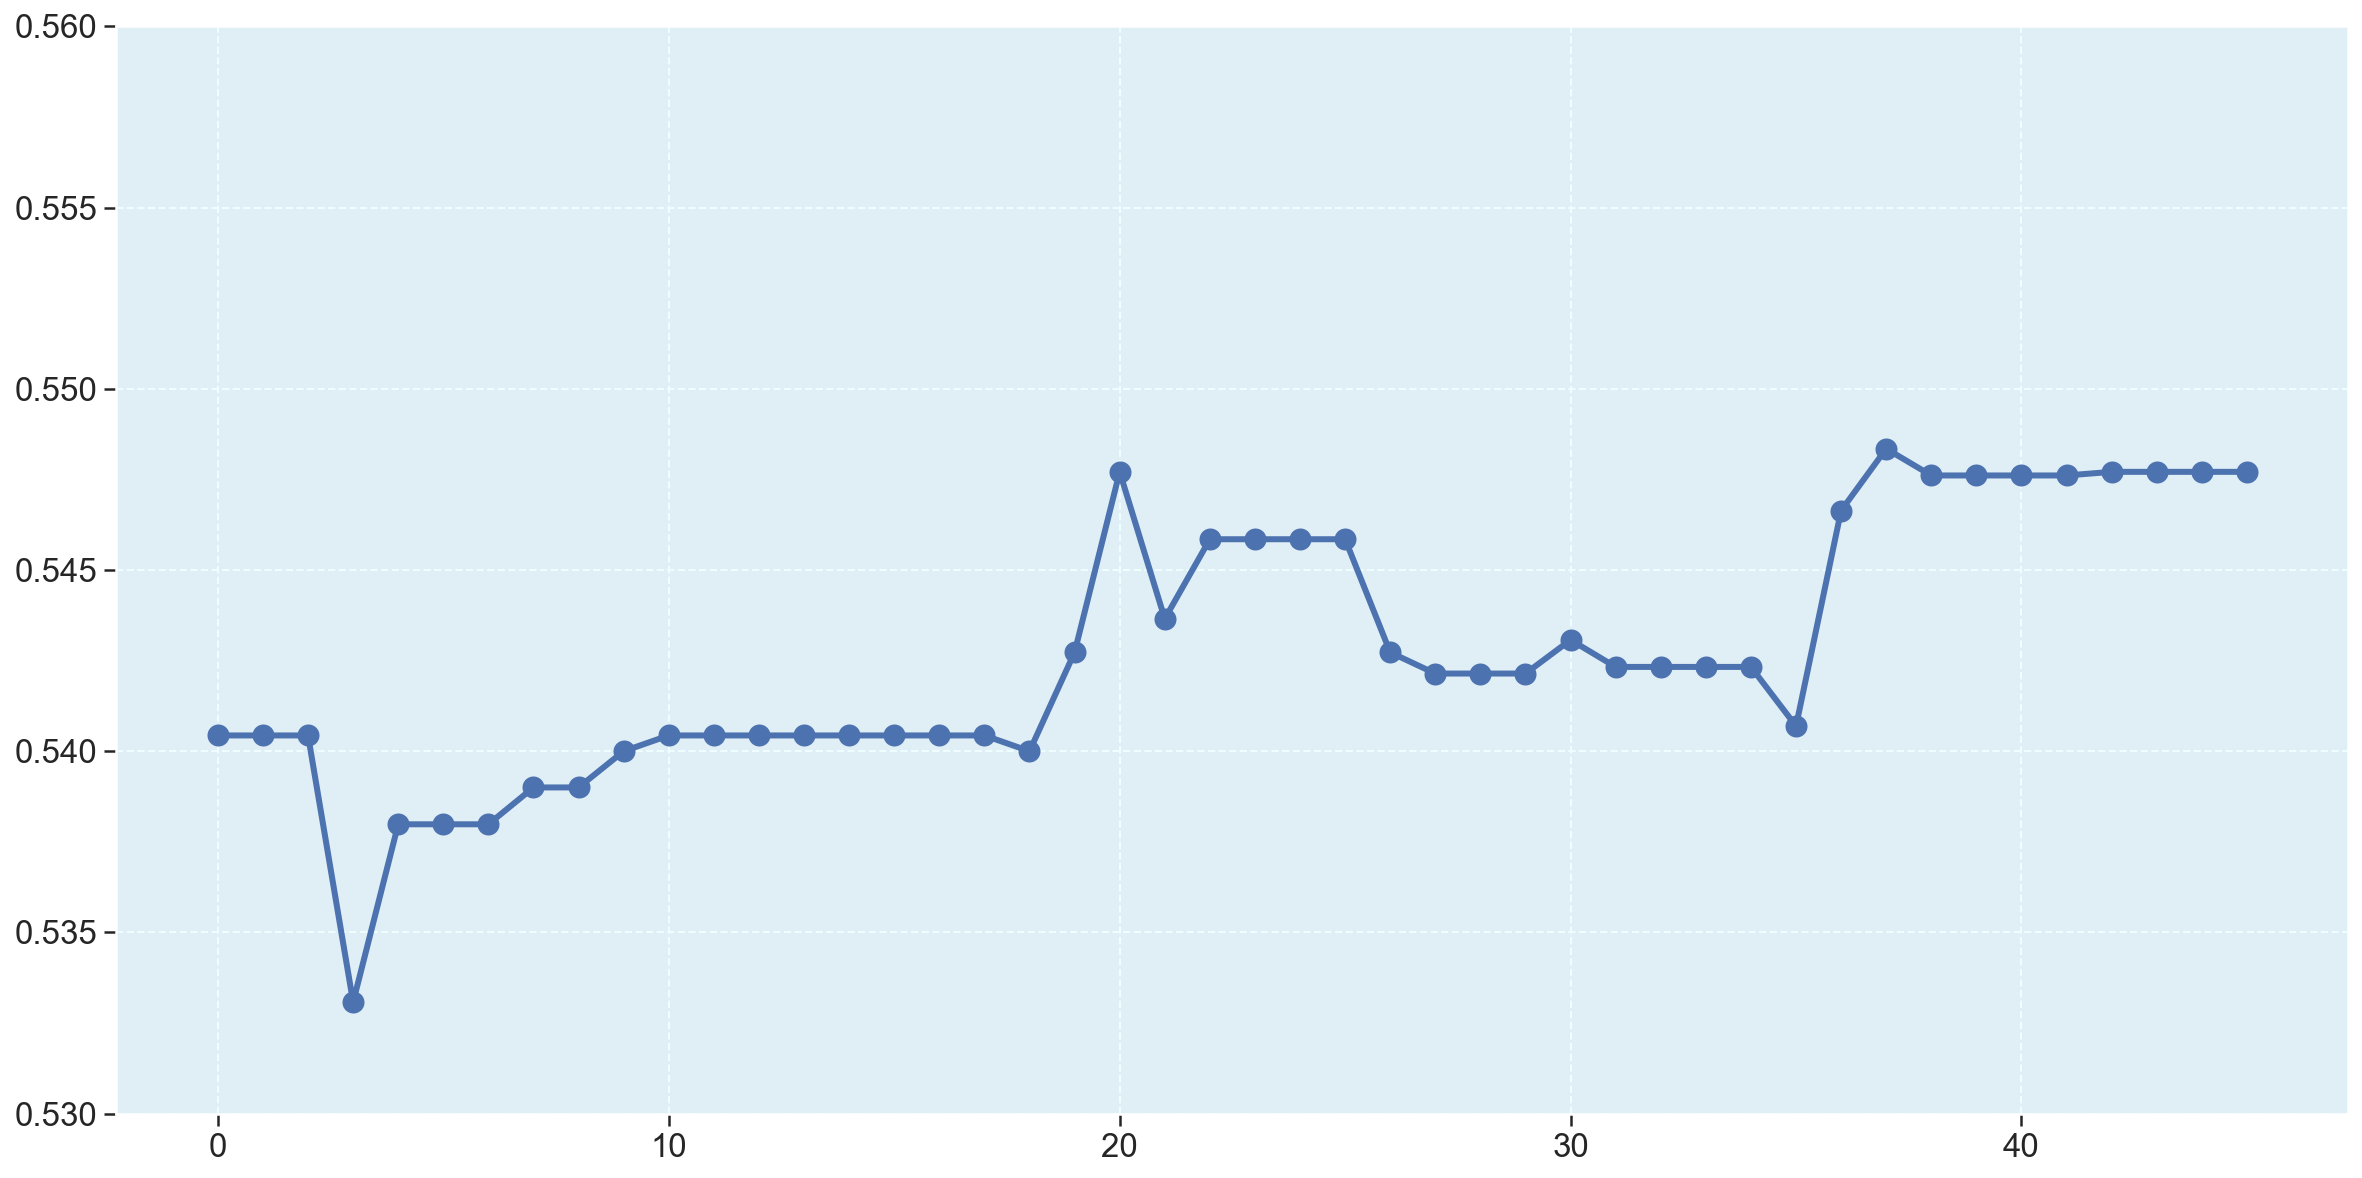

In [50]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.53,.56, color="#c9f9ff", alpha=0.3)

plt.ylim(.53,.56)

(0.52, 0.57)

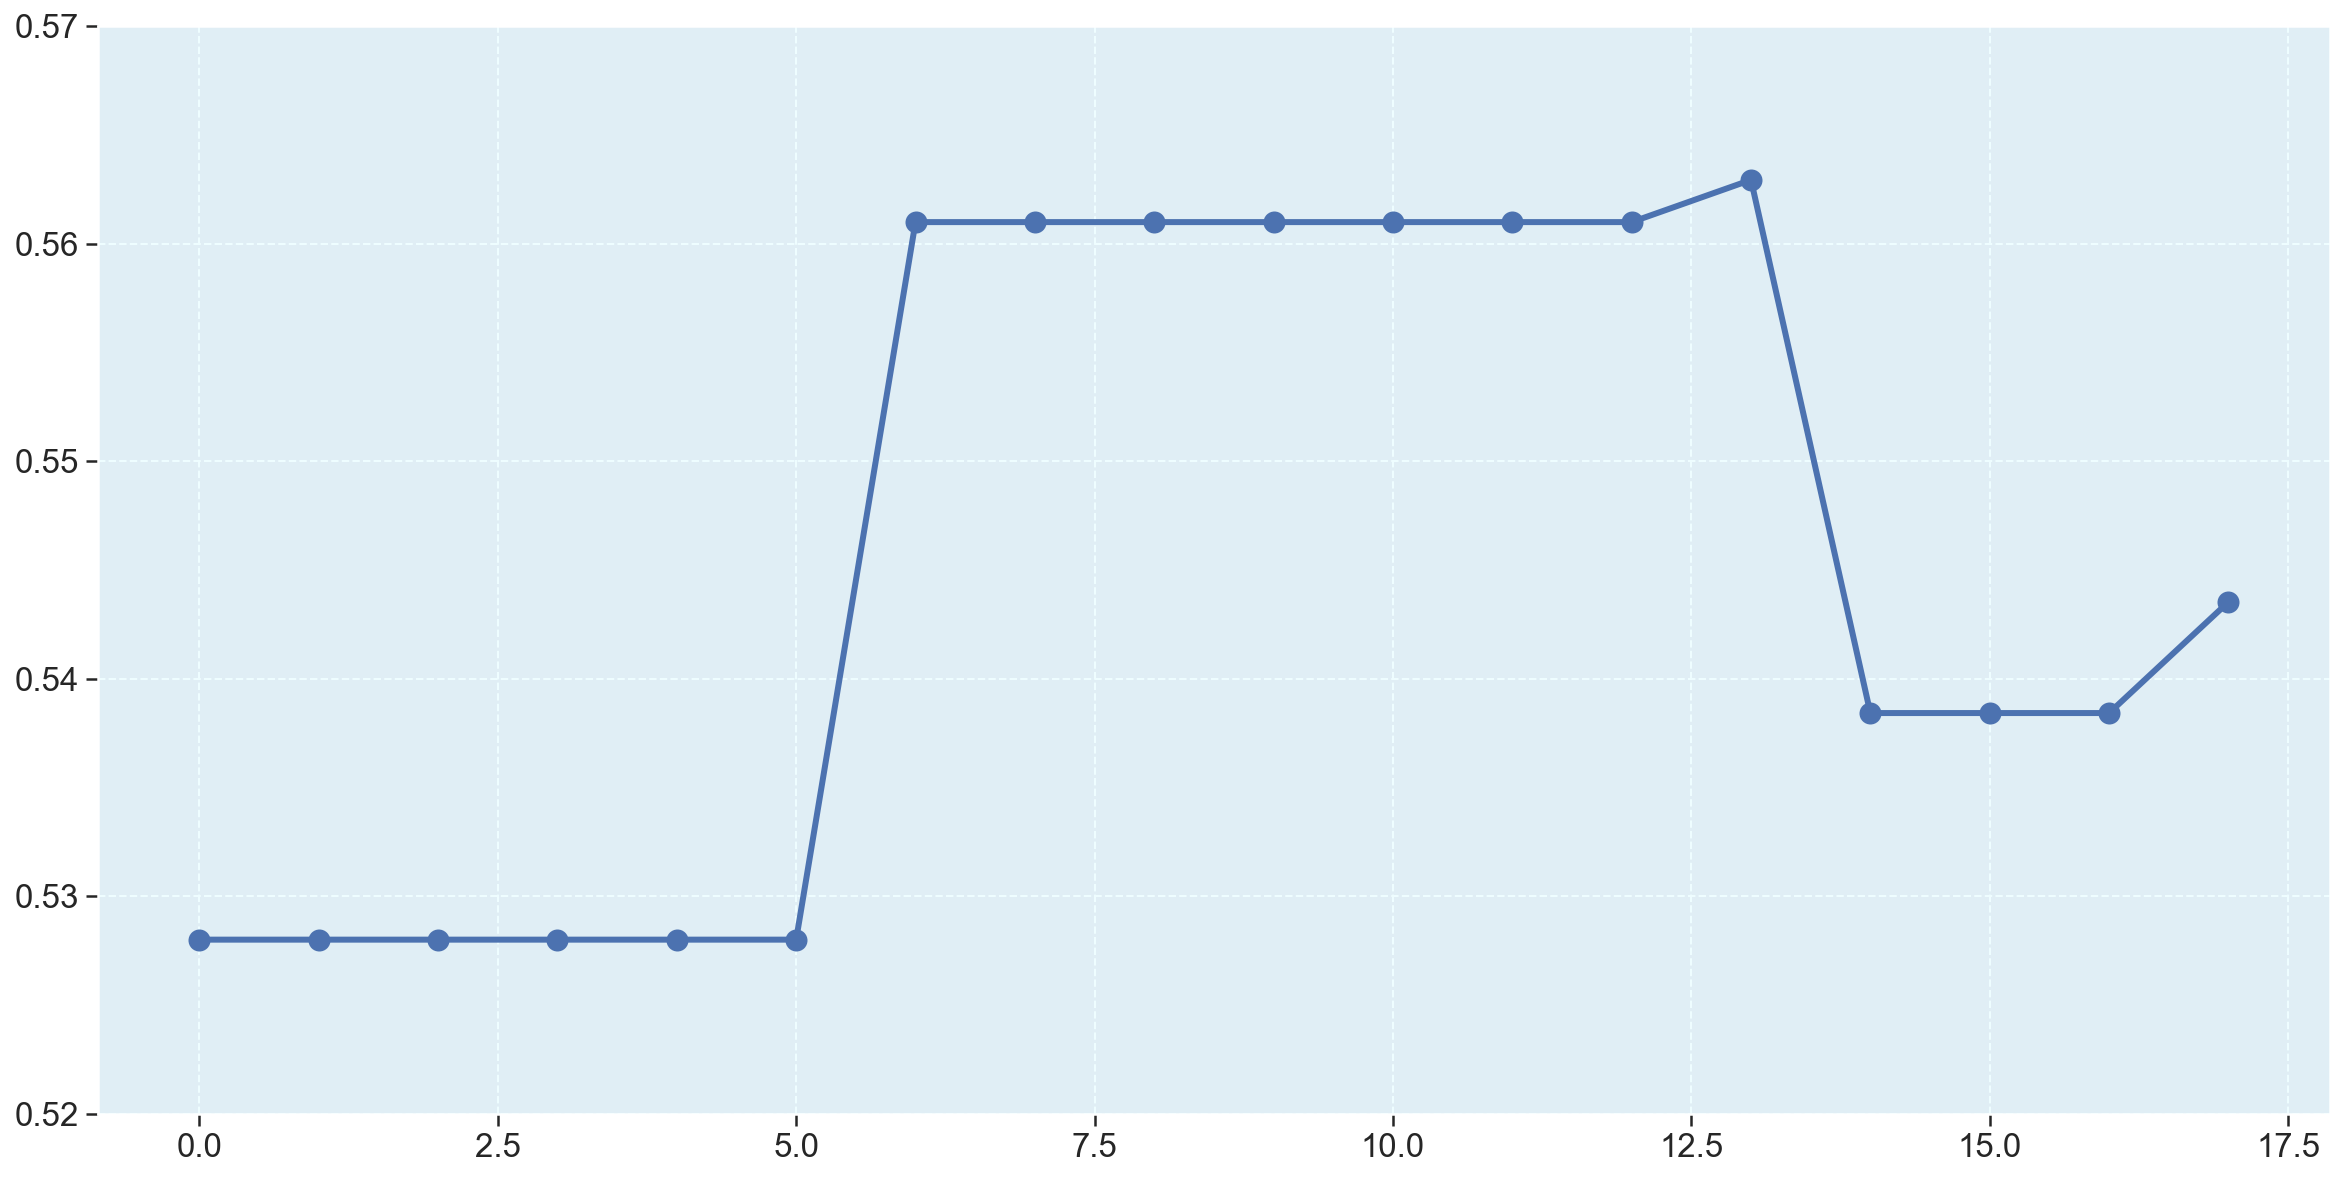

In [51]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.52,.57, color="#c9f9ff", alpha=0.3)

plt.ylim(.52,.57)

(0.52, 0.58)

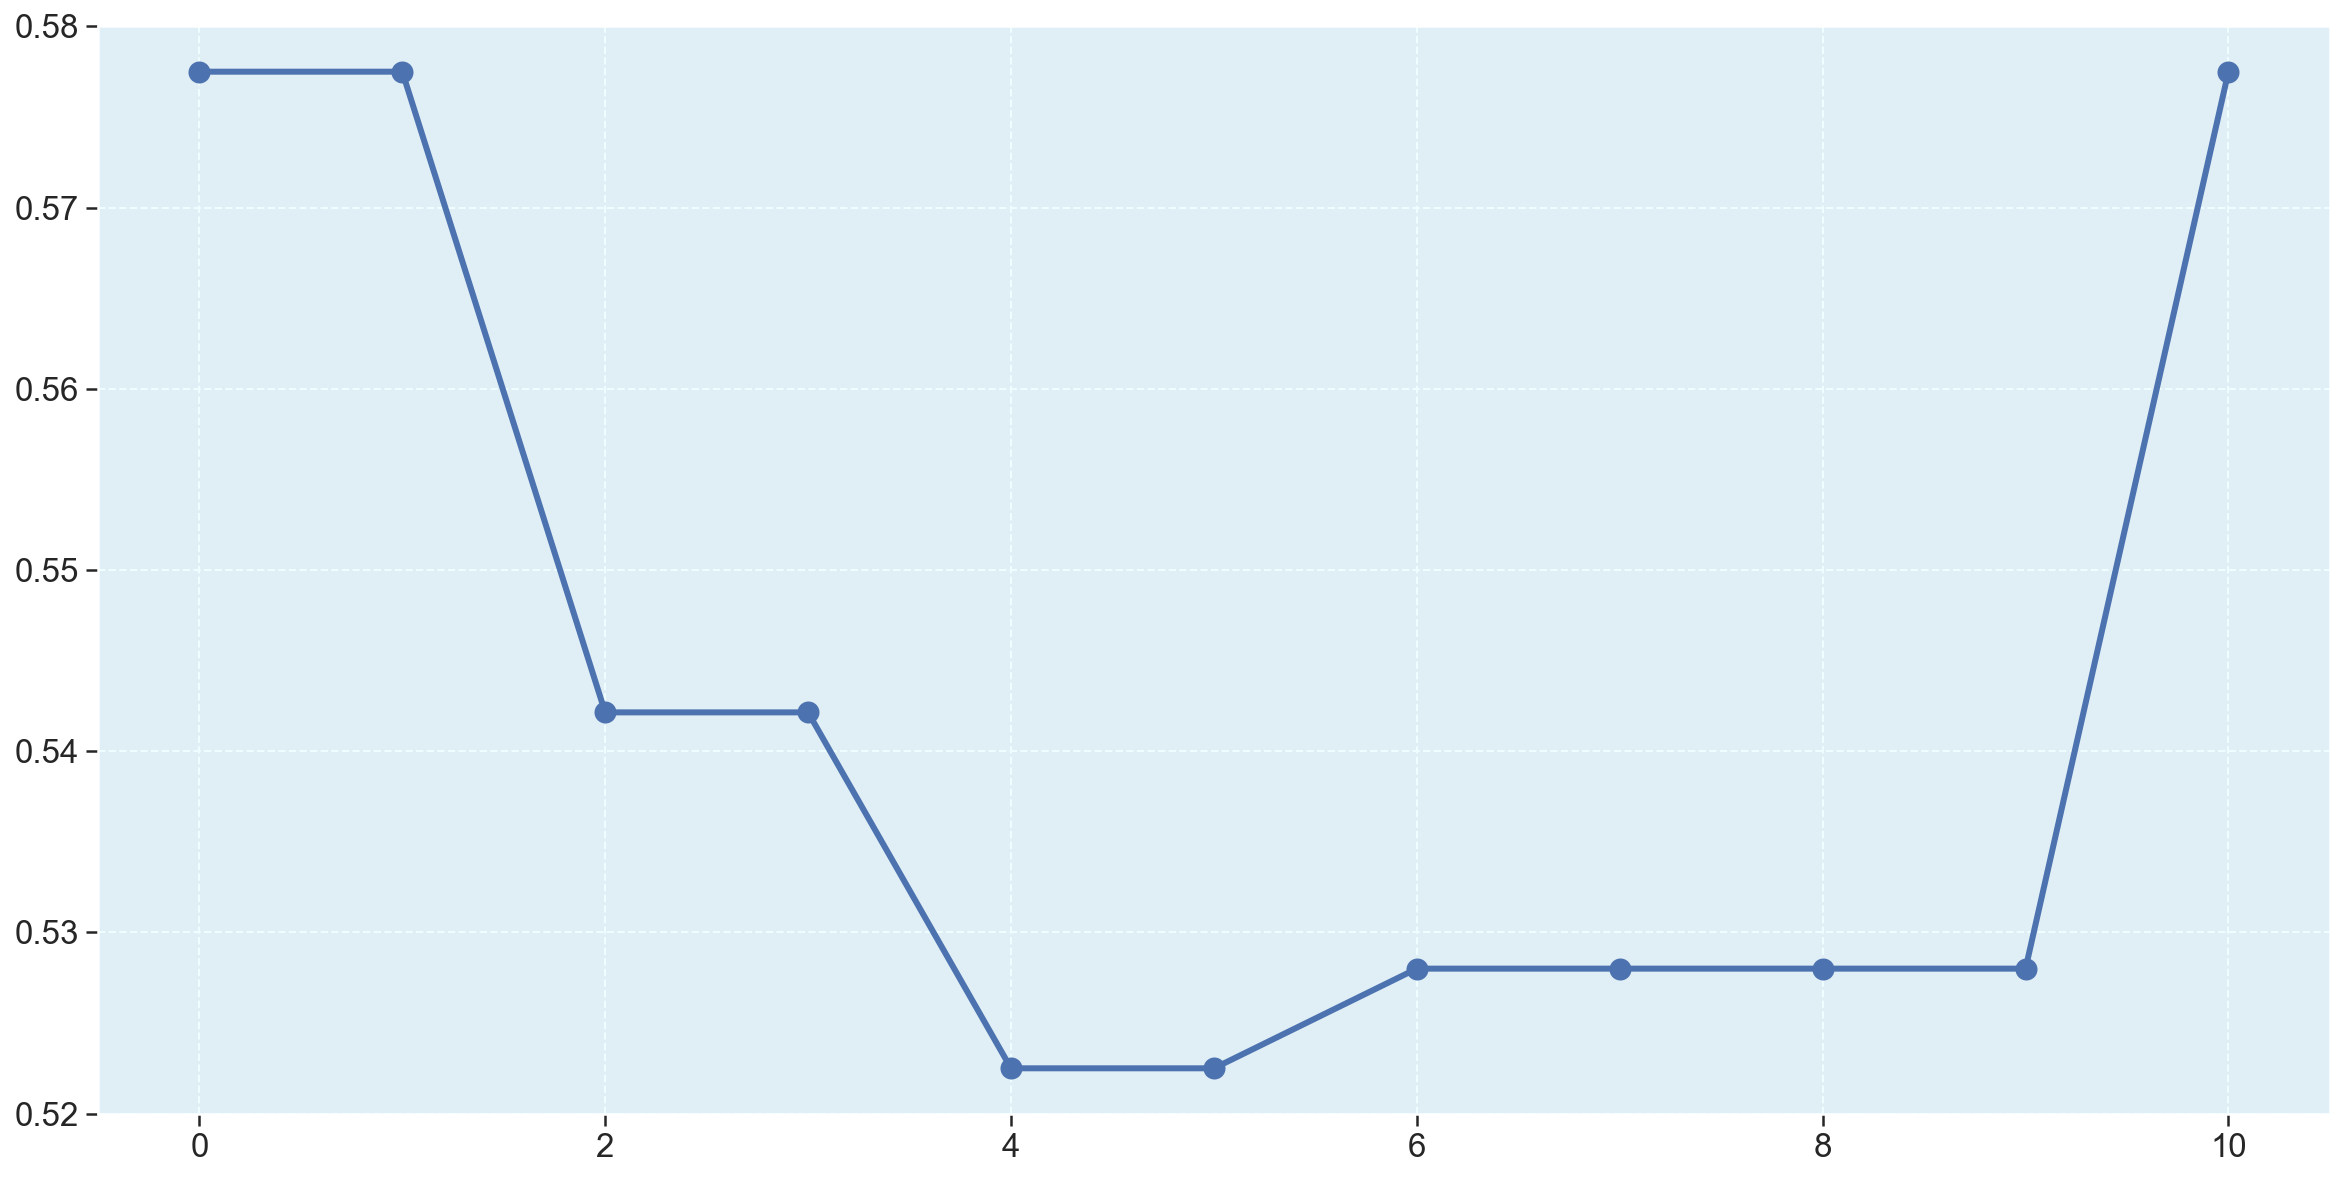

In [52]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.52,.58, color="#c9f9ff", alpha=0.3)

plt.ylim(.52,.58)

(0.48, 0.6)

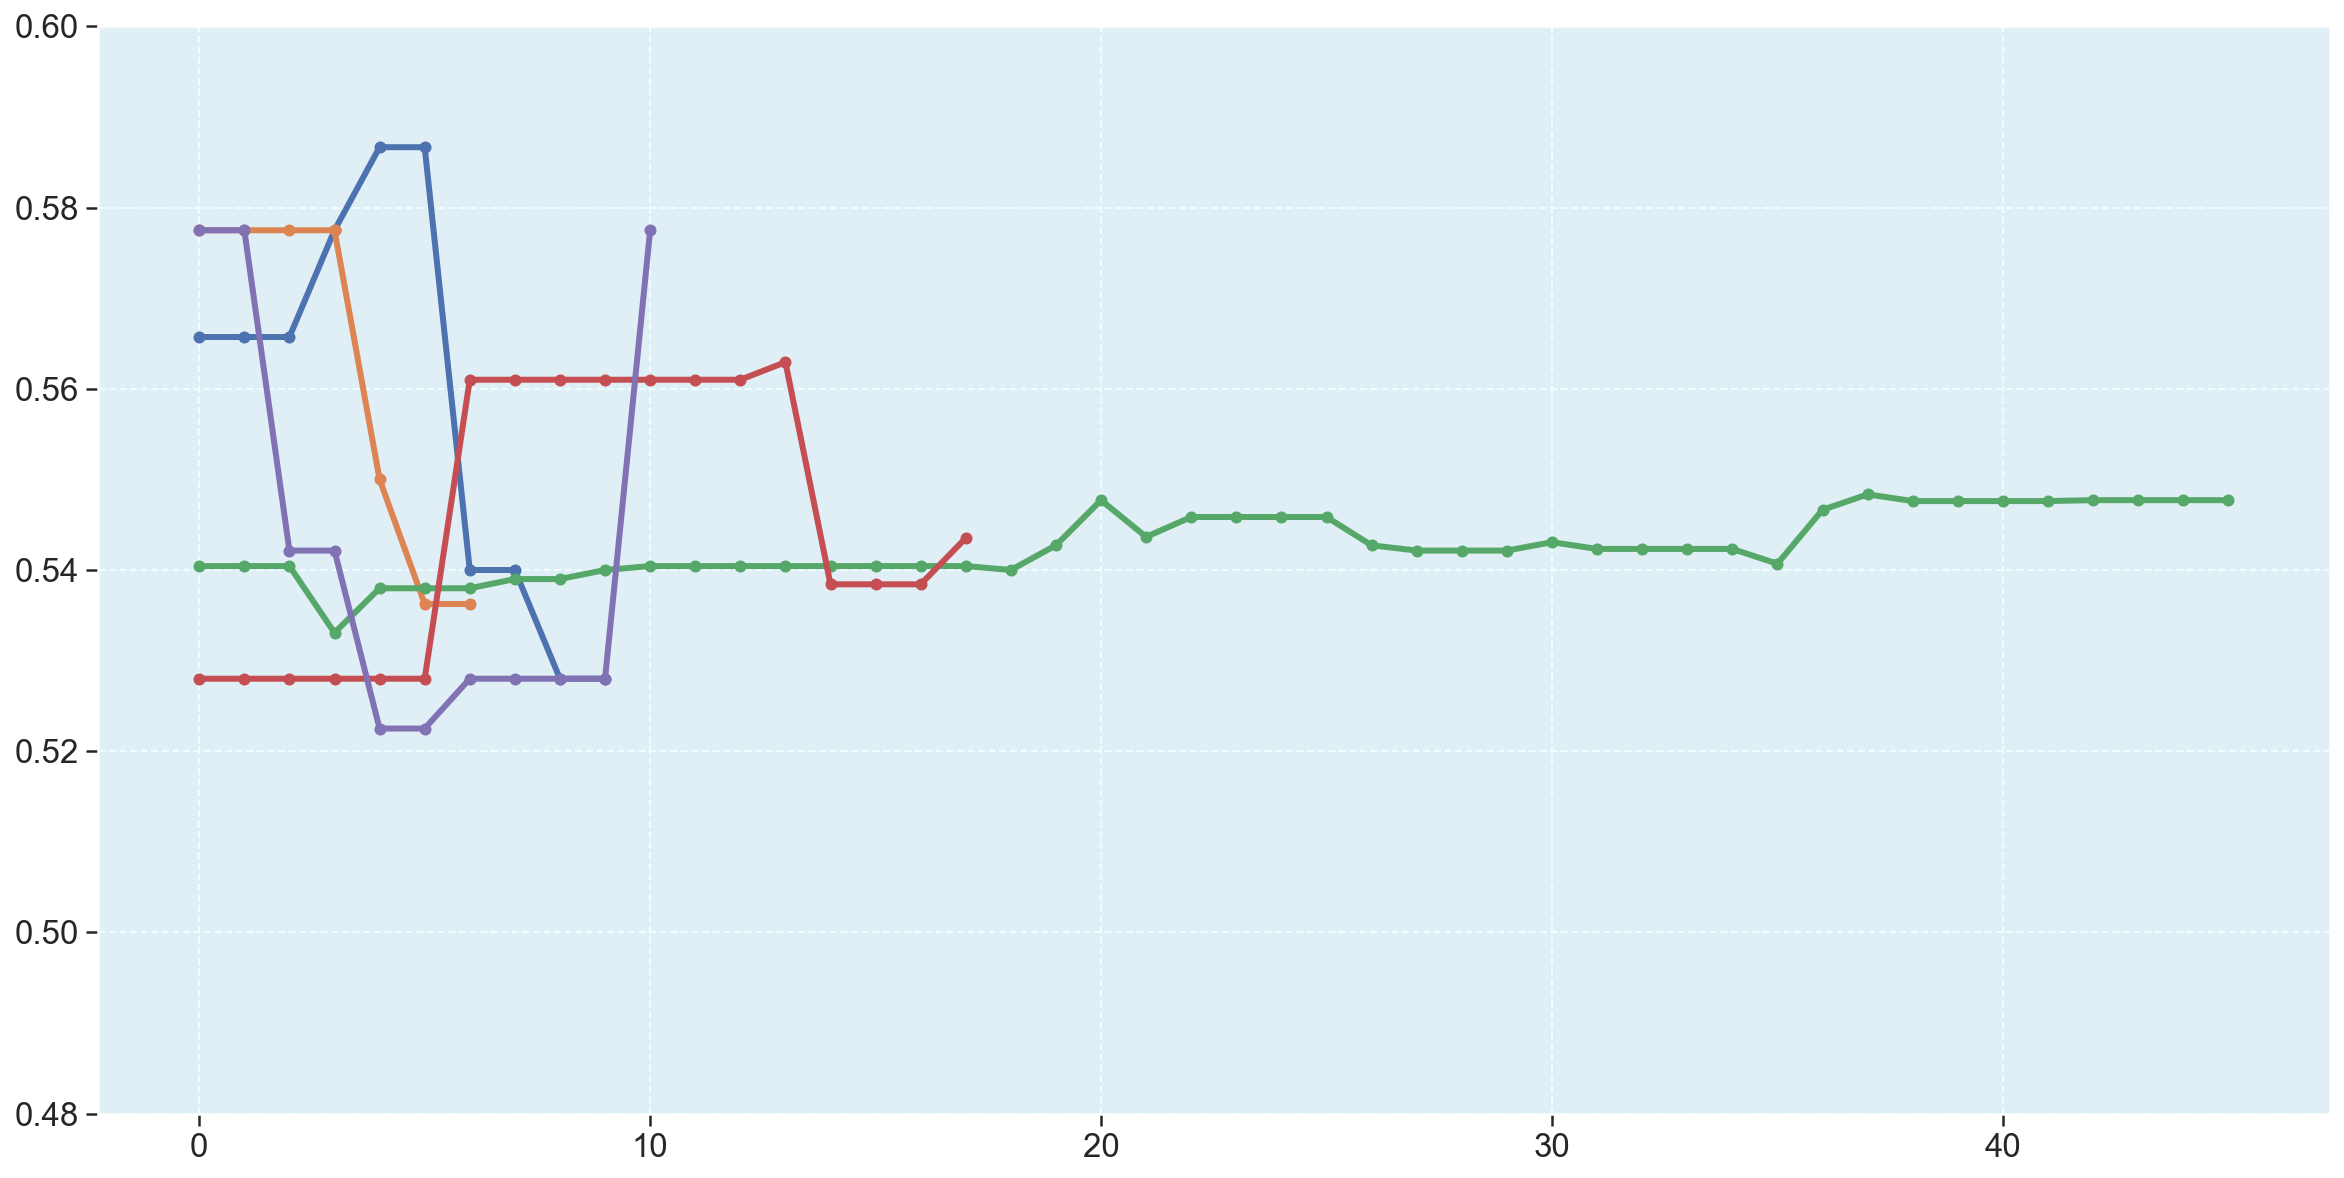

In [53]:
fig = plt.figure(figsize=(20, 10))


plt.plot(users_metrics['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(sectors_metrics['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(frontend_metrics['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(demands_metrics['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(clients_metrics['asc1'], linewidth=3, marker='o', markersize=5)


# Background color
plt.axhspan(.48,.6, color="#c9f9ff", alpha=0.3)

plt.ylim(.48,.6)

In [54]:
metrics_df = pd.concat([users_metrics, sectors_metrics,frontend_metrics,demands_metrics,clients_metrics], ignore_index=True)

In [55]:
metrics_df['ac1'] = metrics_df['asc1'] * 1
metrics_df['total'] = metrics_df['asc1'] * 1

In [56]:
metrics_df


metrics_df.to_excel('data/fga-eps-mds-2020-2-data/siged/qrapids-siged-dataset-23-03-2021-24-05-2021-xlsx.xlsx', index = False)
metrics_df.to_csv('data/fga-eps-mds-2020-2-data/siged/qrapids-siged-dataset-23-03-2021-24-05-2021-csv.csv', header=False, index = False)